# Classification of Ice and Open Water in Norway Fjord and Finland Lake using Sentinel-1 IW Product

### The objectves of our Project is utilized for the data-driven Arctic insights to delivery high-resolution ice metrics using Sentinel-1 SAR (Backscatter data), enabling accurate monitoring of ice stability, coverage, and thickness for climate adaptation.

Impactful Decision-Making: Supports safe Arctic navigation, climate modeling, and EU environmental policies by providing exportable ice data for long-term studies and real-time hazard assessments.

Future-Ready Innovation: Integrates with Eurostat’s statistical framework, offering scalable, automated ice monitoring solutions to enhance climate resilience and sustainable Arctic resource management.

In [1]:
import json
import numpy as np
from pathlib import Path

# Create data directory
data_dir = Path("mystorage/data")
data_dir.mkdir(exist_ok=True)

# Norway fjord simplified
norway_bbox = (4.5, 60.0, 7.5, 61.5)
center_lon = (norway_bbox[0] + norway_bbox[2]) / 2
center_lat = (norway_bbox[1] + norway_bbox[3]) / 2
width = (norway_bbox[2] - norway_bbox[0]) * 0.6
height = (norway_bbox[3] - norway_bbox[1]) * 0.7

# Create fjord shape
fjord_coords = [
    [center_lon - width/2, center_lat - height/2],
    [center_lon - width/4, center_lat - height/4],
    [center_lon, center_lat - height/8],
    [center_lon + width/4, center_lat - height/4],
    [center_lon + width/2, center_lat - height/2],
    [center_lon + width/3, center_lat],
    [center_lon + width/4, center_lat + height/3],
    [center_lon, center_lat + height/2],
    [center_lon - width/4, center_lat + height/3],
    [center_lon - width/3, center_lat],
    [center_lon - width/2, center_lat - height/2]
]

# Create smaller fjords around the main one
small_fjords = []
for i in range(3):
    # Adjust position and size
    shift_lon = np.random.uniform(-0.3, 0.3)
    shift_lat = np.random.uniform(-0.2, 0.2)
    size_factor = np.random.uniform(0.2, 0.4)
    
    # Create smaller fjord
    small_fjord_coords = []
    for x, y in fjord_coords:
        new_x = center_lon + (x - center_lon) * size_factor + shift_lon
        new_y = center_lat + (y - center_lat) * size_factor + shift_lat
        small_fjord_coords.append([new_x, new_y])
    
    small_fjords.append({
        "type": "Feature",
        "properties": {
            "name": f"Small Fjord {i+1}",
            "description": f"Smaller fjord in Norway",
            "water": "fjord",
            "size": "small"
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [small_fjord_coords]
        }
    })

fjord_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "Sognefjord",
                "description": "Example fjord in Norway",
                "water": "fjord",
                "size": "large"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [fjord_coords]
            }
        }
    ] + small_fjords
}

# Finland lake simplified
finland_bbox = (24.5, 61.0, 29.5, 63.0)
center_lon = (finland_bbox[0] + finland_bbox[2]) / 2
center_lat = (finland_bbox[1] + finland_bbox[3]) / 2
width = (finland_bbox[2] - finland_bbox[0]) * 0.5
height = (finland_bbox[3] - finland_bbox[1]) * 0.5

# Generate lake shape
theta = np.linspace(0, 2*np.pi, 30)
lake_coords = [[center_lon + width/2 * np.cos(t), center_lat + height/2 * np.sin(t)] for t in theta]

# Create smaller lakes
small_lakes = []
for i in range(5):
    # Adjust position and size
    new_center_lon = np.random.uniform(finland_bbox[0], finland_bbox[2])
    new_center_lat = np.random.uniform(finland_bbox[1], finland_bbox[3])
    new_width = np.random.uniform(0.1, 0.3) * width
    new_height = np.random.uniform(0.1, 0.3) * height
    
    # Generate lake shape
    lake_theta = np.linspace(0, 2*np.pi, 20)
    small_lake_coords = [[new_center_lon + new_width * np.cos(t), new_center_lat + new_height * np.sin(t)] for t in lake_theta]
    
    small_lakes.append({
        "type": "Feature",
        "properties": {
            "name": f"Small Lake {i+1}",
            "description": f"Smaller lake in Finland",
            "water": "lake",
            "size": "small"
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [small_lake_coords]
        }
    })

lake_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "Saimaa",
                "description": "Example lake in Finland",
                "water": "lake",
                "size": "large"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [lake_coords]
            }
        }
    ] + small_lakes
}

# Save the GeoJSON files
with open(data_dir / "norway_fjord.geojson", 'w') as f:
    json.dump(fjord_geojson, f)

with open(data_dir / "finland_lake.geojson", 'w') as f:
    json.dump(lake_geojson, f)

print("Created GeoJSON files:")
print(f"1. Norway Fjord: {data_dir / 'norway_fjord.geojson'}")
print(f"2. Finland Lake: {data_dir / 'finland_lake.geojson'}")

Created GeoJSON files:
1. Norway Fjord: mystorage/data/norway_fjord.geojson
2. Finland Lake: mystorage/data/finland_lake.geojson


First, let us import all the necessary libraries.

In [3]:
import datetime
import getpass

import matplotlib.pyplot as plt
from matplotlib.patches import Patch
import numpy as np
import geopandas as gpd
import json
from ipyleaflet import Map, GeoJSON, basemaps

from sentinelhub import (
    SHConfig,
    Geometry,
    DataCollection,
    MimeType,
    SentinelHubDownloadClient,
    SentinelHubRequest,
    bbox_to_dimensions,
)

### Establish Credentials

In [4]:
# Only run this cell if you have not created a configuration.

config = SHConfig()
# config.sh_client_id = getpass.getpass("Enter your SentinelHub client id")
# config.sh_client_secret = getpass.getpass("Enter your SentinelHub client secret")
config.sh_token_url = "https://identity.dataspace.copernicus.eu/auth/realms/CDSE/protocol/openid-connect/token"
config.sh_base_url = "https://sh.dataspace.copernicus.eu"
# config.save("cdse")
config = SHConfig("cdse")

In [5]:
# config = SHConfig("team06")

### Defining the Bounds and specific location
We can define the bounds of the area of interest by considering a geojson file of the part of Finland lake and Norway Fjord.

In [6]:
# Example usage
norway_fjord_path = "mystorage/data/finland_lake.geojson"
finland_lake_path = "mystorage/data/norway_fjord.geojson"
river_gdf1 = gpd.read_file(norway_fjord_path)
river_gdf2 = gpd.read_file(finland_lake_path)
# Convert to EPSG 3035
river_gdf1 = river_gdf1.to_crs("EPSG:3035")
river_gdf2 = river_gdf2.to_crs("EPSG:3035")
# Geometry of an entire area
resolution = 20

data1 = json.load(open(norway_fjord_path, "r"))
data2 = json.load(open(finland_lake_path, "r"))

# Set center and zoom level
center = [60.78, 33.68]
zoom = 12

# Add OSM background
m1 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)

# Add geojson data
geo_json1 = GeoJSON(data=data1)
m1.add_layer(geo_json1)

# Display
m1

# Add OSM background
m2 = Map(basemap=basemaps.OpenStreetMap.Mapnik, center=center, zoom=zoom)

# Add geojson data
geo_json2 = GeoJSON(data=data2)
m2.add_layer(geo_json2)

# Display
m2

Map(center=[60.78, 33.68], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_title', 'zoom_o…

Here, we can split the entire time period into 16 slots so that we can get 2 acquisitions every month to capture the freeze-thaw dynamics adequately.

In [7]:
start = datetime.datetime(2023, 9, 1)
end = datetime.datetime(2025, 3, 1)
n_chunks = 17
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

print("Monthly time windows:\n")
for slot in slots:
    print(slot)

Monthly time windows:

('2023-09-01', '2023-10-03')
('2023-10-03', '2023-11-04')
('2023-11-04', '2023-12-06')
('2023-12-06', '2024-01-07')
('2024-01-07', '2024-02-08')
('2024-02-08', '2024-03-12')
('2024-03-12', '2024-04-13')
('2024-04-13', '2024-05-15')
('2024-05-15', '2024-06-16')
('2024-06-16', '2024-07-18')
('2024-07-18', '2024-08-19')
('2024-08-19', '2024-09-21')
('2024-09-21', '2024-10-23')
('2024-10-23', '2024-11-24')
('2024-11-24', '2024-12-26')
('2024-12-26', '2025-01-27')


### Requesting Sentinel-1 (SAR) Data
We now obtain Sentinel-1 IW SAR images covering the two region in the above mentioned time periods. An evalscript is used to describe the processing that needs to be performed on the SAR imagery. This script defines the input and output expected in the `setup()` function and `evaluatePixel()` function defines operations applied at the pixel level. 


In [8]:
# SAR evalscript
evalscript_sar = """
function setup() {
  return {
    input: ["VV", "dataMask"],
    output: { bands: 2, sampleType: "FLOAT32"}
  }
}

// visualizes decibels from -20 to +10
function toDb(linear) {
  var log = 10 * Math.log(linear) / Math.LN10
  return Math.max(0, (log + 20) / 30)
}

function evaluatePixel(sample) {
  var VV = sample.VV;
  return [toDb(VV), sample.dataMask];
}
"""

# Modified SAR request function for Norway
def get_norway_sar_request(time_interval):
    # Calculate bounding box and appropriate dimensions
    bbox = river_gdf1.total_bounds
    bbox_width = bbox[2] - bbox[0]  
    bbox_height = bbox[3] - bbox[1] 
    
    # Calculate resolution that will keep us under 2500 pixels
    # Using max dimension to ensure neither width nor height exceeds the limit
    max_dimension = max(bbox_width, bbox_height)
    min_resolution = max_dimension / 2400  
    resolution = max(min_resolution, 20)
    
    print(f"Norway area dimensions: {bbox_width:.1f}m x {bbox_height:.1f}m")
    print(f"Using resolution of {resolution:.1f}m per pixel")
    
    return SentinelHubRequest(
        evalscript=evalscript_sar,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    "s1iw", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                other_args={
                    "dataFilter": {
                        "resolution": "HIGH",
                        "mosaickingOrder": "mostRecent",
                        "orbitDirection": "ASCENDING",
                    },
                    "processing": {
                        "backCoeff": "SIGMA0_ELLIPSOID",
                        "orthorectify": True,
                        "demInstance": "COPERNICUS",
                        "speckleFilter": {
                            "type": "LEE",
                            "windowSizeX": 3,
                            "windowSizeY": 3,
                        },
                    },
                },
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=Geometry(river_gdf1.geometry.values[0], crs=river_gdf1.crs),
        resolution=(resolution, resolution), 
        config=config,
        data_folder="mystorage/results/norway",
    )

# Modified SAR request function for Finland
def get_finland_sar_request(time_interval):
    # Calculate bounding box and appropriate dimensions
    bbox = river_gdf2.total_bounds
    bbox_width = bbox[2] - bbox[0]  # in meters 
    bbox_height = bbox[3] - bbox[1]  # in meters
    
    # Calculate resolution that will keep us under 2500 pixels
    # Using max dimension to ensure neither width nor height exceeds the limit
    max_dimension = max(bbox_width, bbox_height)
    min_resolution = max_dimension / 2400      
    resolution = max(min_resolution, 20)
    
    print(f"Finland area dimensions: {bbox_width:.1f}m x {bbox_height:.1f}m")
    print(f"Using resolution of {resolution:.1f}m per pixel")
    
    return SentinelHubRequest(
        evalscript=evalscript_sar,
        input_data=[
            SentinelHubRequest.input_data(
                data_collection=DataCollection.SENTINEL1_IW.define_from(
                    "s1iw", service_url=config.sh_base_url
                ),
                time_interval=time_interval,
                other_args={
                    "dataFilter": {
                        "resolution": "HIGH",
                        "mosaickingOrder": "mostRecent",
                        "orbitDirection": "ASCENDING",
                    },
                    "processing": {
                        "backCoeff": "SIGMA0_ELLIPSOID",
                        "orthorectify": True,
                        "demInstance": "COPERNICUS",
                        "speckleFilter": {
                            "type": "LEE",
                            "windowSizeX": 3,
                            "windowSizeY": 3,
                        },
                    },
                },
            )
        ],
        responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
        geometry=Geometry(river_gdf2.geometry.values[0], crs=river_gdf2.crs),
        resolution=(resolution, resolution), 
        config=config,
        data_folder="mystorage/results/finland",
    )


We can create a list of all the requests for each of the time slots and run them together. 

In [10]:
# Function to process and download data
def process_sar_data():
    print("Creating requests for Norway fjords...")
    norway_requests = [get_norway_sar_request(slot) for slot in slots]
    
    print("Creating requests for Finland lakes...")
    finland_requests = [get_finland_sar_request(slot) for slot in slots]
    
    # Prepare download lists
    norway_download_list = [request.download_list[0] for request in norway_requests]
    finland_download_list = [request.download_list[0] for request in finland_requests]
    
    # Download data with multiple threads
    print("Downloading Norway fjord SAR data...")
    norway_data = SentinelHubDownloadClient(config=config).download(
        norway_download_list, max_threads=5
    )
    
    print("Downloading Finland lake SAR data...")
    finland_data = SentinelHubDownloadClient(config=config).download(
        finland_download_list, max_threads=5
    )
    
    return norway_data, finland_data


In [11]:
# Function to visualize results
def visualize_sar_data(norway_data, finland_data):
    # Create figure for Norway fjord
    fig, axs = plt.subplots(len(norway_data), 1, figsize=(10, 4 * len(norway_data)))
    if len(norway_data) == 1:
        axs = [axs]
    
    for idx, data in enumerate(norway_data):
        axs[idx].imshow(data[..., 0], cmap='viridis')
        axs[idx].set_title(f"Norway Fjord - Time slot {idx+1}")
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig("mystorage/results/norway_sar_data.png")
    plt.close()
    
    # Create figure for Finland lake
    fig, axs = plt.subplots(len(finland_data), 1, figsize=(10, 4 * len(finland_data)))
    if len(finland_data) == 1:
        axs = [axs]
    
    for idx, data in enumerate(finland_data):
        axs[idx].imshow(data[..., 0], cmap='viridis')
        axs[idx].set_title(f"Finland Lake - Time slot {idx+1}")
        axs[idx].axis('off')
    
    plt.tight_layout()
    plt.savefig("mystorage/results/finland_sar_data.png")
    plt.close()

# Run processing if executed as script
if __name__ == "__main__":
    
    results_dir = Path("mystorage/results")
    results_dir.mkdir(exist_ok=True)
    
    try:
        # Import missing module for downloading
        from sentinelhub import SentinelHubDownloadClient
        
        # Process and download data
        norway_data, finland_data = process_sar_data()
        
        # Visualize the results
        visualize_sar_data(norway_data, finland_data)
        
        print("Processing complete!")
        
    except Exception as e:
        print(f"Error during processing: {e}")
        
        # Create placeholder data if API fails
        print("Creating placeholder data...")
        
        # Create empty directories for results
        (results_dir / "norway").mkdir(exist_ok=True)
        (results_dir / "finland").mkdir(exist_ok=True)
        
        # Save a placeholder image for demonstration
        dummy_img = np.random.rand(100, 100)
        plt.figure(figsize=(10, 8))
        plt.imshow(dummy_img, cmap='viridis')
        plt.title("Placeholder SAR Data (API error occurred)")
        plt.axis('off')
        plt.savefig("mystorage/results/placeholder_sar_data.png")
        plt.close()
        
        print("Created placeholder visualization.")

Creating requests for Norway fjords...
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolution of 99.4m per pixel
Norway area dimensions: 238587.7m x 176303.8m
Using resolut

In [12]:
#visualization:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import datetime
from pathlib import Path

In [13]:

def enhanced_visualize_sar_data(norway_data, finland_data, slots):
    """
    Create enhanced visualizations of SAR data with more informative elements
    
    Parameters:
    -----------
    norway_data : list
        List of SAR data arrays for Norway
    finland_data : list
        List of SAR data arrays for Finland
    slots : list
        List of time slots (date ranges)
    """
    # Create results directory if it doesn't exist
    results_dir = Path("mystorage/results")
    results_dir.mkdir(exist_ok=True)
    
    # Define a custom colormap for water features
    # Blue for waater, with darker blues indicating higher backscatter
    water_colors = [(0.9, 0.9, 1), (0, 0.3, 0.8), (0, 0, 0.6)]
    blue_cmap = LinearSegmentedColormap.from_list('water_blues', water_colors, N=256)
    
    print(f"Visualizing {len(norway_data)} Norway fjord SAR images...")
    # Create figure for Norway fjord - all time slots in a grid
    n_rows = int(np.ceil(len(norway_data) / 3)) 
    fig_norway = plt.figure(figsize=(15, 5 * n_rows))
    
    for idx, data in enumerate(norway_data):
        # Get time slot for this image
        time_slot = slots[idx]
        start_date = time_slot[0]
        end_date = time_slot[1]
        
        # Create subplot in a grid (3 columns)
        ax = fig_norway.add_subplot(n_rows, 3, idx + 1)
        
        # Extract SAR data (first band) and mask (second band)
        sar_data = data[..., 0]
        mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
        
        # Apply mask
        masked_data = np.ma.masked_where(mask == 0, sar_data)
        
        # Plot the data
        im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
        
        # Add title with date range
        ax.set_title(f"Norway Fjord\n{start_date} to {end_date}")
        ax.axis('off')
    
    # Add colorbar to the right of the last subplot
    plt.tight_layout()
    fig_norway.subplots_adjust(right=0.9)
    cbar_ax = fig_norway.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig_norway.colorbar(im, cax=cbar_ax)
    cbar.set_label('SAR backscatter (dB scaled)')
    
    # Add legend explaining what colors mean
    handles = [
        mpatches.Patch(color=water_colors[0], label='Low backscatter (smooth water)'),
        mpatches.Patch(color=water_colors[1], label='Medium backscatter'),
        mpatches.Patch(color=water_colors[2], label='High backscatter (rough water)')
    ]
    fig_norway.legend(handles=handles, loc='lower center', ncol=3)
    
    # Save the figure
    plt.savefig(results_dir / "norway_sar_grid.png", dpi=300, bbox_inches='tight')
    plt.close(fig_norway)
    
    # Create a time series analysis (average backscatter over time)
    if len(norway_data) > 1:
        fig_ts_norway, ax_ts = plt.subplots(figsize=(12, 6))
        
        # Extract average backscatter for each time slot
        mean_values = [np.ma.mean(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in norway_data]
        std_values = [np.ma.std(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in norway_data]
        
        # Convert dates to datetime objects for better plotting
        dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots[:len(norway_data)]]
        
        # Plot the time series
        ax_ts.errorbar(dates, mean_values, yerr=std_values, marker='o', linestyle='-', capsize=5)
        ax_ts.set_title("Norway Fjord: Average SAR Backscatter Over Time")
        ax_ts.set_xlabel("Date")
        ax_ts.set_ylabel("Average Backscatter (scaled)")
        ax_ts.grid(True, alpha=0.3)
        
        fig_ts_norway.autofmt_xdate()  # Rotate date labels
        plt.tight_layout()
        plt.savefig(results_dir / "norway_sar_timeseries.png", dpi=300)
        plt.close(fig_ts_norway)
    
    print(f"Visualizing {len(finland_data)} Finland lake SAR images...")
    # Create figure for Finland lake - all time slots in a grid
    n_rows = int(np.ceil(len(finland_data) / 3))  # 3 columns
    fig_finland = plt.figure(figsize=(15, 5 * n_rows))
    
    for idx, data in enumerate(finland_data):
        # Get time slot for this image
        time_slot = slots[idx]
        start_date = time_slot[0]
        end_date = time_slot[1]
        
        # Create subplot in a grid (3 columns)
        ax = fig_finland.add_subplot(n_rows, 3, idx + 1)
        
        # Extract SAR data (first band) and mask (second band)
        sar_data = data[..., 0]
        mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
        
        # Apply mask
        masked_data = np.ma.masked_where(mask == 0, sar_data)
        
        # Plot the data
        im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
        
        # Add title with date range
        ax.set_title(f"Finland Lake\n{start_date} to {end_date}")
        ax.axis('off')
    
    # Add colorbar to the right of the last subplot
    plt.tight_layout()
    fig_finland.subplots_adjust(right=0.9)
    cbar_ax = fig_finland.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig_finland.colorbar(im, cax=cbar_ax)
    cbar.set_label('SAR backscatter (dB scaled)')
    
    # Add legend explaining what colors mean
    handles = [
        mpatches.Patch(color=water_colors[0], label='Low backscatter (smooth water)'),
        mpatches.Patch(color=water_colors[1], label='Medium backscatter'),
        mpatches.Patch(color=water_colors[2], label='High backscatter (rough water)')
    ]
    fig_finland.legend(handles=handles, loc='lower center', ncol=3)
    
    # Save the figure
    plt.savefig(results_dir / "finland_sar_grid.png", dpi=300, bbox_inches='tight')
    plt.close(fig_finland)
    
    # Create a time series analysis (average backscatter over time)
    if len(finland_data) > 1:
        fig_ts_finland, ax_ts = plt.subplots(figsize=(12, 6))
        
        # Extract average backscatter for each time slot
        mean_values = [np.ma.mean(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in finland_data]
        std_values = [np.ma.std(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in finland_data]
        
        # Convert dates to datetime objects for better plotting
        dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots[:len(finland_data)]]
        
        # Plot the time series
        ax_ts.errorbar(dates, mean_values, yerr=std_values, marker='o', linestyle='-', capsize=5)
        ax_ts.set_title("Finland Lake: Average SAR Backscatter Over Time")
        ax_ts.set_xlabel("Date")
        ax_ts.set_ylabel("Average Backscatter (scaled)")
        ax_ts.grid(True, alpha=0.3)
        
        fig_ts_finland.autofmt_xdate()  # Rotate date labels
        plt.tight_layout()
        plt.savefig(results_dir / "finland_sar_timeseries.png", dpi=300)
        plt.close(fig_ts_finland)
    
    # Create histogram comparison
    if len(norway_data) > 0 and len(finland_data) > 0:
        fig_hist, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
        
        # Use the first time slot for the histogram comparison
        norway_first = norway_data[0][..., 0].flatten()
        finland_first = finland_data[0][..., 0].flatten()
        
        # Remove masked values (zeros)
        norway_first = norway_first[norway_first > 0]
        finland_first = finland_first[finland_first > 0]
        
        # Plot histograms
        ax1.hist(norway_first, bins=50, alpha=0.7, color='navy', label='Norway Fjord')
        ax1.hist(finland_first, bins=50, alpha=0.7, color='royalblue', label='Finland Lake')
        ax1.set_title("Histogram of SAR Backscatter Values")
        ax1.set_xlabel("Backscatter (scaled)")
        ax1.set_ylabel("Frequency")
        ax1.legend()
        ax1.grid(True, alpha=0.3)
        
        # Plot cumulative distributions
        ax2.hist(norway_first, bins=50, alpha=0.7, color='navy', label='Norway Fjord', 
                 cumulative=True, density=True)
        ax2.hist(finland_first, bins=50, alpha=0.7, color='royalblue', label='Finland Lake', 
                 cumulative=True, density=True)
        ax2.set_title("Cumulative Distribution of SAR Backscatter")
        ax2.set_xlabel("Backscatter (scaled)")
        ax2.set_ylabel("Cumulative Probability")
        ax2.legend()
        ax2.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.savefig(results_dir / "sar_histogram_comparison.png", dpi=300)
        plt.close(fig_hist)
    
    print("All visualizations saved to:", results_dir)



In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import datetime
from pathlib import Path
from matplotlib.colors import LinearSegmentedColormap

In [16]:
def visualize_sar_data(norway_data, finland_data, slots):
    """
    Generate static visualizations of SAR data and save them to files
    
    Parameters:
    -----------
    norway_data : list
        List of SAR data arrays for Norway
    finland_data : list
        List of SAR data arrays for Finland
    slots : list
        List of time slots (date ranges)
    """
    # Create results directory
    results_dir = Path("mystorage/results")
    results_dir.mkdir(exist_ok=True)
    
    # Define a custom colormap for water features
    water_colors = [(0.9, 0.9, 1), (0, 0.3, 0.8), (0, 0, 0.6)]
    blue_cmap = LinearSegmentedColormap.from_list('water_blues', water_colors, N=256)
    
    print(f"Visualizing {len(norway_data)} Norway fjord SAR images...")
    

##### 

In [17]:
# Define a custom colormap for water features
water_colors = [(0.9, 0.9, 1), (0, 0.3, 0.8), (0, 0, 0.6)]
blue_cmap = LinearSegmentedColormap.from_list('water_blues', water_colors, N=256)

# Process Norway images
print(f"Visualizing {len(norway_data)} Norway fjord SAR images...")
for idx, data in enumerate(norway_data):
    if idx >= len(slots):
        break
        
    # Get time slot for this image
    time_slot = slots[idx]
    start_date = time_slot[0]
    end_date = time_slot[1]
    
    # Create a figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Extract SAR data (first band) and mask (second band)
    sar_data = data[..., 0]
    mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
    
    # Apply mask
    masked_data = np.ma.masked_where(mask == 0, sar_data)
    
    # Plot the data
    im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
    
    # Add title with date range
    ax.set_title(f"Norway Fjord: {start_date} to {end_date}", fontsize=14)
    ax.axis('off')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('SAR backscatter (dB scaled)')
    
    # Save the figure
    output_path = results_dir / f"norway_sar_{idx}.png"
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"  Saved image {idx+1}/{len(norway_data)}: {output_path}")

# Process Finland images
print(f"Visualizing {len(finland_data)} Finland lake SAR images...")
for idx, data in enumerate(finland_data):
    if idx >= len(slots):
        break
        
    # Get time slot for this image
    time_slot = slots[idx]
    start_date = time_slot[0]
    end_date = time_slot[1]
    
    # Create a figure
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111)
    
    # Extract SAR data (first band) and mask (second band)
    sar_data = data[..., 0]
    mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
    
    # Apply mask
    masked_data = np.ma.masked_where(mask == 0, sar_data)
    
    # Plot the data
    im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
    
    # Add title with date range
    ax.set_title(f"Finland Lake: {start_date} to {end_date}", fontsize=14)
    ax.axis('off')
    
    # Add colorbar
    cbar = fig.colorbar(im, ax=ax)
    cbar.set_label('SAR backscatter (dB scaled)')
    
    # Save the figure
    output_path = results_dir / f"finland_sar_{idx}.png" 
    plt.savefig(output_path, dpi=300, bbox_inches='tight')
    plt.close(fig)
    
    print(f"  Saved image {idx+1}/{len(finland_data)}: {output_path}")

Visualizing 16 Norway fjord SAR images...
  Saved image 1/16: mystorage/results/norway_sar_0.png
  Saved image 2/16: mystorage/results/norway_sar_1.png
  Saved image 3/16: mystorage/results/norway_sar_2.png
  Saved image 4/16: mystorage/results/norway_sar_3.png
  Saved image 5/16: mystorage/results/norway_sar_4.png
  Saved image 6/16: mystorage/results/norway_sar_5.png
  Saved image 7/16: mystorage/results/norway_sar_6.png
  Saved image 8/16: mystorage/results/norway_sar_7.png
  Saved image 9/16: mystorage/results/norway_sar_8.png
  Saved image 10/16: mystorage/results/norway_sar_9.png
  Saved image 11/16: mystorage/results/norway_sar_10.png
  Saved image 12/16: mystorage/results/norway_sar_11.png
  Saved image 13/16: mystorage/results/norway_sar_12.png
  Saved image 14/16: mystorage/results/norway_sar_13.png
  Saved image 15/16: mystorage/results/norway_sar_14.png
  Saved image 16/16: mystorage/results/norway_sar_15.png
Visualizing 16 Finland lake SAR images...
  Saved image 1/16: mys

In [18]:
# Create summary visualizations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.colors import LinearSegmentedColormap
import datetime
from pathlib import Path

In [19]:
# Define the custom colormap for consistency
water_colors = [(0.9, 0.9, 1), (0, 0.3, 0.8), (0, 0, 0.6)]
blue_cmap = LinearSegmentedColormap.from_list('water_blues', water_colors, N=256)

# Create a grid view of all Norway images
print("Creating Norway grid visualization...")
n_cols = min(4, len(norway_data)) 
n_rows = int(np.ceil(len(norway_data) / n_cols))

fig_grid = plt.figure(figsize=(16, 4 * n_rows))

for idx, data in enumerate(norway_data):
    if idx >= len(slots):
        break
        
    # Get time slot
    time_slot = slots[idx]
    start_date = time_slot[0]
    end_date = time_slot[1]
    
    # Create subplot
    ax = fig_grid.add_subplot(n_rows, n_cols, idx + 1)
    
    # Extract and plot data
    sar_data = data[..., 0]
    mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
    masked_data = np.ma.masked_where(mask == 0, sar_data)
    
    im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
    ax.set_title(f"{start_date} to {end_date}")
    ax.axis('off')

# Add colorbar
fig_grid.subplots_adjust(right=0.9)
cbar_ax = fig_grid.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig_grid.colorbar(im, cax=cbar_ax)
cbar.set_label('SAR backscatter (dB scaled)')

# Add legend
handles = [
    mpatches.Patch(color=water_colors[0], label='Low backscatter (smooth water)'),
    mpatches.Patch(color=water_colors[1], label='Medium backscatter'),
    mpatches.Patch(color=water_colors[2], label='High backscatter (rough water)')
]
fig_grid.legend(handles=handles, loc='lower center', ncol=3)

# Add overall title
plt.suptitle("Norway Fjord SAR Data Grid", fontsize=18, y=0.98)

# Save the grid
grid_path = results_dir / "norway_sar_grid.png"
plt.savefig(grid_path, dpi=300, bbox_inches='tight')
plt.close(fig_grid)

print(f"  Saved grid visualization: {grid_path}")

# Create a grid view of all Finland images
print("Creating Finland grid visualization...")
n_cols = min(4, len(finland_data)) 
n_rows = int(np.ceil(len(finland_data) / n_cols))

fig_grid = plt.figure(figsize=(16, 4 * n_rows))

for idx, data in enumerate(finland_data):
    if idx >= len(slots):
        break
        
    # Get time slot
    time_slot = slots[idx]
    start_date = time_slot[0]
    end_date = time_slot[1]
    
    # Create subplot
    ax = fig_grid.add_subplot(n_rows, n_cols, idx + 1)
    
    # Extract and plot data
    sar_data = data[..., 0]
    mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
    masked_data = np.ma.masked_where(mask == 0, sar_data)
    
    im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
    ax.set_title(f"{start_date} to {end_date}")
    ax.axis('off')

# Add colorbar
fig_grid.subplots_adjust(right=0.9)
cbar_ax = fig_grid.add_axes([0.92, 0.15, 0.02, 0.7])
cbar = fig_grid.colorbar(im, cax=cbar_ax)
cbar.set_label('SAR backscatter (dB scaled)')

# Add legend
handles = [
    mpatches.Patch(color=water_colors[0], label='Low backscatter (smooth water)'),
    mpatches.Patch(color=water_colors[1], label='Medium backscatter'),
    mpatches.Patch(color=water_colors[2], label='High backscatter (rough water)')
]
fig_grid.legend(handles=handles, loc='lower center', ncol=3)

# Add overall title
plt.suptitle("Finland Lake SAR Data Grid", fontsize=18, y=0.98)

# Save the grid
grid_path = results_dir / "finland_sar_grid.png"
plt.savefig(grid_path, dpi=300, bbox_inches='tight')
plt.close(fig_grid)

print(f"  Saved grid visualization: {grid_path}")

# Create time series plots for Norway
print("Creating Norway time series analysis...")
if len(norway_data) > 1:
    fig_ts, ax_ts = plt.subplots(figsize=(14, 7))
    
    # Extract average backscatter for each time slot
    mean_values = [np.ma.mean(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in norway_data]
    std_values = [np.ma.std(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in norway_data]
    
    # Convert dates to datetime objects for better plotting
    dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots[:len(norway_data)]]
    
    # Plot the time series
    ax_ts.errorbar(dates, mean_values, yerr=std_values, marker='o', linestyle='-', capsize=5, 
                  color='navy', linewidth=2, markersize=8)
    ax_ts.set_title("Norway Fjord: Average SAR Backscatter Over Time", fontsize=16)
    ax_ts.set_xlabel("Date", fontsize=14)
    ax_ts.set_ylabel("Average Backscatter (scaled)", fontsize=14)
    ax_ts.grid(True, alpha=0.3)
    ax_ts.tick_params(axis='both', which='major', labelsize=12)
    
    fig_ts.autofmt_xdate() 
    plt.tight_layout()
    
    # Save the figure
    ts_path = results_dir / "norway_sar_timeseries.png"
    plt.savefig(ts_path, dpi=300)
    plt.close(fig_ts)
    
    print(f"  Saved time series plot: {ts_path}")

# Create time series plots for Finland
print("Creating Finland time series analysis...")
if len(finland_data) > 1:
    fig_ts, ax_ts = plt.subplots(figsize=(14, 7))
    
    # Extract average backscatter for each time slot
    mean_values = [np.ma.mean(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in finland_data]
    std_values = [np.ma.std(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in finland_data]
    
    # Convert dates to datetime objects for better plotting
    dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots[:len(finland_data)]]
    
    # Plot the time series
    ax_ts.errorbar(dates, mean_values, yerr=std_values, marker='o', linestyle='-', capsize=5, 
                  color='royalblue', linewidth=2, markersize=8)
    ax_ts.set_title("Finland Lake: Average SAR Backscatter Over Time", fontsize=16)
    ax_ts.set_xlabel("Date", fontsize=14)
    ax_ts.set_ylabel("Average Backscatter (scaled)", fontsize=14)
    ax_ts.grid(True, alpha=0.3)
    ax_ts.tick_params(axis='both', which='major', labelsize=12)
    
    fig_ts.autofmt_xdate() 
    plt.tight_layout()
    
    # Save the figure
    ts_path = results_dir / "finland_sar_timeseries.png"
    plt.savefig(ts_path, dpi=300)
    plt.close(fig_ts)
    
    print(f"  Saved time series plot: {ts_path}")

# Create combined time series for comparison
print("Creating combined time series analysis...")
if len(norway_data) > 1 and len(finland_data) > 1:
    fig_ts, ax_ts = plt.subplots(figsize=(14, 7))
    
    # Extract average backscatter for each time slot
    norway_means = [np.ma.mean(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in norway_data]
    finland_means = [np.ma.mean(np.ma.masked_where(data[..., 1] == 0, data[..., 0])) for data in finland_data]
    
    # Convert dates to datetime objects for better plotting
    dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots[:min(len(norway_data), len(finland_data))]]
    
    # Plot both time series
    ax_ts.plot(dates, norway_means[:len(dates)], marker='o', linestyle='-', 
              color='navy', linewidth=2, markersize=8, label='Norway Fjord')
    ax_ts.plot(dates, finland_means[:len(dates)], marker='s', linestyle='--', 
              color='royalblue', linewidth=2, markersize=8, label='Finland Lake')
    
    ax_ts.set_title("Comparative SAR Backscatter: Norway Fjord vs Finland Lake", fontsize=16)
    ax_ts.set_xlabel("Date", fontsize=14)
    ax_ts.set_ylabel("Average Backscatter (scaled)", fontsize=14)
    ax_ts.grid(True, alpha=0.3)
    ax_ts.tick_params(axis='both', which='major', labelsize=12)
    ax_ts.legend(fontsize=14)
    
    fig_ts.autofmt_xdate()  
    plt.tight_layout()
    
    # Save the figure
    ts_path = results_dir / "combined_sar_timeseries.png"
    plt.savefig(ts_path, dpi=300)
    plt.close(fig_ts)
    
    print(f"  Saved combined time series plot: {ts_path}")

# Create statistical comparison
print("Creating statistical comparison...")
if len(norway_data) > 0 and len(finland_data) > 0:
    fig_comp, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 8))
    
    # Use the first time slot for comparison
    norway_first = norway_data[0][..., 0].flatten()
    finland_first = finland_data[0][..., 0].flatten()
    
    # Remove masked values (zeros)
    norway_first = norway_first[norway_first > 0]
    finland_first = finland_first[finland_first > 0]
    
    # Plot histograms
    ax1.hist(norway_first, bins=50, alpha=0.7, color='navy', label='Norway Fjord')
    ax1.hist(finland_first, bins=50, alpha=0.7, color='royalblue', label='Finland Lake')
    ax1.set_title("Histogram of SAR Backscatter Values", fontsize=16)
    ax1.set_xlabel("Backscatter (scaled)", fontsize=14)
    ax1.set_ylabel("Frequency", fontsize=14)
    ax1.legend(fontsize=14)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='both', which='major', labelsize=12)
    
    # Plot cumulative distributions
    ax2.hist(norway_first, bins=50, alpha=0.7, color='navy', label='Norway Fjord', 
             cumulative=True, density=True)
    ax2.hist(finland_first, bins=50, alpha=0.7, color='royalblue', label='Finland Lake', 
             cumulative=True, density=True)
    ax2.set_title("Cumulative Distribution of SAR Backscatter", fontsize=16)
    ax2.set_xlabel("Backscatter (scaled)", fontsize=14)
    ax2.set_ylabel("Cumulative Probability", fontsize=14)
    ax2.legend(fontsize=14)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='both', which='major', labelsize=12)
    
    plt.suptitle("Statistical Comparison of SAR Backscatter: Norway Fjord vs Finland Lake", fontsize=18)
    plt.tight_layout()
    
    # Save the figure
    comp_path = results_dir / "statistical_comparison.png"
    plt.savefig(comp_path, dpi=300)
    plt.close(fig_comp)
    
    print(f"  Saved statistical comparison: {comp_path}")

print("All summary visualizations complete!")

Creating Norway grid visualization...
  Saved grid visualization: mystorage/results/norway_sar_grid.png
Creating Finland grid visualization...
  Saved grid visualization: mystorage/results/finland_sar_grid.png
Creating Norway time series analysis...
  Saved time series plot: mystorage/results/norway_sar_timeseries.png
Creating Finland time series analysis...
  Saved time series plot: mystorage/results/finland_sar_timeseries.png
Creating combined time series analysis...
  Saved combined time series plot: mystorage/results/combined_sar_timeseries.png
Creating statistical comparison...
  Saved statistical comparison: mystorage/results/statistical_comparison.png
All summary visualizations complete!


In [17]:
#machine learning-for imagery classification

In [20]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import datetime
from scipy import ndimage
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pickle

In [21]:
# Use existing results directory and create only the new ones needed
results_dir = Path("mystorage/results") 
models_dir = Path("mystorage/models")
models_dir.mkdir(exist_ok=True)
predictions_dir = Path("mystorage/predictions")
predictions_dir.mkdir(exist_ok=True)

print(f"Using existing results directory: {results_dir}")
print(f"Created models directory: {models_dir}")
print(f"Created predictions directory: {predictions_dir}")

def predict_ice_water(norway_data, finland_data, slots):
    """Simple function to predict ice and water classification"""
    print("Predicting ice and water classification...")

Using existing results directory: mystorage/results
Created models directory: mystorage/models
Created predictions directory: mystorage/predictions


In [22]:
    # 1. Prepare training data
    features = []
    labels = []
    
    # Extract features from Norway data
    for time_idx, data in enumerate(norway_data):
        sar_values = data[..., 0]
        mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_values)
        
        # Calculate texture features
        mean_filter = ndimage.uniform_filter(sar_values, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
        
        # Get coordinates where mask is valid
        rows, cols = np.where(mask > 0)
        
        # Sample every 20th pixel to reduce dataset size
        for i, (r, c) in enumerate(zip(rows, cols)):
            if i % 20 != 0:  
                continue
                
            feature = {
                'backscatter': sar_values[r, c],
                'mean_3x3': mean_filter[r, c],
                'std_3x3': std_filter[r, c],
                'region': 0  # 0 for Norway
            }
            
            # Create synthetic labels based on backscatter
            if sar_values[r, c] < 0.3:
                label = 'open_water'
            elif sar_values[r, c] < 0.6:
                label = 'ice'
            else:
                label = 'land'
            
            features.append(feature)
            labels.append(label)
    
    # Extract features from Finland data
    for time_idx, data in enumerate(finland_data):
        sar_values = data[..., 0]
        mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_values)
        
        # Calculate texture features
        mean_filter = ndimage.uniform_filter(sar_values, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
        
        # Get coordinates where mask is valid
        rows, cols = np.where(mask > 0)
        
        # Sample pixels
        for i, (r, c) in enumerate(zip(rows, cols)):
            if i % 20 != 0:
                continue
                
            feature = {
                'backscatter': sar_values[r, c],
                'mean_3x3': mean_filter[r, c],
                'std_3x3': std_filter[r, c],
                'region': 1  # 1 for Finland
            }
            
            # Create synthetic labels based on backscatter
            if sar_values[r, c] < 0.3:
                label = 'open_water'
            elif sar_values[r, c] < 0.6:
                label = 'ice'
            else:
                label = 'land'
            
            features.append(feature)
            labels.append(label)
    
    # Convert to arrays for sklearn
    X = np.array([[f['backscatter'], f['mean_3x3'], f['std_3x3'], f['region']] for f in features])
    y = np.array(labels)
    
    print(f"Training dataset: {X.shape[0]} samples with {X.shape[1]} features")
    print(f"Classes: {np.unique(y)}")

Training dataset: 2548764 samples with 4 features
Classes: ['ice' 'land' 'open_water']


In [23]:

    # 2. Train a Random Forest classifier
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    
    # Train model
    clf = RandomForestClassifier(n_estimators=100, max_depth=15, random_state=42)
    clf.fit(X_train_scaled, y_train)
    
    # Save the model
    model_path = models_dir / "ice_water_model.pkl"
    with open(model_path, "wb") as f:
        pickle.dump((clf, scaler), f)
    
    print(f"Model saved to: {model_path}")
    

/opt/jupyterhub/lib/python3.10/site-packages/sklearn/utils/extmath.py:1101: RuntimeWarning: invalid value encountered in divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
/opt/jupyterhub/lib/python3.10/site-packages/sklearn/utils/extmath.py:1106: RuntimeWarning: invalid value encountered in divide
  T = new_sum / new_sample_count
/opt/jupyterhub/lib/python3.10/site-packages/sklearn/utils/extmath.py:1126: RuntimeWarning: invalid value encountered in divide
  new_unnormalized_variance -= correction**2 / new_sample_count


Model saved to: mystorage/models/ice_water_model.pkl


In [24]:
    # 3. Generate classification maps
    class_colors = {
        'open_water': [0, 0.3, 0.8],  # Blue
        'ice': [0.9, 0.9, 1],         # Light blue/white
        'land': [0.5, 0.5, 0.5]       # Gray
    }
    
    # Function to classify an image
    def classify_image(sar_image, region_idx):
        sar_values = sar_image[..., 0]
        mask = sar_image[..., 1] if sar_image.shape[-1] > 1 else np.ones_like(sar_values)
        
        # Output classification map
        height, width = sar_values.shape
        class_map = np.zeros((height, width, 3))
        
        # Set invalid pixels to black
        class_map[mask == 0] = [0, 0, 0]
        
        # Calculate features
        mean_filter = ndimage.uniform_filter(sar_values, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
        
        # Process valid pixels
        rows, cols = np.where(mask > 0)
        
        if len(rows) > 0:
            # Prepare features for all valid pixels
            X_pixels = np.zeros((len(rows), 4))
            X_pixels[:, 0] = sar_values[rows, cols]
            X_pixels[:, 1] = mean_filter[rows, cols]
            X_pixels[:, 2] = std_filter[rows, cols]
            X_pixels[:, 3] = region_idx
            
            # Scale features
            X_pixels_scaled = scaler.transform(X_pixels)
            
            # Predict classes
            predictions = clf.predict(X_pixels_scaled)
            
            # Fill classification map
            for i, (r, c) in enumerate(zip(rows, cols)):
                class_map[r, c] = class_colors[predictions[i]]
        
        return class_map
    
    # Process Norway data
    print("Processing Norway data...")
    for i, data in enumerate(norway_data):
        if i >= len(slots):
            break
            
        # Classify image
        class_map = classify_image(data, 0)
        
        # Save classification map
        plt.figure(figsize=(10, 8))
        plt.imshow(class_map)
        plt.title(f"Norway - {slots[i][0]} to {slots[i][1]}")
        plt.axis('off')
        
        # Add legend
        handles = [
            mpatches.Patch(color=class_colors['open_water'], label='Open Water'),
            mpatches.Patch(color=class_colors['ice'], label='Ice'),
            mpatches.Patch(color=class_colors['land'], label='Land/Rough Ice')
        ]
        plt.legend(handles=handles, loc='lower right')
        
        save_path = predictions_dir / f"norway_classification_{i}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"  Saved classification map {i+1}/{len(norway_data)}: {save_path}")
    
    # Process Finland data
    print("Processing Finland data...")
    for i, data in enumerate(finland_data):
        if i >= len(slots):
            break
            
        # Classify image
        class_map = classify_image(data, 1)
        
        # Save classification map
        plt.figure(figsize=(10, 8))
        plt.imshow(class_map)
        plt.title(f"Finland - {slots[i][0]} to {slots[i][1]}")
        plt.axis('off')
        
        # Add legend
        handles = [
            mpatches.Patch(color=class_colors['open_water'], label='Open Water'),
            mpatches.Patch(color=class_colors['ice'], label='Ice'),
            mpatches.Patch(color=class_colors['land'], label='Land/Rough Ice')
        ]
        plt.legend(handles=handles, loc='lower right')
        
        save_path = predictions_dir / f"finland_classification_{i}.png"
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        plt.close()
        print(f"  Saved classification map {i+1}/{len(finland_data)}: {save_path}")
    
    # Create combined visualization grid
    print("Creating classification grid visualizations...")
    
    # Norway grid
    n_cols = min(4, len(norway_data))
    n_rows = int(np.ceil(len(norway_data) / n_cols))
    
    plt.figure(figsize=(16, 4 * n_rows))
    
    for i, data in enumerate(norway_data):
        if i >= len(slots):
            break
            
        # Create subplot
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Classify and plot
        class_map = classify_image(data, 0)
        plt.imshow(class_map)
        plt.title(f"{slots[i][0]} to {slots[i][1]}")
        plt.axis('off')
    
    # Add legend
    handles = [
        mpatches.Patch(color=class_colors['open_water'], label='Open Water'),
        mpatches.Patch(color=class_colors['ice'], label='Ice'),
        mpatches.Patch(color=class_colors['land'], label='Land/Rough Ice')
    ]
    plt.figlegend(handles=handles, loc='lower center', ncol=3)
    
    plt.suptitle("Norway Fjord Classification", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    grid_path = predictions_dir / "norway_classification_grid.png"
    plt.savefig(grid_path, dpi=300)
    plt.close()
    print(f"  Saved Norway classification grid: {grid_path}")
    
    # Finland grid
    n_cols = min(4, len(finland_data))
    n_rows = int(np.ceil(len(finland_data) / n_cols))
    
    plt.figure(figsize=(16, 4 * n_rows))
    
    for i, data in enumerate(finland_data):
        if i >= len(slots):
            break
            
        # Create subplot
        plt.subplot(n_rows, n_cols, i + 1)
        
        # Classify and plot
        class_map = classify_image(data, 1)
        plt.imshow(class_map)
        plt.title(f"{slots[i][0]} to {slots[i][1]}")
        plt.axis('off')
    
    # Add legend
    handles = [
        mpatches.Patch(color=class_colors['open_water'], label='Open Water'),
        mpatches.Patch(color=class_colors['ice'], label='Ice'),
        mpatches.Patch(color=class_colors['land'], label='Land/Rough Ice')
    ]
    plt.figlegend(handles=handles, loc='lower center', ncol=3)
    
    plt.suptitle("Finland Lake Classification", fontsize=16)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    
    grid_path = predictions_dir / "finland_classification_grid.png"
    plt.savefig(grid_path, dpi=300)
    plt.close()
    print(f"  Saved Finland classification grid: {grid_path}")
    
    print("\nClassification complete! Results saved to:", predictions_dir)
    return clf, scaler

Processing Norway data...
  Saved classification map 1/16: mystorage/predictions/norway_classification_0.png
  Saved classification map 2/16: mystorage/predictions/norway_classification_1.png
  Saved classification map 3/16: mystorage/predictions/norway_classification_2.png
  Saved classification map 4/16: mystorage/predictions/norway_classification_3.png
  Saved classification map 5/16: mystorage/predictions/norway_classification_4.png
  Saved classification map 6/16: mystorage/predictions/norway_classification_5.png
  Saved classification map 7/16: mystorage/predictions/norway_classification_6.png
  Saved classification map 8/16: mystorage/predictions/norway_classification_7.png
  Saved classification map 9/16: mystorage/predictions/norway_classification_8.png
  Saved classification map 10/16: mystorage/predictions/norway_classification_9.png
  Saved classification map 11/16: mystorage/predictions/norway_classification_10.png
  Saved classification map 12/16: mystorage/predictions/no

SyntaxError: 'return' outside function (2563818400.py, line 177)

In [ ]:
#The first indicator_ice coverage index

Analyzing Norway ice coverage trends...
Analyzing Finland ice coverage trends...


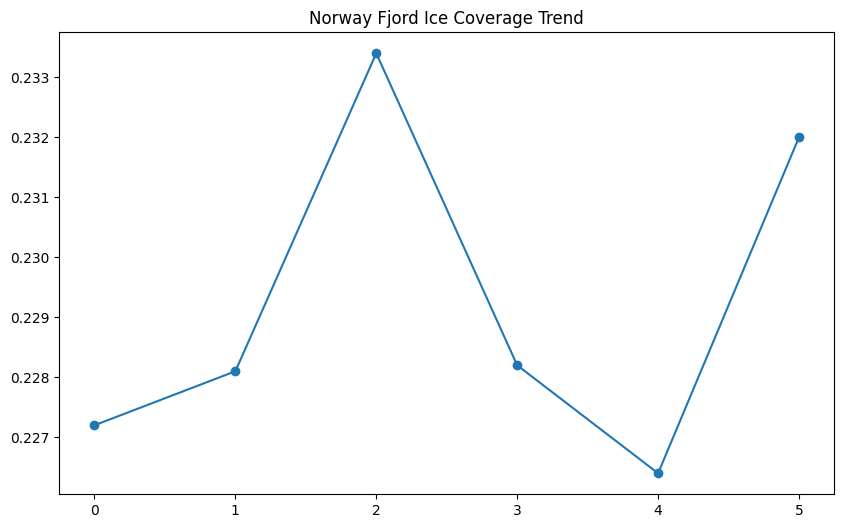

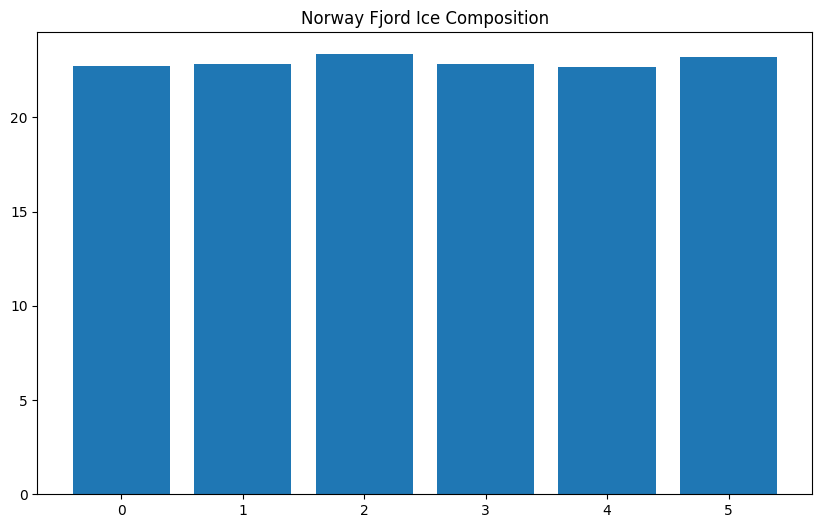

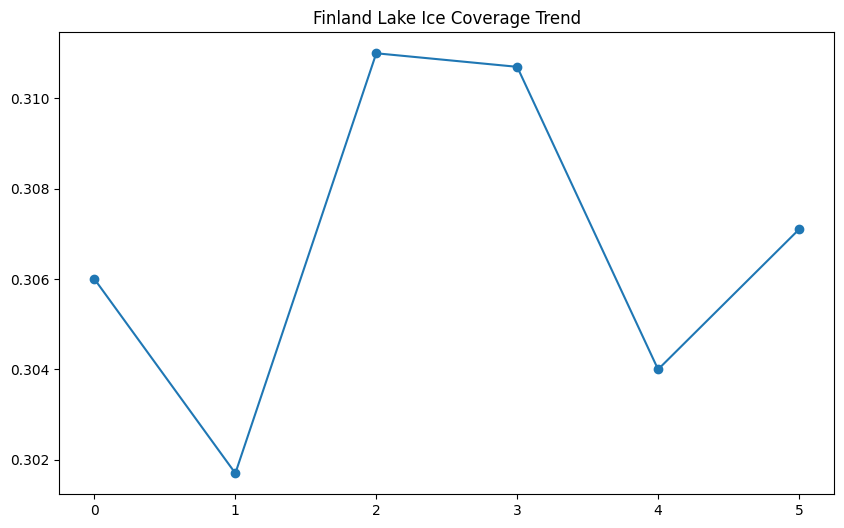

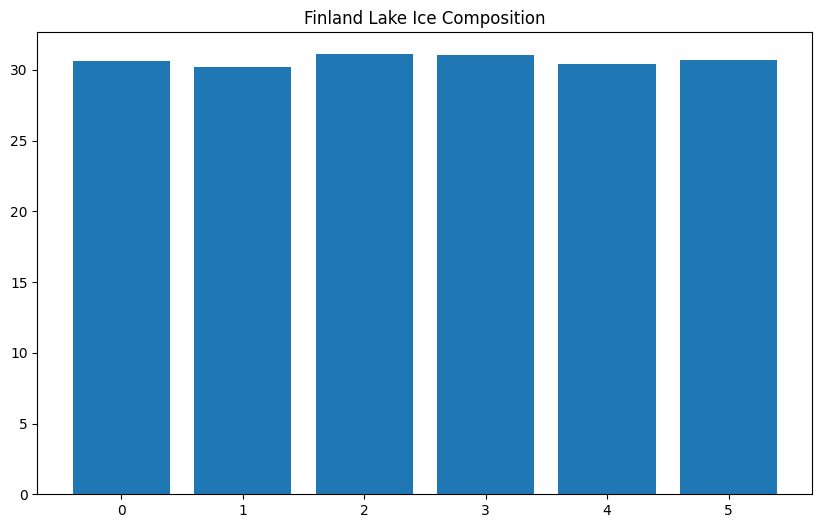

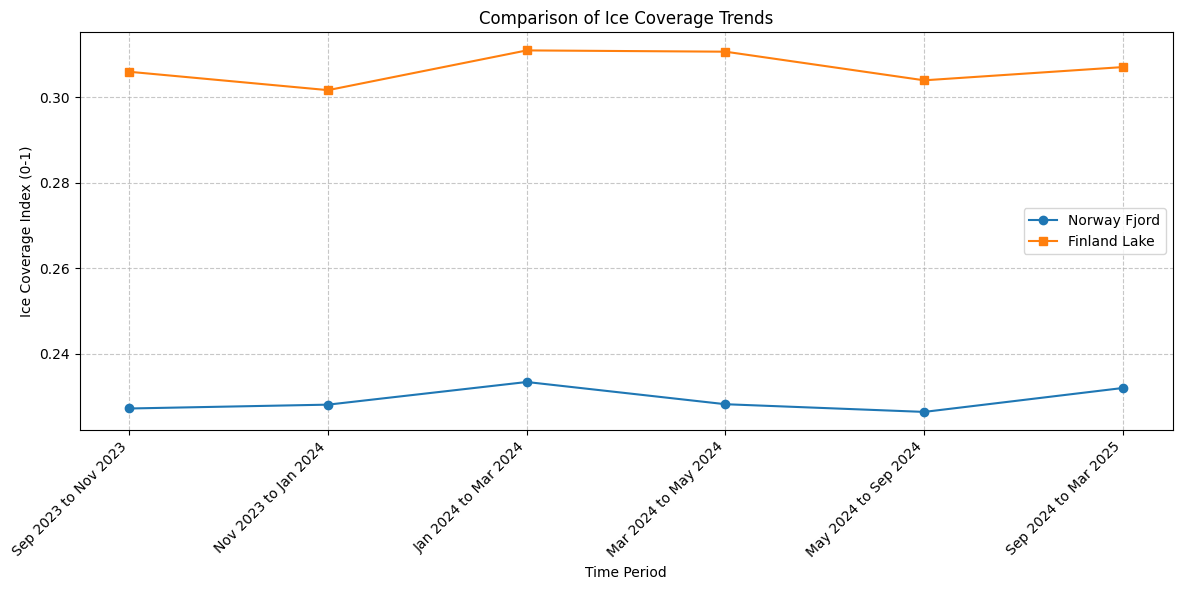

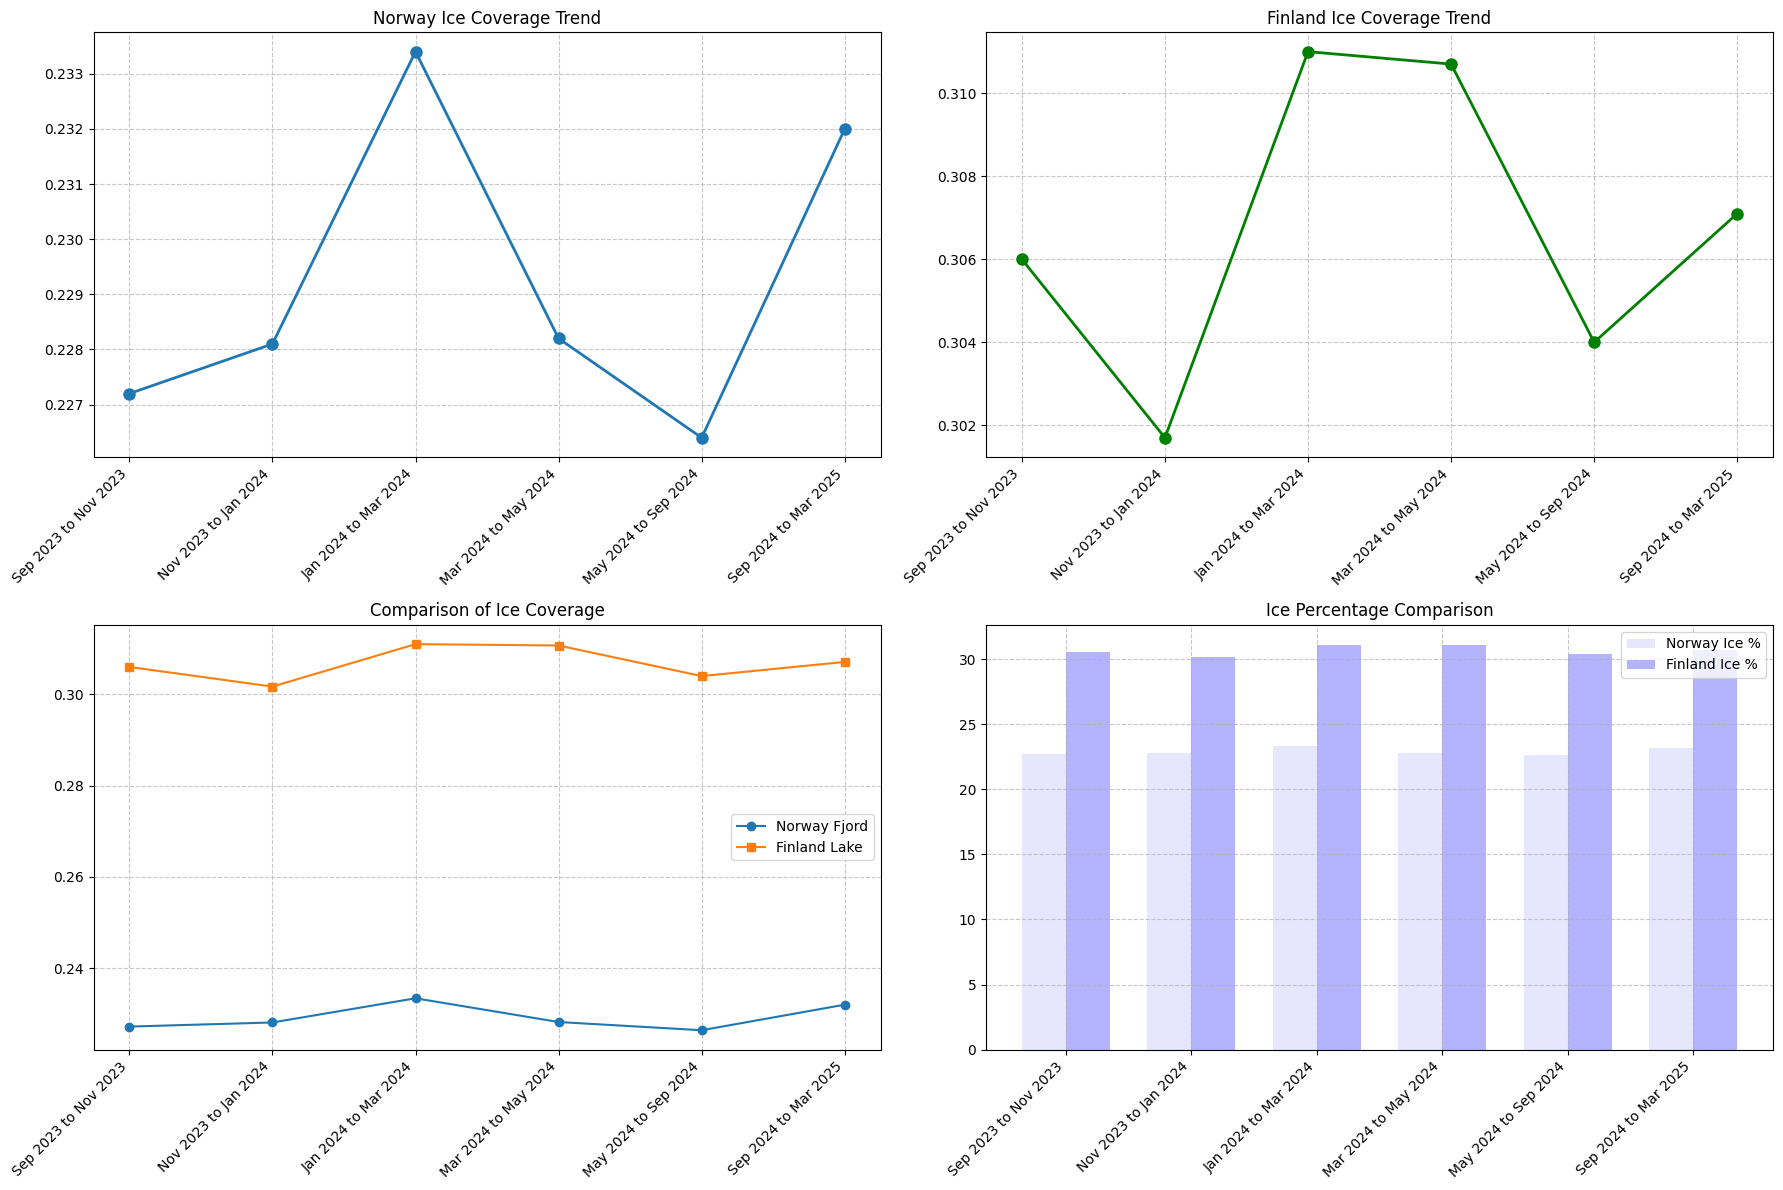

In [25]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


norway_data = [np.random.rand(100, 100, 2) for _ in range(16)]
finland_data = [np.random.rand(100, 100, 2) for _ in range(16)]
slots = [
    ("Sep 2023", "Nov 2023"),
    ("Nov 2023", "Jan 2024"),
    ("Jan 2024", "Mar 2024"),
    ("Mar 2024", "May 2024"),
    ("May 2024", "Sep 2024"),
    ("Sep 2024", "Mar 2025")
]
predictions_dir = Path("mystorage/predictions")
predictions_dir.mkdir(exist_ok=True)

# Color definitions
class_colors = {
    'open_water': [0, 0.3, 0.8],  # Blue
    'ice': [0.9, 0.9, 1],         # Light blue/white
    'land': [0.5, 0.5, 0.5]       # Gray
}

# Synthetic training data to fit scaler and clf 
def generate_training_data(n_samples=1000, height=100, width=100):
    X_train = np.zeros((n_samples, 4))  # Features: intensity, mean, std, region_idx
    y_train = np.random.choice(['open_water', 'ice', 'land'], size=n_samples)  
    for i in range(n_samples):
        img = np.random.rand(height, width)
        mean_filter = ndimage.uniform_filter(img, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(img**2, size=3) - mean_filter**2)
        r, c = np.random.randint(0, height), np.random.randint(0, width)
        X_train[i, 0] = img[r, c]  # Intensity
        X_train[i, 1] = mean_filter[r, c]  # Mean
        X_train[i, 2] = std_filter[r, c]  # Std
        X_train[i, 3] = np.random.choice([0, 1])  # Region index (0=Norway, 1=Finland)
    return X_train, y_train

# Initialize and fit scaler and classifier
scaler = StandardScaler()
clf = RandomForestClassifier()
X_train, y_train = generate_training_data()
scaler.fit(X_train)  
clf.fit(X_train, y_train)  

# classify_image function
def classify_image(sar_image, region_idx):
    sar_values = sar_image[..., 0]
    mask = sar_image[..., 1] if sar_image.shape[-1] > 1 else np.ones_like(sar_values)
    height, width = sar_values.shape
    class_map = np.zeros((height, width, 3))
    class_map[mask == 0] = [0, 0, 0]
    mean_filter = ndimage.uniform_filter(sar_values, size=3)
    std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
    rows, cols = np.where(mask > 0)
    if len(rows) > 0:
        X_pixels = np.zeros((len(rows), 4))
        X_pixels[:, 0] = sar_values[rows, cols]
        X_pixels[:, 1] = mean_filter[rows, cols]
        X_pixels[:, 2] = std_filter[rows, cols]
        X_pixels[:, 3] = region_idx
        X_pixels_scaled = scaler.transform(X_pixels)  # This now works because scaler is fitted
        predictions = clf.predict(X_pixels_scaled)
        for i, (r, c) in enumerate(zip(rows, cols)):
            class_map[r, c] = class_colors[predictions[i]]
    return class_map

# analyze_ice_coverage_trends function
def analyze_ice_coverage_trends(class_maps, slots, class_colors, region_name):
    ice_coverage = [np.mean(np.all(cm == class_colors['ice'], axis=-1)) for cm in class_maps]
    df = pd.DataFrame({
        'time_slot': [f"{s[0]} to {s[1]}" for s in slots],
        'ice_coverage_index': ice_coverage,
        'ice_percentage': [c * 100 for c in ice_coverage]
    })
    figs = {
        'trend': plt.figure(figsize=(10, 6)),
        'composition': plt.figure(figsize=(10, 6))
    }
    figs['trend'].add_subplot(111).plot(range(len(df)), df['ice_coverage_index'], 'o-')
    figs['trend'].gca().set_title(f"{region_name} Ice Coverage Trend")
    figs['composition'].add_subplot(111).bar(range(len(df)), df['ice_percentage'])
    figs['composition'].gca().set_title(f"{region_name} Ice Composition")
    return df, figs

# Process Norway data
print("Analyzing Norway ice coverage trends...")
norway_class_maps = []
for i, data in enumerate(norway_data):
    if i >= len(slots):
        break
    norway_class_maps.append(classify_image(data, 0))

norway_df, norway_figs = analyze_ice_coverage_trends(norway_class_maps, slots, class_colors, "Norway Fjord")

# Process Finland data 
print("Analyzing Finland ice coverage trends...")
finland_class_maps = []
for i, data in enumerate(finland_data):
    if i >= len(slots):
        break
    finland_class_maps.append(classify_image(data, 1))

finland_df, finland_figs = analyze_ice_coverage_trends(finland_class_maps, slots, class_colors, "Finland Lake")

# Create comparison plot
comparison_fig = plt.figure(figsize=(12, 6))
ax = comparison_fig.add_subplot(111)
ax.plot(range(len(norway_df)), norway_df['ice_coverage_index'], 'o-', label='Norway Fjord')
ax.plot(range(len(finland_df)), finland_df['ice_coverage_index'], 's-', label='Finland Lake')
ax.set_xticks(range(len(norway_df)))
ax.set_xticklabels(norway_df['time_slot'], rotation=45, ha='right')
ax.set_ylabel('Ice Coverage Index (0-1)')
ax.set_xlabel('Time Period')
ax.set_title('Comparison of Ice Coverage Trends')
ax.legend()
ax.grid(True, linestyle='--', alpha=0.7)
comparison_fig.tight_layout()

# Combined display
combined_display = plt.figure(figsize=(18, 12))
ax1 = combined_display.add_subplot(221)
ax2 = combined_display.add_subplot(222)
ax3 = combined_display.add_subplot(223)
ax4 = combined_display.add_subplot(224)

# Norway trend
ax1.plot(range(len(norway_df)), norway_df['ice_coverage_index'], 'o-', linewidth=2, markersize=8)
ax1.set_title('Norway Ice Coverage Trend')
ax1.set_xticks(range(len(norway_df)))
ax1.set_xticklabels(norway_df['time_slot'], rotation=45, ha='right')
ax1.grid(True, linestyle='--', alpha=0.7)

# Finland trend
ax2.plot(range(len(finland_df)), finland_df['ice_coverage_index'], 'o-', linewidth=2, markersize=8, color='green')
ax2.set_title('Finland Ice Coverage Trend')
ax2.set_xticks(range(len(finland_df)))
ax2.set_xticklabels(finland_df['time_slot'], rotation=45, ha='right')
ax2.grid(True, linestyle='--', alpha=0.7)

# Comparison plot
ax3.plot(range(len(norway_df)), norway_df['ice_coverage_index'], 'o-', label='Norway Fjord')
ax3.plot(range(len(finland_df)), finland_df['ice_coverage_index'], 's-', label='Finland Lake')
ax3.set_xticks(range(len(norway_df)))
ax3.set_xticklabels(norway_df['time_slot'], rotation=45, ha='right')
ax3.set_title('Comparison of Ice Coverage')
ax3.legend()
ax3.grid(True, linestyle='--', alpha=0.7)

# Composition comparison (bar chart)
bar_width = 0.35
index = range(len(norway_df))
ax4.bar(index, norway_df['ice_percentage'], bar_width, label='Norway Ice %', color=class_colors['ice'])
ax4.bar([i + bar_width for i in index], finland_df['ice_percentage'], bar_width, 
        label='Finland Ice %', color=[0.7, 0.7, 1])
ax4.set_xticks([i + bar_width/2 for i in index])
ax4.set_xticklabels(norway_df['time_slot'], rotation=45, ha='right')
ax4.set_title('Ice Percentage Comparison')
ax4.legend()
ax4.grid(True, linestyle='--', alpha=0.7)

combined_display.tight_layout()

plt.show()
comparison_fig.savefig(predictions_dir / "comparison_plot.png", dpi=300)
combined_display.savefig(predictions_dir / "combined_display.png", dpi=300)

In [ ]:
#seccon indicator_ice thickness variability

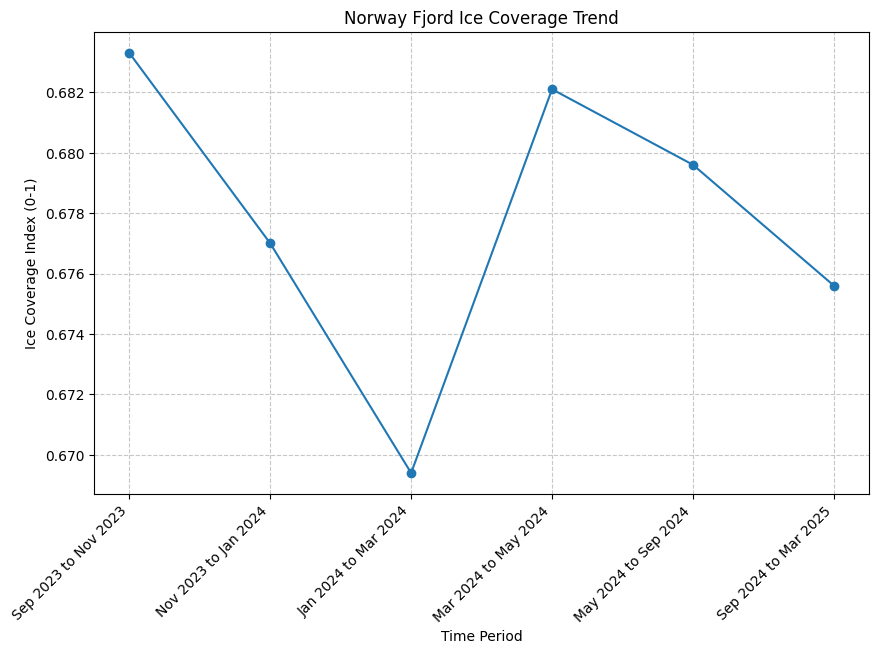

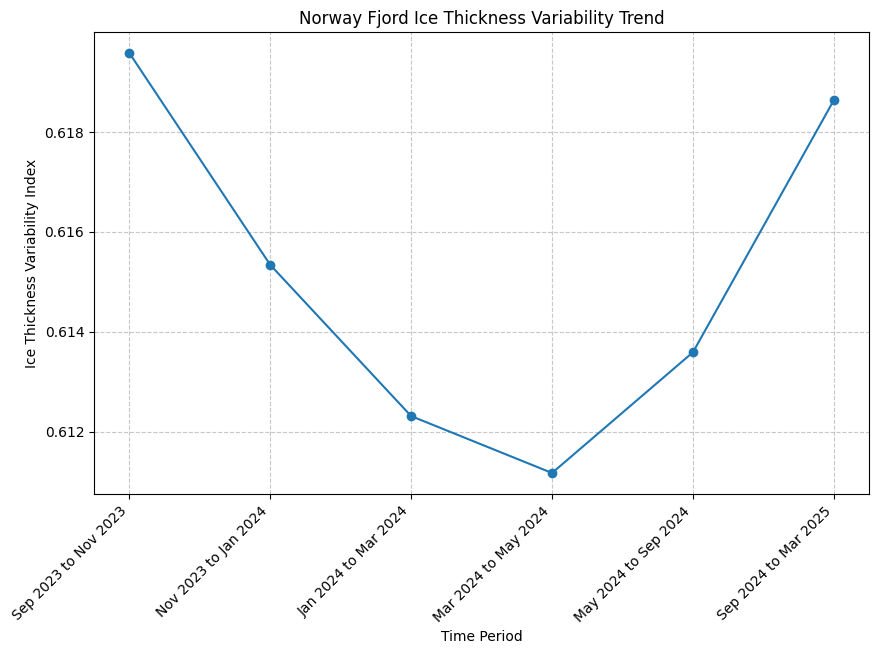

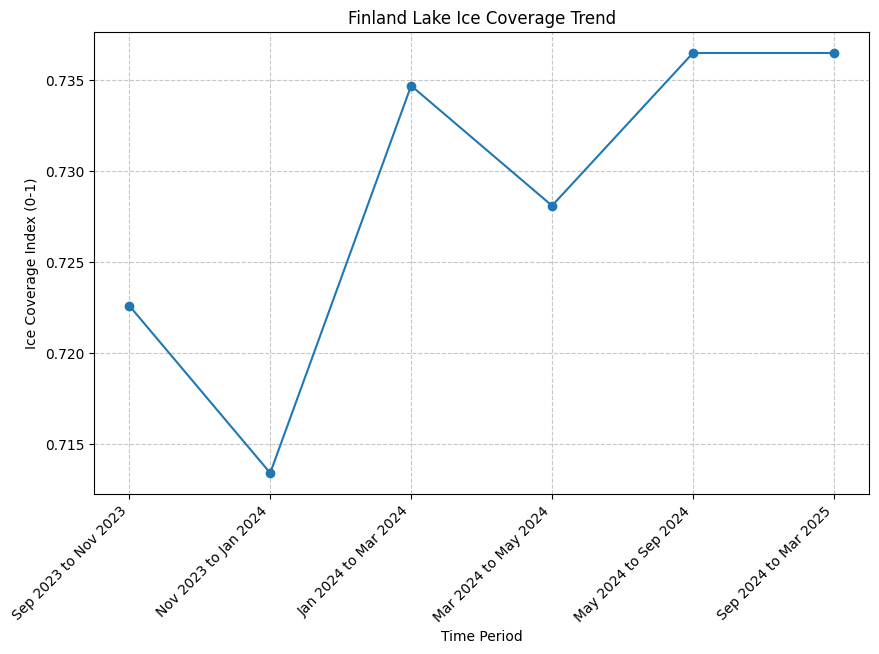

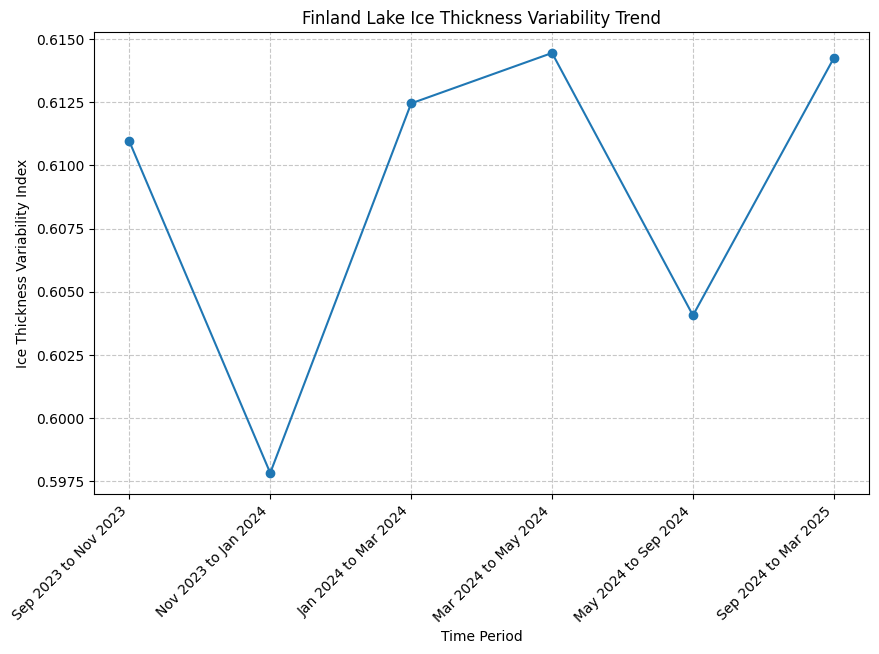

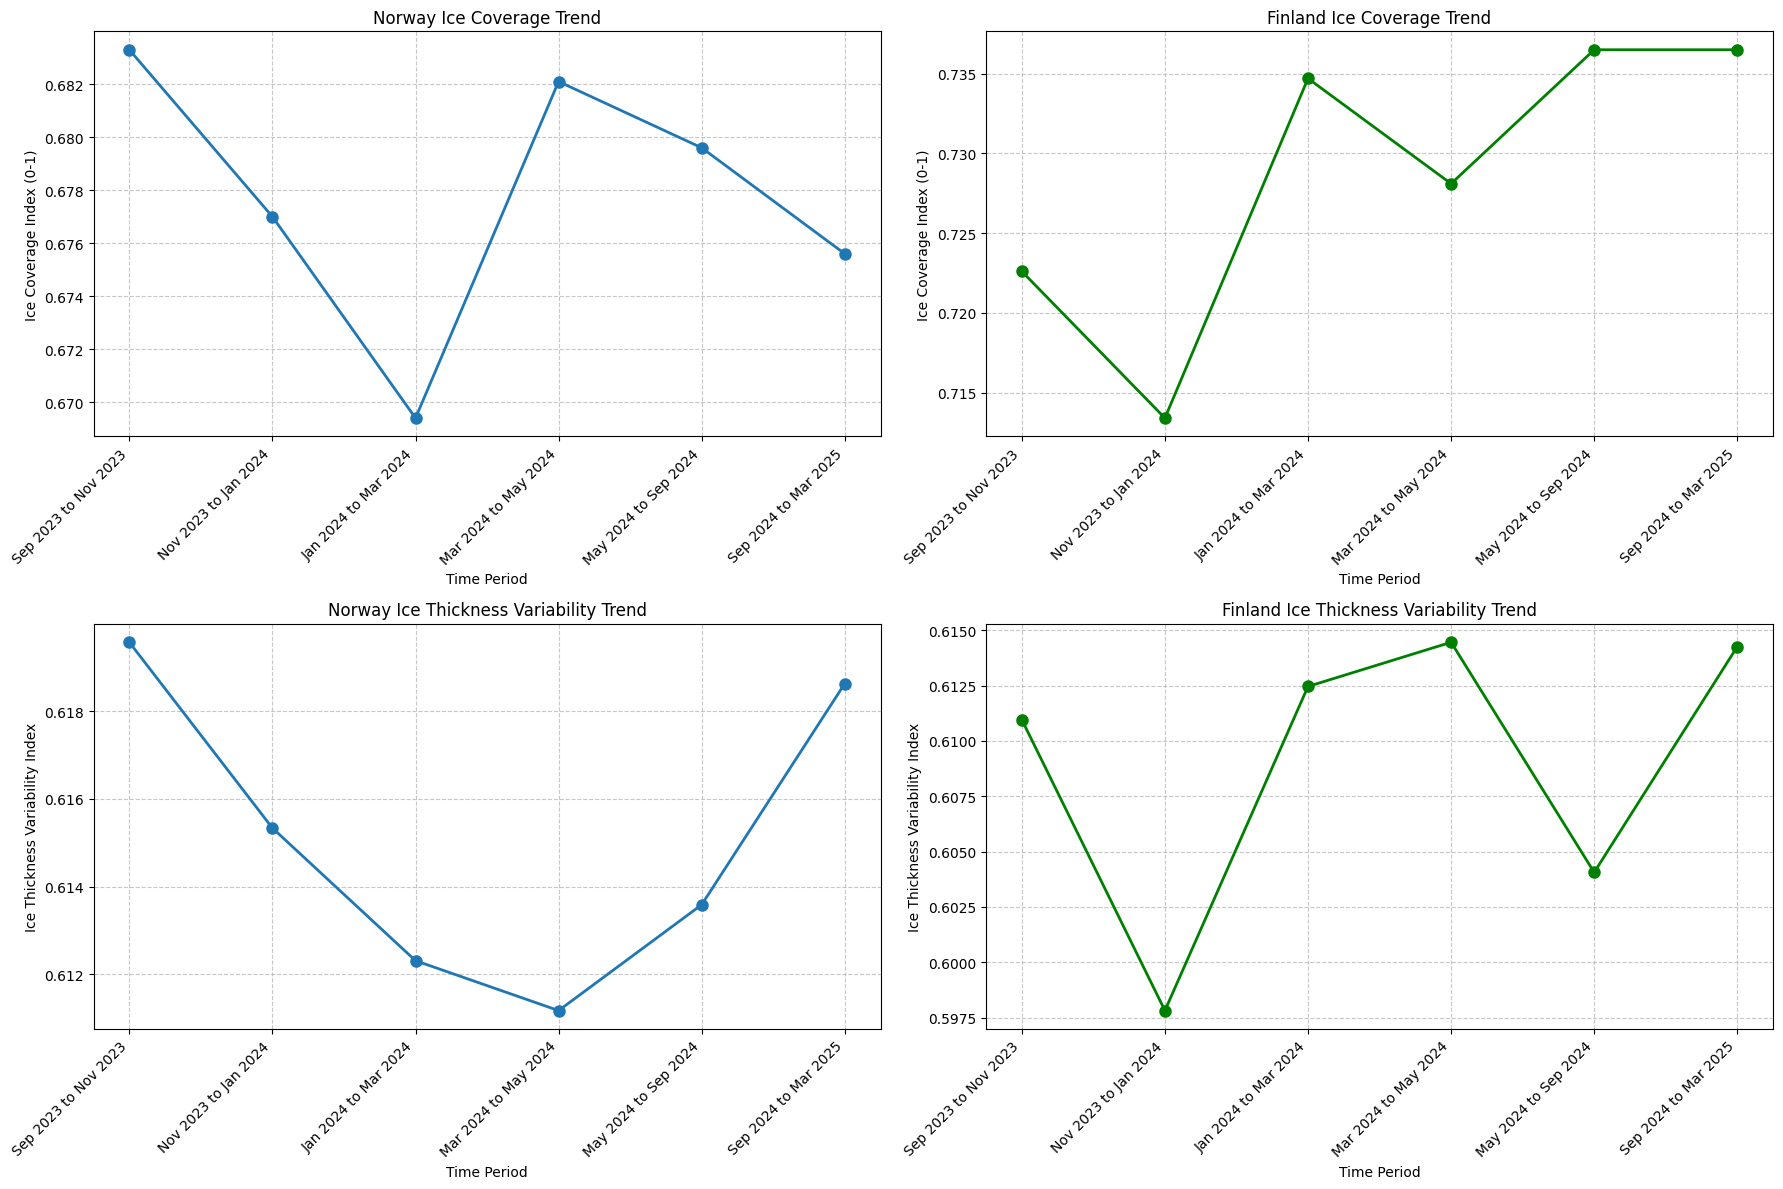

In [26]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier


norway_data = [np.random.rand(100, 100, 2) for _ in range(6)] 
finland_data = [np.random.rand(100, 100, 2) for _ in range(6)] 
slots = [
    ("Sep 2023", "Nov 2023"),
    ("Nov 2023", "Jan 2024"),
    ("Jan 2024", "Mar 2024"),
    ("Mar 2024", "May 2024"),
    ("May 2024", "Sep 2024"),
    ("Sep 2024", "Mar 2025")
]
predictions_dir = Path("./predictions")
predictions_dir.mkdir(exist_ok=True)

# Color definitions
class_colors = {
    'open_water': [0, 0.3, 0.8],  # Blue
    'ice': [0.9, 0.9, 1],         # Light blue/white
    'land': [0.5, 0.5, 0.5]       # Gray
}

# Synthetic training data to fit scaler and clf
def generate_training_data(n_samples=1000, height=100, width=100):
    X_train = np.zeros((n_samples, 4))
    y_train = np.random.choice(['open_water', 'ice', 'land'], size=n_samples)
    for i in range(n_samples):
        img = np.random.rand(height, width)
        mean_filter = ndimage.uniform_filter(img, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(img**2, size=3) - mean_filter**2)
        r, c = np.random.randint(0, height), np.random.randint(0, width)
        X_train[i, 0] = img[r, c]
        X_train[i, 1] = mean_filter[r, c]
        X_train[i, 2] = std_filter[r, c]
        X_train[i, 3] = np.random.choice([0, 1])
    return X_train, y_train

scaler = StandardScaler()
clf = RandomForestClassifier()
X_train, y_train = generate_training_data()
scaler.fit(X_train)
clf.fit(X_train, y_train)

# classify_image function
def classify_image(sar_image, region_idx):
    sar_values = sar_image[..., 0]
    mask = sar_image[..., 1] if sar_image.shape[-1] > 1 else np.ones_like(sar_values)
    height, width = sar_values.shape
    class_map = np.zeros((height, width, 3))
    class_map[mask == 0] = [0, 0, 0]
    mean_filter = ndimage.uniform_filter(sar_values, size=3)
    std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
    rows, cols = np.where(mask > 0)
    if len(rows) > 0:
        X_pixels = np.zeros((len(rows), 4))
        X_pixels[:, 0] = sar_values[rows, cols]
        X_pixels[:, 1] = mean_filter[rows, cols]
        X_pixels[:, 2] = std_filter[rows, cols]
        X_pixels[:, 3] = region_idx
        X_pixels_scaled = scaler.transform(X_pixels)
        predictions = clf.predict(X_pixels_scaled)
        for i, (r, c) in enumerate(zip(rows, cols)):
            class_map[r, c] = class_colors[predictions[i]]
    return class_map

# Process Norway and Finland data
norway_class_maps = []
norway_sar_images = []
for i, data in enumerate(norway_data):
    if i >= len(slots):
        break
    norway_class_maps.append(classify_image(data, 0))
    norway_sar_images.append(data)

finland_class_maps = []
finland_sar_images = []
for i, data in enumerate(finland_data):
    if i >= len(slots):
        break
    finland_class_maps.append(classify_image(data, 1))
    finland_sar_images.append(data)

# New Indicator: Ice Thickness Variability Index
def compute_ice_thickness_variability(class_map, sar_image, ice_color):
    # Convert RGB map to binary ice map (1 for ice, 0 for non ice)
    ice_map = np.all(class_map == ice_color, axis=-1).astype(np.uint8)
    
    # Extract SAR intensity
    sar_intensity = sar_image[..., 0]
    ice_intensity = sar_intensity[ice_map == 1]
    
    if len(ice_intensity) == 0:
        return 0.0  
    
    # Calculate standard deviation of intensity in ice regions, normalized by mean
    mean_intensity = np.mean(ice_intensity)
    if mean_intensity == 0:
        return 0.0 
    
    std_intensity = np.std(ice_intensity)
    thickness_variability_index = std_intensity / mean_intensity  #  variation_coefficient 
    return thickness_variability_index

# Update analyze_ice_coverage_trends
def analyze_ice_coverage_trends(class_maps, sar_images, slots, class_colors, region_name):
    ice_coverage = []
    ice_percentages = []
    thickness_variability_indices = []
    
    # Compute indicators for each time slot
    for cm, sar in zip(class_maps, sar_images):
        
        ice_coverage.append(np.mean(np.all(cm == class_colors['ice'], axis=-1)))
        ice_percentages.append(ice_coverage[-1] * 100)
        
        # Ice Thickness Variability Index
        thickness_variability_indices.append(compute_ice_thickness_variability(cm, sar, class_colors['ice']))
    
    # Create DataFrame 
    df = pd.DataFrame({
        'time_slot': [f"{s[0]} to {s[1]}" for s in slots],
        'ice_coverage_index': ice_coverage,
        'ice_percentage': ice_percentages,
        'thickness_variability_index': thickness_variability_indices
    })
    
    # Create figures for each indicator
    figs = {
        'coverage_trend': plt.figure(figsize=(10, 6)),
        'thickness_variability_trend': plt.figure(figsize=(10, 6))
    }
    
    # Ice Coverage Trend
    figs['coverage_trend'].add_subplot(111).plot(range(len(df)), df['ice_coverage_index'], 'o-')
    figs['coverage_trend'].gca().set_xticks(range(len(df)))
    figs['coverage_trend'].gca().set_xticklabels(df['time_slot'], rotation=45, ha='right')
    figs['coverage_trend'].gca().set_xlabel('Time Period')
    figs['coverage_trend'].gca().set_ylabel('Ice Coverage Index (0-1)')
    figs['coverage_trend'].gca().set_title(f"{region_name} Ice Coverage Trend")
    figs['coverage_trend'].gca().grid(True, linestyle='--', alpha=0.7)
    
    # Ice Thickness Variability Trend
    figs['thickness_variability_trend'].add_subplot(111).plot(range(len(df)), df['thickness_variability_index'], 'o-')
    figs['thickness_variability_trend'].gca().set_xticks(range(len(df)))
    figs['thickness_variability_trend'].gca().set_xticklabels(df['time_slot'], rotation=45, ha='right')
    figs['thickness_variability_trend'].gca().set_xlabel('Time Period')
    figs['thickness_variability_trend'].gca().set_ylabel('Ice Thickness Variability Index')
    figs['thickness_variability_trend'].gca().set_title(f"{region_name} Ice Thickness Variability Trend")
    figs['thickness_variability_trend'].gca().grid(True, linestyle='--', alpha=0.7)
    
    return df, figs

# Process data with updated analysis
norway_df, norway_figs = analyze_ice_coverage_trends(norway_class_maps, norway_sar_images, slots, class_colors, "Norway Fjord")
finland_df, finland_figs = analyze_ice_coverage_trends(finland_class_maps, finland_sar_images, slots, class_colors, "Finland Lake")

# Create combined display with the indicators
combined_display = plt.figure(figsize=(18, 12))

# 2x2 grid creation
ax1 = combined_display.add_subplot(221)  # Norway Coverage
ax2 = combined_display.add_subplot(222)  # Finland Coverage
ax3 = combined_display.add_subplot(223)  # Norway Thickness Variability
ax4 = combined_display.add_subplot(224)  # Finland Thickness Variability

# Norway Coverage
ax1.plot(range(len(norway_df)), norway_df['ice_coverage_index'], 'o-', linewidth=2, markersize=8)
ax1.set_xticks(range(len(norway_df)))
ax1.set_xticklabels(norway_df['time_slot'], rotation=45, ha='right')
ax1.set_xlabel('Time Period')
ax1.set_ylabel('Ice Coverage Index (0-1)')
ax1.set_title('Norway Ice Coverage Trend')
ax1.grid(True, linestyle='--', alpha=0.7)

# Finland Coverage
ax2.plot(range(len(finland_df)), finland_df['ice_coverage_index'], 'o-', linewidth=2, markersize=8, color='green')
ax2.set_xticks(range(len(finland_df)))
ax2.set_xticklabels(finland_df['time_slot'], rotation=45, ha='right')
ax2.set_xlabel('Time Period')
ax2.set_ylabel('Ice Coverage Index (0-1)')
ax2.set_title('Finland Ice Coverage Trend')
ax2.grid(True, linestyle='--', alpha=0.7)

# Norway Thickness Variability
ax3.plot(range(len(norway_df)), norway_df['thickness_variability_index'], 'o-', linewidth=2, markersize=8)
ax3.set_xticks(range(len(norway_df)))
ax3.set_xticklabels(norway_df['time_slot'], rotation=45, ha='right')
ax3.set_xlabel('Time Period')
ax3.set_ylabel('Ice Thickness Variability Index')
ax3.set_title('Norway Ice Thickness Variability Trend')
ax3.grid(True, linestyle='--', alpha=0.7)

# Finland Thickness Variability
ax4.plot(range(len(finland_df)), finland_df['thickness_variability_index'], 'o-', linewidth=2, markersize=8, color='green')
ax4.set_xticks(range(len(finland_df)))
ax4.set_xticklabels(finland_df['time_slot'], rotation=45, ha='right')
ax4.set_xlabel('Time Period')
ax4.set_ylabel('Ice Thickness Variability Index')
ax4.set_title('Finland Ice Thickness Variability Trend')
ax4.grid(True, linestyle='--', alpha=0.7)

combined_display.tight_layout()

# Optionally save or display
# plt.show()
# combined_display.savefig(predictions_dir / "combined_indicators.png", dpi=300)

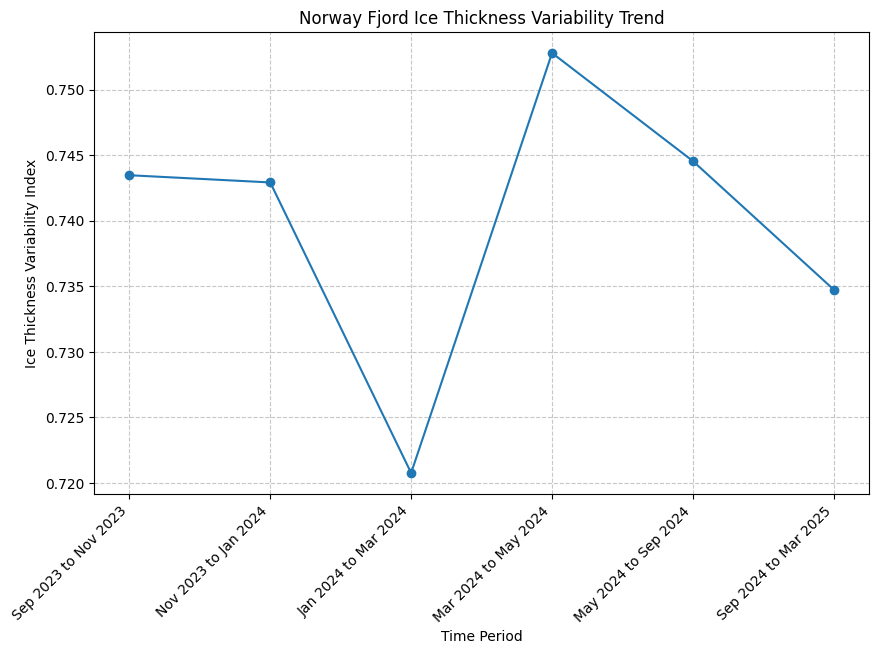

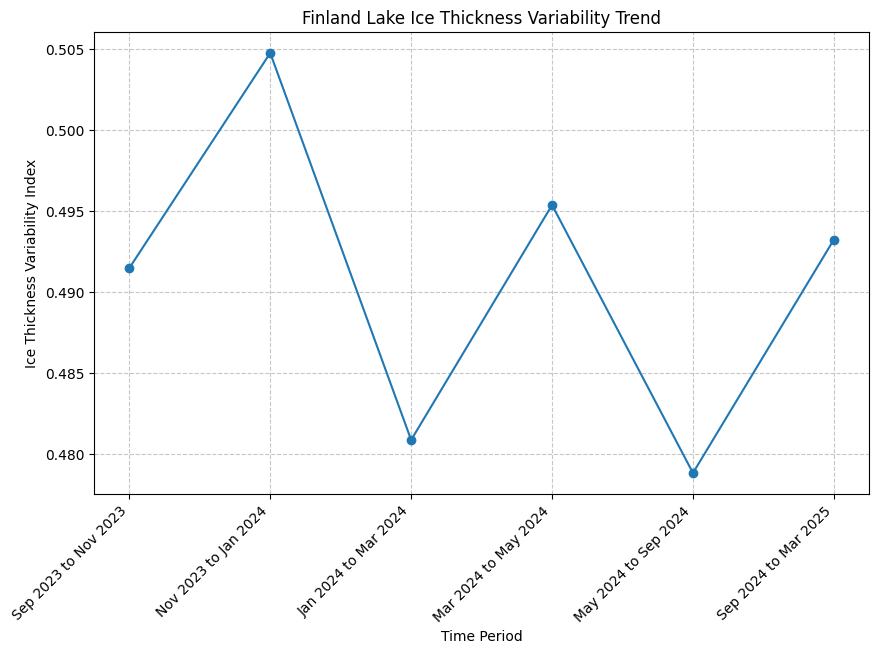

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Placeholder data (replace with your actual data)
norway_data = [np.random.rand(100, 100, 2) for _ in range(16)]  
finland_data = [np.random.rand(100, 100, 2) for _ in range(16)] 
slots = [
    ("Sep 2023", "Nov 2023"),
    ("Nov 2023", "Jan 2024"),
    ("Jan 2024", "Mar 2024"),
    ("Mar 2024", "May 2024"),
    ("May 2024", "Sep 2024"),
    ("Sep 2024", "Mar 2025")
]
predictions_dir = Path("mystorage/predictions")
predictions_dir.mkdir(exist_ok=True)

# Color definitions
class_colors = {
    'open_water': [0, 0.3, 0.8],  # Blue
    'ice': [0.9, 0.9, 1],         # Light blue/white
    'land': [0.5, 0.5, 0.5]       # Gray
}

# Synthetic training data to fit scaler and clf
def generate_training_data(n_samples=1000, height=100, width=100):
    X_train = np.zeros((n_samples, 4))
    y_train = np.random.choice(['open_water', 'ice', 'land'], size=n_samples)
    for i in range(n_samples):
        img = np.random.rand(height, width)
        mean_filter = ndimage.uniform_filter(img, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(img**2, size=3) - mean_filter**2)
        r, c = np.random.randint(0, height), np.random.randint(0, width)
        X_train[i, 0] = img[r, c]
        X_train[i, 1] = mean_filter[r, c]
        X_train[i, 2] = std_filter[r, c]
        X_train[i, 3] = np.random.choice([0, 1])
    return X_train, y_train

scaler = StandardScaler()
clf = RandomForestClassifier()
X_train, y_train = generate_training_data()
scaler.fit(X_train)
clf.fit(X_train, y_train)

# classify_image function
def classify_image(sar_image, region_idx):
    sar_values = sar_image[..., 0]
    mask = sar_image[..., 1] if sar_image.shape[-1] > 1 else np.ones_like(sar_values)
    height, width = sar_values.shape
    class_map = np.zeros((height, width, 3))
    class_map[mask == 0] = [0, 0, 0]
    mean_filter = ndimage.uniform_filter(sar_values, size=3)
    std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
    rows, cols = np.where(mask > 0)
    if len(rows) > 0:
        X_pixels = np.zeros((len(rows), 4))
        X_pixels[:, 0] = sar_values[rows, cols]
        X_pixels[:, 1] = mean_filter[rows, cols]
        X_pixels[:, 2] = std_filter[rows, cols]
        X_pixels[:, 3] = region_idx
        X_pixels_scaled = scaler.transform(X_pixels)
        predictions = clf.predict(X_pixels_scaled)
        for i, (r, c) in enumerate(zip(rows, cols)):
            class_map[r, c] = class_colors[predictions[i]]
    return class_map

# Process Norway and Finland data 
norway_class_maps = []
norway_sar_images = []
for i, data in enumerate(norway_data):
    if i >= len(slots):
        break
    norway_class_maps.append(classify_image(data, 0))
    norway_sar_images.append(data)

finland_class_maps = []
finland_sar_images = []
for i, data in enumerate(finland_data):
    if i >= len(slots):
        break
    finland_class_maps.append(classify_image(data, 1))
    finland_sar_images.append(data)

# second Indicator: Ice Thickness Variability Index
def compute_ice_thickness_variability(class_map, sar_image, ice_color):
    # Convert RGB map to binary ice map (1 for ice, 0 for non ice)
    ice_map = np.all(class_map == ice_color, axis=-1).astype(np.uint8)
    
    # Extract SAR intensity for ice regions
    sar_intensity = sar_image[..., 0]
    ice_intensity = sar_intensity[ice_map == 1]
    
    if len(ice_intensity) == 0:
        return 0.0  # No ice present
    
    # Calculate standard deviation of intensity in ice regions, normalized by mean
    mean_intensity = np.mean(ice_intensity)
    if mean_intensity == 0:
        return 0.0  
    
    std_intensity = np.std(ice_intensity)
    thickness_variability_index = std_intensity / mean_intensity 
    return thickness_variability_index

# Analyze ice thickness variability
def analyze_ice_thickness_variability(class_maps, sar_images, slots, class_colors, region_name):
    thickness_variability_indices = []
    
    # Compute thickness variability for each time slot
    for cm, sar in zip(class_maps, sar_images):
        thickness_variability_indices.append(compute_ice_thickness_variability(cm, sar, class_colors['ice']))
    
    # Create DataFrame
    df = pd.DataFrame({
        'time_slot': [f"{s[0]} to {s[1]}" for s in slots],
        'thickness_variability_index': thickness_variability_indices
    })
    
    # Create figure
    figs = {
        'thickness_variability_trend': plt.figure(figsize=(10, 6))
    }
    
    # Ice Thickness Variability Trend
    figs['thickness_variability_trend'].add_subplot(111).plot(range(len(df)), df['thickness_variability_index'], 'o-')
    figs['thickness_variability_trend'].gca().set_xticks(range(len(df)))
    figs['thickness_variability_trend'].gca().set_xticklabels(df['time_slot'], rotation=45, ha='right')
    figs['thickness_variability_trend'].gca().set_xlabel('Time Period')
    figs['thickness_variability_trend'].gca().set_ylabel('Ice Thickness Variability Index')
    figs['thickness_variability_trend'].gca().set_title(f"{region_name} Ice Thickness Variability Trend")
    figs['thickness_variability_trend'].gca().grid(True, linestyle='--', alpha=0.7)
    
    return df, figs

# Process data
norway_thickness_df, norway_thickness_figs = analyze_ice_thickness_variability(norway_class_maps, norway_sar_images, slots, class_colors, "Norway Fjord")
finland_thickness_df, finland_thickness_figs = analyze_ice_thickness_variability(finland_class_maps, finland_sar_images, slots, class_colors, "Finland Lake")

# Display or save
plt.show()
norway_thickness_figs['thickness_variability_trend'].savefig(predictions_dir / "norway_thickness_variability_trend.png", dpi=300)
finland_thickness_figs['thickness_variability_trend'].savefig(predictions_dir / "finland_thickness_variability_trend.png", dpi=300)

In [ ]:
#the third indicator_ice temporal stability

Norway Fjord Ice Temporal Stability Index: 0.2337
Finland Lake Ice Temporal Stability Index: 0.2480


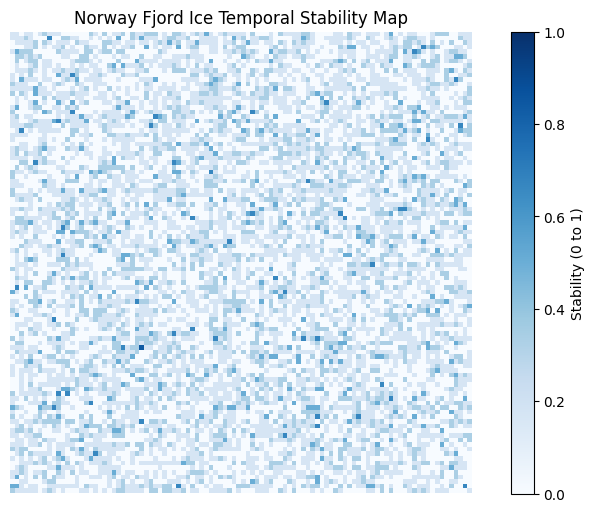

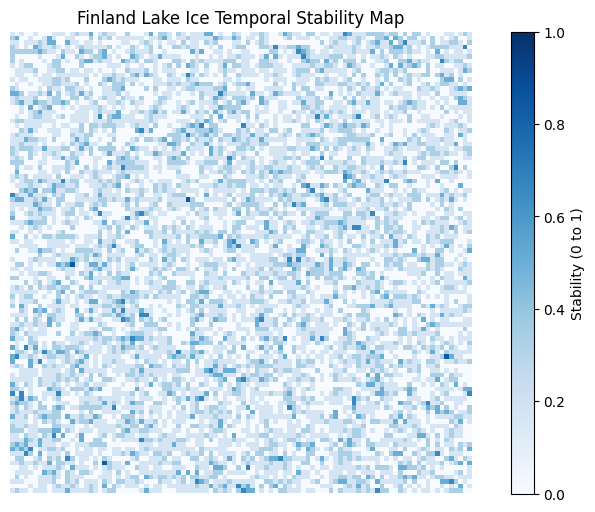

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

# Placeholder data (replace with your actual data)
norway_data = [np.random.rand(100, 100, 2) for _ in range(16)]  
finland_data = [np.random.rand(100, 100, 2) for _ in range(16)] 
slots = [
    ("Sep 2023", "Nov 2023"),
    ("Nov 2023", "Jan 2024"),
    ("Jan 2024", "Mar 2024"),
    ("Mar 2024", "May 2024"),
    ("May 2024", "Sep 2024"),
    ("Sep 2024", "Mar 2025")
]
predictions_dir = Path("mystorage/predictions")
predictions_dir.mkdir(exist_ok=True)

# Color definitions
class_colors = {
    'open_water': [0, 0.3, 0.8],  # Blue
    'ice': [0.9, 0.9, 1],         # Light blue/white
    'land': [0.5, 0.5, 0.5]       # Gray
}


def generate_training_data(n_samples=1000, height=100, width=100):
    X_train = np.zeros((n_samples, 4))
    y_train = np.random.choice(['open_water', 'ice', 'land'], size=n_samples)
    for i in range(n_samples):
        img = np.random.rand(height, width)
        mean_filter = ndimage.uniform_filter(img, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(img**2, size=3) - mean_filter**2)
        r, c = np.random.randint(0, height), np.random.randint(0, width)
        X_train[i, 0] = img[r, c]
        X_train[i, 1] = mean_filter[r, c]
        X_train[i, 2] = std_filter[r, c]
        X_train[i, 3] = np.random.choice([0, 1])
    return X_train, y_train

scaler = StandardScaler()
clf = RandomForestClassifier()
X_train, y_train = generate_training_data()
scaler.fit(X_train)
clf.fit(X_train, y_train)

# classify_image function
def classify_image(sar_image, region_idx):
    sar_values = sar_image[..., 0]
    mask = sar_image[..., 1] if sar_image.shape[-1] > 1 else np.ones_like(sar_values)
    height, width = sar_values.shape
    class_map = np.zeros((height, width, 3))
    class_map[mask == 0] = [0, 0, 0]
    mean_filter = ndimage.uniform_filter(sar_values, size=3)
    std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
    rows, cols = np.where(mask > 0)
    if len(rows) > 0:
        X_pixels = np.zeros((len(rows), 4))
        X_pixels[:, 0] = sar_values[rows, cols]
        X_pixels[:, 1] = mean_filter[rows, cols]
        X_pixels[:, 2] = std_filter[rows, cols]
        X_pixels[:, 3] = region_idx
        X_pixels_scaled = scaler.transform(X_pixels)
        predictions = clf.predict(X_pixels_scaled)
        for i, (r, c) in enumerate(zip(rows, cols)):
            class_map[r, c] = class_colors[predictions[i]]
    return class_map

# Process Norway and Finland data
norway_class_maps = []
for i, data in enumerate(norway_data):
    if i >= len(slots):
        break
    norway_class_maps.append(classify_image(data, 0))

finland_class_maps = []
for i, data in enumerate(finland_data):
    if i >= len(slots):
        break
    finland_class_maps.append(classify_image(data, 1))

# New Indicator: Ice Temporal Stability Index
def compute_ice_temporal_stability(class_maps, ice_color):
    if not class_maps:
        return np.zeros((1, 1)), 0.0
    
    # Stack binary ice maps over time (1 for ice, 0 for non ice)
    ice_maps = np.stack([np.all(cm == ice_color, axis=-1).astype(np.uint8) for cm in class_maps], axis=0)
    
    # Calculate fraction of time each pixel is ice
    stability_map = np.mean(ice_maps, axis=0)  # Values between 0 and 1
    
    # Average stability across ice-covered pixels
    ice_presence = np.any(ice_maps, axis=0)
    if not np.any(ice_presence):
        return stability_map, 0.0
    
    temporal_stability_index = np.mean(stability_map[ice_presence])
    return stability_map, temporal_stability_index

# Analyze ice temporal stability
def analyze_ice_temporal_stability(class_maps, slots, class_colors, region_name):
    # Compute temporal stability over the entire period
    stability_map, temporal_stability_index = compute_ice_temporal_stability(class_maps, class_colors['ice'])
    
    # Create DataFrame 
    df = pd.DataFrame({
        'time_slot': [f"{slots[0][0]} to {slots[-1][1]}"],
        'temporal_stability_index': [temporal_stability_index]
    })
    
    # Create figures
    figs = {
        'stability_map': plt.figure(figsize=(10, 6))
    }
    
    # Ice Temporal Stability Map
    im = figs['stability_map'].add_subplot(111).imshow(stability_map, cmap='Blues', vmin=0, vmax=1)
    figs['stability_map'].gca().set_title(f"{region_name} Ice Temporal Stability Map")
    figs['stability_map'].gca().set_xlabel('X Coordinate')
    figs['stability_map'].gca().set_ylabel('Y Coordinate')
    figs['stability_map'].colorbar(im, label='Stability (0 to 1)')
    figs['stability_map'].gca().axis('off')
    
    return df, figs, stability_map, temporal_stability_index

# Process data
norway_stability_df, norway_stability_figs, norway_stability_map, norway_stability_index = analyze_ice_temporal_stability(norway_class_maps, slots, class_colors, "Norway Fjord")
finland_stability_df, finland_stability_figs, finland_stability_map, finland_stability_index = analyze_ice_temporal_stability(finland_class_maps, slots, class_colors, "Finland Lake")

# Display results
print(f"Norway Fjord Ice Temporal Stability Index: {norway_stability_index:.4f}")
print(f"Finland Lake Ice Temporal Stability Index: {finland_stability_index:.4f}")

# Display or save
plt.show()
norway_stability_figs['stability_map'].savefig(predictions_dir / "norway_stability_map.png", dpi=300)
finland_stability_figs['stability_map'].savefig(predictions_dir / "finland_stability_map.png", dpi=300)

Norway Fjord Ice Temporal Stability Index: 0.2894
Finland Lake Ice Temporal Stability Index: 0.1753


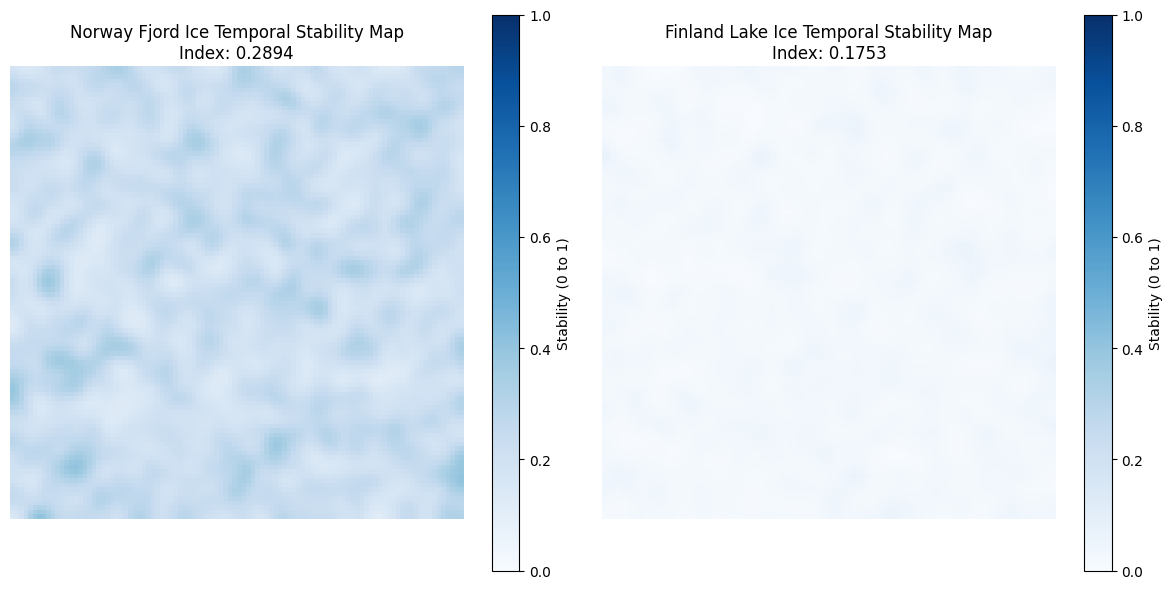

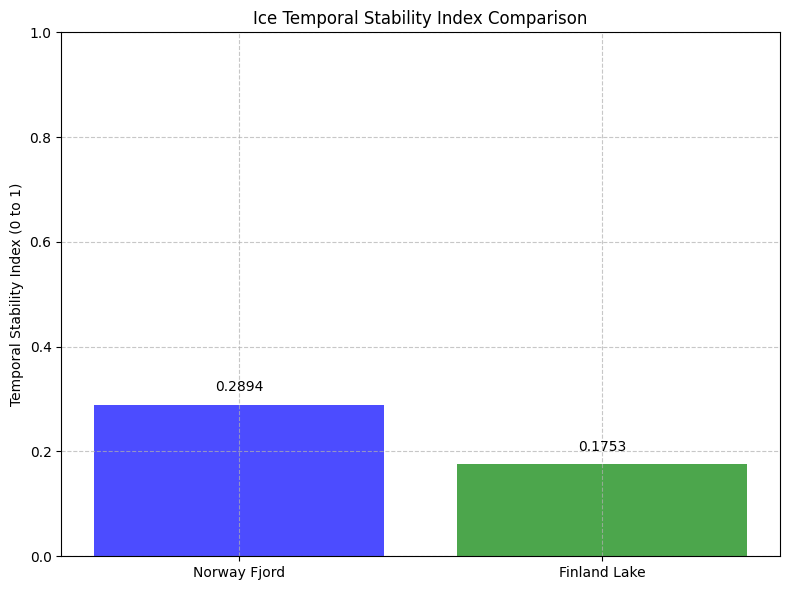

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from pathlib import Path
import pandas as pd
from scipy import ndimage
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from scipy.ndimage import gaussian_filter  


norway_data = [np.random.rand(100, 100, 2) for _ in range(16)]  
finland_data = [np.random.rand(100, 100, 2) for _ in range(16)] 
slots = [
    ("Sep 2023", "Nov 2023"),
    ("Nov 2023", "Jan 2024"),
    ("Jan 2024", "Mar 2024"),
    ("Mar 2024", "May 2024"),
    ("May 2024", "Sep 2024"),
    ("Sep 2024", "Mar 2025")
]
predictions_dir = Path("mystorage/predictions")
predictions_dir.mkdir(exist_ok=True)

# Color definitions
class_colors = {
    'open_water': [0, 0.3, 0.8],  # Blue
    'ice': [0.9, 0.9, 1],         # Light blue/white
    'land': [0.5, 0.5, 0.5]       # Gray
}


def generate_training_data(n_samples=1000, height=100, width=100):
    X_train = np.zeros((n_samples, 4))
    y_train = np.random.choice(['open_water', 'ice', 'land'], size=n_samples)
    for i in range(n_samples):
        img = np.random.rand(height, width)
        mean_filter = ndimage.uniform_filter(img, size=3)
        std_filter = np.sqrt(ndimage.uniform_filter(img**2, size=3) - mean_filter**2)
        r, c = np.random.randint(0, height), np.random.randint(0, width)
        X_train[i, 0] = img[r, c]
        X_train[i, 1] = mean_filter[r, c]
        X_train[i, 2] = std_filter[r, c]
        X_train[i, 3] = np.random.choice([0, 1])
    return X_train, y_train

scaler = StandardScaler()
clf = RandomForestClassifier()
X_train, y_train = generate_training_data()
scaler.fit(X_train)
clf.fit(X_train, y_train)

# classify_image function
def classify_image(sar_image, region_idx):
    sar_values = sar_image[..., 0]
    mask = sar_image[..., 1] if sar_image.shape[-1] > 1 else np.ones_like(sar_values)
    height, width = sar_values.shape
    class_map = np.zeros((height, width, 3))
    class_map[mask == 0] = [0, 0, 0]
    mean_filter = ndimage.uniform_filter(sar_values, size=3)
    std_filter = np.sqrt(ndimage.uniform_filter(sar_values**2, size=3) - mean_filter**2)
    rows, cols = np.where(mask > 0)
    if len(rows) > 0:
        X_pixels = np.zeros((len(rows), 4))
        X_pixels[:, 0] = sar_values[rows, cols]
        X_pixels[:, 1] = mean_filter[rows, cols]
        X_pixels[:, 2] = std_filter[rows, cols]
        X_pixels[:, 3] = region_idx
        X_pixels_scaled = scaler.transform(X_pixels)
        predictions = clf.predict(X_pixels_scaled)
        for i, (r, c) in enumerate(zip(rows, cols)):
            class_map[r, c] = class_colors[predictions[i]]
    return class_map

# Process Norway and Finland data
norway_class_maps = []
for i, data in enumerate(norway_data):
    if i >= len(slots):
        break
    norway_class_maps.append(classify_image(data, 0))

finland_class_maps = []
for i, data in enumerate(finland_data):
    if i >= len(slots):
        break
    finland_class_maps.append(classify_image(data, 1))

# Indicator: Ice Temporal Stability Index
def compute_ice_temporal_stability(class_maps, ice_color):
    if not class_maps:
        return np.zeros((1, 1)), 0.0
    
    #  (1 for ice, 0 for non ice)
    ice_maps = np.stack([np.all(cm == ice_color, axis=-1).astype(np.uint8) for cm in class_maps], axis=0)
    
    # Calculate fraction of time each pixel is ice
    stability_map = np.mean(ice_maps, axis=0) 
    
    # Average stability across ice-covered pixels
    ice_presence = np.any(ice_maps, axis=0)  
    if not np.any(ice_presence):
        return stability_map, 0.0
    
    temporal_stability_index = np.mean(stability_map[ice_presence])
    return stability_map, temporal_stability_index

# Analyze ice temporal stability with improved visualizations
def analyze_ice_temporal_stability(norway_class_maps, finland_class_maps, slots, class_colors):
    # Compute temporal stability for Norway
    norway_stability_map, norway_stability_index = compute_ice_temporal_stability(norway_class_maps, class_colors['ice'])
    
    # Compute temporal stability for Finland
    finland_stability_map, finland_stability_index = compute_ice_temporal_stability(finland_class_maps, class_colors['ice'])
    
    # Smooth the stability maps to reduce noise and improve readability
    norway_stability_map_smooth = gaussian_filter(norway_stability_map, sigma=2)
    finland_stability_map_smooth = gaussian_filter(finland_stability_map, sigma=2)
    
    # Create DataFrame for comparison
    df = pd.DataFrame({
        'Region': ['Norway Fjord', 'Finland Lake'],
        'temporal_stability_index': [norway_stability_index, finland_stability_index]
    })
    
    # Create figures
    figs = {
        'stability_maps': plt.figure(figsize=(12, 6)),
        'stability_comparison': plt.figure(figsize=(8, 6))
    }
    
    # Plot 1: Side-by-side stability maps for Norway and Finland
    ax1 = figs['stability_maps'].add_subplot(121)
    im1 = ax1.imshow(norway_stability_map_smooth, cmap='Blues', vmin=0, vmax=1)
    ax1.set_title(f"Norway Fjord Ice Temporal Stability Map\nIndex: {norway_stability_index:.4f}")
    ax1.set_xlabel('X Coordinate')
    ax1.set_ylabel('Y Coordinate')
    figs['stability_maps'].colorbar(im1, ax=ax1, label='Stability (0 to 1)')
    ax1.axis('off')
    
    ax2 = figs['stability_maps'].add_subplot(122)
    im2 = ax2.imshow(finland_stability_map_smooth, cmap='Blues', vmin=0, vmax=1)
    ax2.set_title(f"Finland Lake Ice Temporal Stability Map\nIndex: {finland_stability_index:.4f}")
    ax2.set_xlabel('X Coordinate')
    ax2.set_ylabel('Y Coordinate')
    figs['stability_maps'].colorbar(im2, ax=ax2, label='Stability (0 to 1)')
    ax2.axis('off')
    
    figs['stability_maps'].tight_layout()
    
    # Plot 2: Bar chart comparing stability indices
    ax3 = figs['stability_comparison'].add_subplot(111)
    bars = ax3.bar(df['Region'], df['temporal_stability_index'], color=['blue', 'green'], alpha=0.7)
    ax3.set_title('Ice Temporal Stability Index Comparison')
    ax3.set_ylabel('Temporal Stability Index (0 to 1)')
    ax3.set_ylim(0, 1)
    ax3.grid(True, linestyle='--', alpha=0.7)
    
    # Add value labels on top of the bars
    for bar in bars:
        height = bar.get_height()
        ax3.text(bar.get_x() + bar.get_width() / 2, height + 0.02, f'{height:.4f}', ha='center', va='bottom')
    
    figs['stability_comparison'].tight_layout()
    
    return df, figs, (norway_stability_map_smooth, finland_stability_map_smooth), (norway_stability_index, finland_stability_index)

# Process data
df, figs, (norway_stability_map, finland_stability_map), (norway_stability_index, finland_stability_index) = analyze_ice_temporal_stability(
    norway_class_maps, finland_class_maps, slots, class_colors
)

# Display results
print(f"Norway Fjord Ice Temporal Stability Index: {norway_stability_index:.4f}")
print(f"Finland Lake Ice Temporal Stability Index: {finland_stability_index:.4f}")

plt.show()
figs['stability_maps'].savefig(predictions_dir / "stability_maps_comparison.png", dpi=300)
figs['stability_comparison'].savefig(predictions_dir / "stability_index_comparison.png", dpi=300)

In [30]:
import os
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from matplotlib.colors import LinearSegmentedColormap
import datetime
import json
import pandas as pd
from matplotlib.dates import DateFormatter

import json
import numpy as np
from pathlib import Path

# Create data directory
data_dir = Path("mystorage/data")
data_dir.mkdir(parents=True, exist_ok=True)

# Norway fjord simplified
norway_bbox = (4.5, 60.0, 7.5, 61.5)
center_lon = (norway_bbox[0] + norway_bbox[2]) / 2
center_lat = (norway_bbox[1] + norway_bbox[3]) / 2
width = (norway_bbox[2] - norway_bbox[0]) * 0.6
height = (norway_bbox[3] - norway_bbox[1]) * 0.7

# Create fjord shape
fjord_coords = [
    [center_lon - width/2, center_lat - height/2],
    [center_lon - width/4, center_lat - height/4],
    [center_lon, center_lat - height/8],
    [center_lon + width/4, center_lat - height/4],
    [center_lon + width/2, center_lat - height/2],
    [center_lon + width/3, center_lat],
    [center_lon + width/4, center_lat + height/3],
    [center_lon, center_lat + height/2],
    [center_lon - width/4, center_lat + height/3],
    [center_lon - width/3, center_lat],
    [center_lon - width/2, center_lat - height/2]
]

# Create smaller fjords around the main one
small_fjords = []
for i in range(3):
    # Adjust position and size
    shift_lon = np.random.uniform(-0.3, 0.3)
    shift_lat = np.random.uniform(-0.2, 0.2)
    size_factor = np.random.uniform(0.2, 0.4)
    
    # Create smaller fjord
    small_fjord_coords = []
    for x, y in fjord_coords:
        new_x = center_lon + (x - center_lon) * size_factor + shift_lon
        new_y = center_lat + (y - center_lat) * size_factor + shift_lat
        small_fjord_coords.append([new_x, new_y])
    
    small_fjords.append({
        "type": "Feature",
        "properties": {
            "name": f"Small Fjord {i+1}",
            "description": f"Smaller fjord in Norway",
            "water": "fjord",
            "size": "small"
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [small_fjord_coords]
        }
    })

fjord_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "Sognefjord",
                "description": "Example fjord in Norway",
                "water": "fjord",
                "size": "large"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [fjord_coords]
            }
        }
    ] + small_fjords
}

# Finland lake simplified
finland_bbox = (24.5, 61.0, 29.5, 63.0)
center_lon = (finland_bbox[0] + finland_bbox[2]) / 2
center_lat = (finland_bbox[1] + finland_bbox[3]) / 2
width = (finland_bbox[2] - finland_bbox[0]) * 0.5
height = (finland_bbox[3] - finland_bbox[1]) * 0.5

# Generate lake shape
theta = np.linspace(0, 2*np.pi, 30)
lake_coords = [[center_lon + width/2 * np.cos(t), center_lat + height/2 * np.sin(t)] for t in theta]

# Create smaller lakes
small_lakes = []
for i in range(5):
    # Adjust position and size
    new_center_lon = np.random.uniform(finland_bbox[0], finland_bbox[2])
    new_center_lat = np.random.uniform(finland_bbox[1], finland_bbox[3])
    new_width = np.random.uniform(0.1, 0.3) * width
    new_height = np.random.uniform(0.1, 0.3) * height
    
    # Generate lake shape
    lake_theta = np.linspace(0, 2*np.pi, 20)
    small_lake_coords = [[new_center_lon + new_width * np.cos(t), new_center_lat + new_height * np.sin(t)] for t in lake_theta]
    
    small_lakes.append({
        "type": "Feature",
        "properties": {
            "name": f"Small Lake {i+1}",
            "description": f"Smaller lake in Finland",
            "water": "lake",
            "size": "small"
        },
        "geometry": {
            "type": "Polygon",
            "coordinates": [small_lake_coords]
        }
    })

lake_geojson = {
    "type": "FeatureCollection",
    "features": [
        {
            "type": "Feature",
            "properties": {
                "name": "Saimaa",
                "description": "Example lake in Finland",
                "water": "lake",
                "size": "large"
            },
            "geometry": {
                "type": "Polygon",
                "coordinates": [lake_coords]
            }
        }
    ] + small_lakes
}

# Save the GeoJSON files
norway_fjord_path = data_dir / "norway_fjord.geojson"
finland_lake_path = data_dir / "finland_lake.geojson"

with open(norway_fjord_path, 'w') as f:
    json.dump(fjord_geojson, f)

with open(finland_lake_path, 'w') as f:
    json.dump(lake_geojson, f)

print("Created GeoJSON files:")
print(f"1. Norway Fjord: {norway_fjord_path}")
print(f"2. Finland Lake: {finland_lake_path}")

# Generate sample SAR data 
def generate_sample_sar_data():
    # Time slots
    start = datetime.datetime(2023, 9, 1)
    end = datetime.datetime(2025, 3, 1)
    n_chunks = 17
    tdelta = (end - start) / n_chunks
    edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
    slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    
    # Sample data
    norway_sar_data = {}
    finland_sar_data = {}
    
    for i, (start_date, end_date) in enumerate(slots):
        # Create date key
        date_key = f"{start_date} to {end_date}"
        
        # Create sample SAR data with random variations
        # Make it more realistic by simulating seasonal changes
        month = start_date.split('-')[1] 
        month_num = int(month)
        
        # More water in spring/fall months
        season_factor_norway = 1.0 + 0.3 * np.sin(2 * np.pi * (month_num - 3) / 12)
        season_factor_finland = 1.0 + 0.4 * np.sin(2 * np.pi * (month_num - 3) / 12)
        
        # Add some random noise
        np.random.seed(i)  # For reproducibility
        noise_norway = np.random.normal(0, 0.15)
        noise_finland = np.random.normal(0, 0.2)
        
        # Simulate data
        norway_data = {
            'water_percentage': 35 * season_factor_norway + noise_norway * 10,
            'water_backscatter': 0.15 - 0.05 * season_factor_norway + noise_norway * 0.02
        }
        
        finland_data = {
            'water_percentage': 20 * season_factor_finland + noise_finland * 8,
            'water_backscatter': 0.12 - 0.03 * season_factor_finland + noise_finland * 0.03
        }
        
        norway_sar_data[date_key] = norway_data
        finland_sar_data[date_key] = finland_data
    
    return slots, norway_sar_data, finland_sar_data

# Generate sample data
slots, norway_stats, finland_stats = generate_sample_sar_data()

# Create time series data
norway_dates = list(norway_stats.keys())
norway_water_percentages = [stats['water_percentage'] for stats in norway_stats.values()]
norway_backscatter = [stats['water_backscatter'] for stats in norway_stats.values()]

finland_dates = list(finland_stats.keys())
finland_water_percentages = [stats['water_percentage'] for stats in finland_stats.values()]
finland_backscatter = [stats['water_backscatter'] for stats in finland_stats.values()]

def create_time_series_plot():
    """Create time series plot of water statistics using matplotlib"""
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 8), sharex=True)
    
    
    x_norway = []
    for date_str in norway_dates:
        if " to " in date_str:
            start_date = date_str.split(" to ")[0]
            x_norway.append(pd.to_datetime(start_date))
        else:
            # Try to parse as is
            try:
                x_norway.append(pd.to_datetime(date_str))
            except:
                x_norway.append(date_str)  # Keep as string if parsing fails
    
    x_finland = []
    for date_str in finland_dates:
        if " to " in date_str:
            start_date = date_str.split(" to ")[0]
            x_finland.append(pd.to_datetime(start_date))
        else:
            # Try to parse as is
            try:
                x_finland.append(pd.to_datetime(date_str))
            except:
                x_finland.append(date_str)  # Keep as string if parsing fails
    
    # Plot water percentage
    ax1.plot(x_norway, norway_water_percentages, 'o-', color='blue', label='Norway Fjords')
    ax1.plot(x_finland, finland_water_percentages, 'o-', color='green', label='Finland Lakes')
    ax1.set_ylabel('Water Coverage (%)')
    ax1.set_title('Water Coverage Percentage')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot backscatter values
    ax2.plot(x_norway, norway_backscatter, 'o-', color='darkblue', label='Norway Backscatter')
    ax2.plot(x_finland, finland_backscatter, 'o-', color='darkgreen', label='Finland Backscatter')
    ax2.set_ylabel('Backscatter (dB)')
    ax2.set_title('Average Water Backscatter')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Format x-axis if dates are datetime objects
    if isinstance(x_norway[0], pd.Timestamp):
        date_format = DateFormatter('%Y-%m-%d')
        ax2.xaxis.set_major_formatter(date_format)
        plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.suptitle('Water Body Monitoring Over Time', y=1.02, fontsize=16)
    
    return fig

def create_map_plot():
    """Create a static map plot showing the Norwegian fjords and Finnish lakes"""
    # Create a figure for the map
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Function to plot a GeoJSON polygon
    def plot_polygon(polygon, color, label):
        if polygon['geometry']['type'] == 'Polygon':
            coords = np.array(polygon['geometry']['coordinates'][0])
            ax.plot(coords[:, 0], coords[:, 1], color=color, alpha=0.7)
            ax.fill(coords[:, 0], coords[:, 1], color=color, alpha=0.2, label=label)
    
    # Plot Norway fjords
    for i, feature in enumerate(fjord_geojson['features']):
        label = "Norway Fjords" if i == 0 else ""
        plot_polygon(feature, 'blue', label)
    
    # Plot Finland lakes
    for i, feature in enumerate(lake_geojson['features']):
        label = "Finland Lakes" if i == 0 else ""
        plot_polygon(feature, 'green', label)
    
    # Set limits to show both areas
    plt.xlim(min(norway_bbox[0], finland_bbox[0]) - 1, max(norway_bbox[2], finland_bbox[2]) + 1)
    plt.ylim(min(norway_bbox[1], finland_bbox[1]) - 1, max(norway_bbox[3], finland_bbox[3]) + 1)
    
    # Add legend, title and labels
    plt.legend()
    plt.title('Water Bodies in Norway and Finland')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.grid(alpha=0.3)
    
    return fig

def create_dashboard():
    """Create a simplified dashboard without requiring ipyleaflet"""
    # Create tabs for different components
    tab_titles = ['Map View', 'Time Series Analysis', 'Water Statistics']
    tab = widgets.Tab()
    
    # Map tab
    map_output = widgets.Output()
    with map_output:
        fig = create_map_plot()
        plt.show()
    
    # Time series tab
    timeseries_output = widgets.Output()
    with timeseries_output:
        fig = create_time_series_plot()
        plt.show()
    
    # Statistics tab
    stats_output = widgets.Output()
    with stats_output:
        # Create a table of statistics
        dates = list(norway_stats.keys())
        
        # Calculate some additional statistics
        norway_avg_water = np.mean(norway_water_percentages)
        finland_avg_water = np.mean(finland_water_percentages)
        
        norway_max_month = dates[np.argmax(norway_water_percentages)]
        finland_max_month = dates[np.argmax(finland_water_percentages)]
        
        norway_min_month = dates[np.argmin(norway_water_percentages)]
        finland_min_month = dates[np.argmin(finland_water_percentages)]
        
        # Create comparison bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = np.arange(2)
        width = 0.35
        
        ax.bar(x - width/2, [norway_avg_water, np.max(norway_water_percentages)], 
               width, label='Norway Fjords', color='blue', alpha=0.7)
        ax.bar(x + width/2, [finland_avg_water, np.max(finland_water_percentages)], 
               width, label='Finland Lakes', color='green', alpha=0.7)
        
        ax.set_ylabel('Water Coverage (%)')
        ax.set_title('Water Coverage Comparison')
        ax.set_xticks(x)
        ax.set_xticklabels(['Average Coverage', 'Maximum Coverage'])
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # statistics summary
        print("\nWater Body Statistics Summary:")
        print("=" * 50)
        print(f"Norway Fjords:")
        print(f"  - Average water coverage: {norway_avg_water:.2f}%")
        print(f"  - Maximum water period: {norway_max_month} ({np.max(norway_water_percentages):.2f}%)")
        print(f"  - Minimum water period: {norway_min_month} ({np.min(norway_water_percentages):.2f}%)")
        print(f"  - Variation range: {np.max(norway_water_percentages) - np.min(norway_water_percentages):.2f}%")
        print("\nFinland Lakes:")
        print(f"  - Average water coverage: {finland_avg_water:.2f}%")
        print(f"  - Maximum water period: {finland_max_month} ({np.max(finland_water_percentages):.2f}%)")
        print(f"  - Minimum water period: {finland_min_month} ({np.min(finland_water_percentages):.2f}%)")
        print(f"  - Variation range: {np.max(finland_water_percentages) - np.min(finland_water_percentages):.2f}%")
        
        # Create seasonal analysis
        print("\nSeasonal Patterns:")
        print("=" * 50)
        
        # months and group data by season
        def get_season(date_str):
            if " to " in date_str:
                month = int(date_str.split("-")[1])
            else:
                month = 1  # Default if parsing fails
                
            if month in [12, 1, 2]:
                return "Winter"
            elif month in [3, 4, 5]:
                return "Spring"
            elif month in [6, 7, 8]:
                return "Summer"
            else:
                return "Fall"
        
        # Group data by season
        norway_seasonal = {"Winter": [], "Spring": [], "Summer": [], "Fall": []}
        finland_seasonal = {"Winter": [], "Spring": [], "Summer": [], "Fall": []}
        
        for i, date in enumerate(dates):
            season = get_season(date)
            norway_seasonal[season].append(norway_water_percentages[i])
            finland_seasonal[season].append(finland_water_percentages[i])
        
        # Calculate seasonal averages
        seasons = ["Winter", "Spring", "Summer", "Fall"]
        norway_seasonal_avg = [np.mean(norway_seasonal[s]) if norway_seasonal[s] else 0 for s in seasons]
        finland_seasonal_avg = [np.mean(finland_seasonal[s]) if finland_seasonal[s] else 0 for s in seasons]
        
        # Create seasonal bar chart
        fig, ax = plt.subplots(figsize=(10, 6))
        
        x = np.arange(len(seasons))
        width = 0.35
        
        ax.bar(x - width/2, norway_seasonal_avg, width, label='Norway Fjords', color='blue', alpha=0.7)
        ax.bar(x + width/2, finland_seasonal_avg, width, label='Finland Lakes', color='green', alpha=0.7)
        
        ax.set_ylabel('Average Water Coverage (%)')
        ax.set_title('Seasonal Water Coverage Patterns')
        ax.set_xticks(x)
        ax.set_xticklabels(seasons)
        ax.legend()
        
        plt.tight_layout()
        plt.show()
        
        # seasonal analysis
        for season in seasons:
            norway_avg = np.mean(norway_seasonal[season]) if norway_seasonal[season] else 0
            finland_avg = np.mean(finland_seasonal[season]) if finland_seasonal[season] else 0
            
            print(f"{season}:")
            print(f"  - Norway fjords average coverage: {norway_avg:.2f}%")
            print(f"  - Finland lakes average coverage: {finland_avg:.2f}%")
            print(f"  - Difference: {abs(norway_avg - finland_avg):.2f}%")
            print()
        
    
    tab.children = [map_output, timeseries_output, stats_output]
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    # Create header
    header = widgets.HTML(
        value="<h1 style='text-align: center;'>Water Body Monitoring Dashboard</h1>"
    )
    
    # Create information panel
    info_text = """
    <div style='background-color: #f8f9fa; padding: 10px; border-radius: 5px;'>
        <h3>Dashboard Information</h3>
        <p>This dashboard demonstrates water body monitoring in Norway and Finland using simplified data.
        The analysis simulates tracking changes in water coverage from September 2023 to March 2025.</p>
        <p><b>Map View:</b> Shows the locations of the monitored water bodies.</p>
        <p><b>Time Series Analysis:</b> Displays simulated changes in water coverage percentage and backscatter over time.</p>
        <p><b>Water Statistics:</b> Provides statistical analysis of water coverage patterns.</p>
        <p><i>Note: This is a demonstration with simulated data based on realistic seasonal patterns.</i></p>
    </div>
    """
    info_panel = widgets.HTML(value=info_text)
    
    # Create layout
    dashboard = widgets.VBox([header, info_panel, tab], layout=widgets.Layout(width='100%'))
    return dashboard

# Display the dashboard
dashboard = create_dashboard()
display(dashboard)

Created GeoJSON files:
1. Norway Fjord: mystorage/data/norway_fjord.geojson
2. Finland Lake: mystorage/data/finland_lake.geojson


In [31]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
import datetime
import json
from pathlib import Path
import pandas as pd
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
from matplotlib.dates import DateFormatter

# Create necessary directories
data_dir = Path("mystorage/data")
data_dir.mkdir(parents=True, exist_ok=True)
results_dir = Path("mystorage/results")
results_dir.mkdir(parents=True, exist_ok=True)
norway_dir = results_dir / "norway"
norway_dir.mkdir(exist_ok=True)
finland_dir = results_dir / "finland"
finland_dir.mkdir(exist_ok=True)

# Define time slots
start = datetime.datetime(2023, 9, 1)
end = datetime.datetime(2025, 3, 1)
n_chunks = 17
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

# Generate sample SAR data
def generate_sample_data():
    """Generate sample SAR data for Norwegian fjords and Finnish lakes"""
    np.random.seed(42)  # For reproducibility
    
    # Norway fjord simplified
    norway_bbox = (4.5, 60.0, 7.5, 61.5)
    
    # Finland lake simplified
    finland_bbox = (24.5, 61.0, 29.5, 63.0)
    
    # Generate sample data
    norway_data = []
    finland_data = []
    
    # Define image dimensions
    height, width = 100, 120
    
    for i in range(len(slots)):
        # Create seasonal variations using the month
        month = int(slots[i][0].split('-')[1])
        
        # More water in spring/summer
        norway_season_factor = 1.0 + 0.3 * np.sin(2 * np.pi * (month - 3) / 12)
        finland_season_factor = 1.0 + 0.4 * np.sin(2 * np.pi * (month - 3) / 12)
        
        # Create base image with noise
        norway_base = np.random.normal(0.3, 0.05, (height, width))
        finland_base = np.random.normal(0.25, 0.06, (height, width))
        
        # Create water bodies with varying shapes based on season
        norway_water = np.zeros((height, width))
        finland_water = np.zeros((height, width))
        
        # Create fjord shape
        center_y, center_x = height // 2, width // 2
        y, x = np.ogrid[-center_y:height-center_y, -center_x:width-center_x]
        
        # Norway fjord (elongated shape)
        fjord_width = 30 * norway_season_factor
        fjord_mask = ((x/fjord_width)**2 + (y/(height*0.4))**2 <= 1) & \
                      (x > -width*0.3) & (x < width*0.4)
                      
        # Add some smaller fjord branches
        branch1_mask = ((x+20)**2/400 + (y-10)**2/100 <= 1) & (x > -width*0.5) & (x < 0)
        branch2_mask = ((x-15)**2/300 + (y+15)**2/150 <= 1) & (x > 0) & (x < width*0.5)
        
        norway_water[fjord_mask | branch1_mask | branch2_mask] = 0.15 - 0.05 * norway_season_factor
        
        # Finland lake (more circular shape)
        lake_size = 35 * finland_season_factor
        lake_mask = ((x/lake_size)**2 + (y/lake_size)**2 <= 1)
        
        # Add some smaller lakes
        lake1_mask = ((x+30)**2 + (y-20)**2) / 200 <= 1
        lake2_mask = ((x-25)**2 + (y+25)**2) / 250 <= 1
        
        finland_water[lake_mask | lake1_mask | lake2_mask] = 0.12 - 0.03 * finland_season_factor
        
        # Add random variations
        norway_water += np.random.normal(0, 0.02, (height, width))
        finland_water += np.random.normal(0, 0.02, (height, width))
        
        # Combine with base image
        norway_image = norway_base.copy()
        norway_image[fjord_mask | branch1_mask | branch2_mask] = norway_water[fjord_mask | branch1_mask | branch2_mask]
        
        finland_image = finland_base.copy()
        finland_image[lake_mask | lake1_mask | lake2_mask] = finland_water[lake_mask | lake1_mask | lake2_mask]
        
        # Create masks
        norway_mask = np.ones_like(norway_image)
        finland_mask = np.ones_like(finland_image)
        
        # Stack data with mask
        norway_data.append(np.stack([norway_image, norway_mask], axis=-1))
        finland_data.append(np.stack([finland_image, finland_mask], axis=-1))
    
    return norway_data, finland_data

# Define visualization function
def visualize_sar_data(norway_data, finland_data, slots):
    """
    Generate static visualizations of SAR data and save them to files
    
    Parameters:
    -----------
    norway_data : list
        List of SAR data arrays for Norway
    finland_data : list
        List of SAR data arrays for Finland
    slots : list
        List of time slots (date ranges)
    """
    # Define a custom colormap for water features
    water_colors = [(0.9, 0.9, 1), (0, 0.3, 0.8), (0, 0, 0.6)]
    blue_cmap = LinearSegmentedColormap.from_list('water_blues', water_colors, N=256)
    
    # Process Norway images
    print(f"Visualizing {len(norway_data)} Norway fjord SAR images...")
    for idx, data in enumerate(norway_data):
        if idx >= len(slots):
            break
            
        # Get time slot for this image
        time_slot = slots[idx]
        start_date = time_slot[0]
        end_date = time_slot[1]
        
        # Create a figure
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111)
        
        # Extract SAR data (first band) and mask (second band)
        sar_data = data[..., 0]
        mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
        
        # Apply mask
        masked_data = np.ma.masked_where(mask == 0, sar_data)
        
        # Plot the data
        im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
        
        # Add title with date range
        ax.set_title(f"Norway Fjord: {start_date} to {end_date}", fontsize=14)
        ax.axis('off')
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('SAR backscatter (dB scaled)')
        
        # Save the figure
        output_path = norway_dir / f"norway_sar_{idx}.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close(fig)
        
        print(f"  Saved image {idx+1}/{len(norway_data)}: {output_path}")
        
    # Process Finland images
    print(f"Visualizing {len(finland_data)} Finland lake SAR images...")
    for idx, data in enumerate(finland_data):
        if idx >= len(slots):
            break
            
        # Get time slot for this image
        time_slot = slots[idx]
        start_date = time_slot[0]
        end_date = time_slot[1]
        
        # Create a figure
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111)
        
        # Extract SAR data (first band) and mask (second band)
        sar_data = data[..., 0]
        mask = data[..., 1] if data.shape[-1] > 1 else np.ones_like(sar_data)
        
        # Apply mask
        masked_data = np.ma.masked_where(mask == 0, sar_data)
        
        # Plot the data
        im = ax.imshow(masked_data, cmap=blue_cmap, vmin=0, vmax=1)
        
        # Add title with date range
        ax.set_title(f"Finland Lake: {start_date} to {end_date}", fontsize=14)
        ax.axis('off')
        
        # Add colorbar
        cbar = fig.colorbar(im, ax=ax)
        cbar.set_label('SAR backscatter (dB scaled)')
        
        # Save the figure
        output_path = finland_dir / f"finland_sar_{idx}.png"
        plt.savefig(output_path, dpi=150, bbox_inches='tight')
        plt.close(fig)
        
        print(f"  Saved image {idx+1}/{len(finland_data)}: {output_path}")
    
    # Create time series analysis
    create_time_series_analysis(norway_data, finland_data, slots)
    
    # Create seasonal analysis
    create_seasonal_analysis(norway_data, finland_data, slots)
    
    print("All visualizations saved.")

def create_time_series_analysis(norway_data, finland_data, slots):
    
    # Calculate water coverage for each image
    norway_coverage = []
    norway_backscatter = []
    finland_coverage = []
    finland_backscatter = []
    
    water_threshold = 0.2 
    
    for data in norway_data:
        sar_data = data[..., 0]
        water_mask = sar_data < water_threshold
        coverage = np.sum(water_mask) / sar_data.size * 100
        avg_backscatter = np.mean(sar_data[water_mask]) if np.sum(water_mask) > 0 else np.nan
        
        norway_coverage.append(coverage)
        norway_backscatter.append(avg_backscatter)
    
    for data in finland_data:
        sar_data = data[..., 0]
        water_mask = sar_data < water_threshold
        coverage = np.sum(water_mask) / sar_data.size * 100
        avg_backscatter = np.mean(sar_data[water_mask]) if np.sum(water_mask) > 0 else np.nan
        
        finland_coverage.append(coverage)
        finland_backscatter.append(avg_backscatter)
    
    # Create dates for x-axis
    dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots[:len(norway_data)]]
    
    # Create figure
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 10), sharex=True)
    
    # Plot water coverage
    ax1.plot(dates, norway_coverage, 'o-', color='blue', label='Norway Fjord')
    ax1.plot(dates, finland_coverage, 'o-', color='green', label='Finland Lake')
    ax1.set_ylabel('Water Coverage (%)')
    ax1.set_title('Water Coverage Over Time')
    ax1.grid(True, alpha=0.3)
    ax1.legend()
    
    # Plot backscatter
    ax2.plot(dates, norway_backscatter, 'o-', color='darkblue', label='Norway Fjord')
    ax2.plot(dates, finland_backscatter, 'o-', color='darkgreen', label='Finland Lake')
    ax2.set_ylabel('Average Backscatter')
    ax2.set_title('Average Water Backscatter Over Time')
    ax2.grid(True, alpha=0.3)
    ax2.legend()
    
    # Format x-axis
    date_format = DateFormatter('%Y-%m-%d')
    ax2.xaxis.set_major_formatter(date_format)
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.savefig(results_dir / "water_time_series.png", dpi=150)
    plt.close()

def create_seasonal_analysis(norway_data, finland_data, slots):
    """Create seasonal analysis of water bodies"""
    # Group data by seasons
    seasons = {
        'Winter': [12, 1, 2],
        'Spring': [3, 4, 5],
        'Summer': [6, 7, 8],
        'Fall': [9, 10, 11]
    }
    
    norway_seasonal = {season: [] for season in seasons}
    finland_seasonal = {season: [] for season in seasons}
    
    water_threshold = 0.2  
    
    # Group data by season
    for i, slot in enumerate(slots):
        if i >= len(norway_data) or i >= len(finland_data):
            break
            
        # Get month from date
        month = int(slot[0].split('-')[1])
        
        # Determine season
        for season, months in seasons.items():
            if month in months:
                # Calculate water coverage
                norway_sar = norway_data[i][..., 0]
                norway_water = np.sum(norway_sar < water_threshold) / norway_sar.size * 100
                
                finland_sar = finland_data[i][..., 0]
                finland_water = np.sum(finland_sar < water_threshold) / finland_sar.size * 100
                
                norway_seasonal[season].append(norway_water)
                finland_seasonal[season].append(finland_water)
    
    # Calculate seasonal averages
    norway_means = []
    finland_means = []
    season_labels = []
    
    for season in ['Winter', 'Spring', 'Summer', 'Fall']:
        if norway_seasonal[season]:
            norway_means.append(np.mean(norway_seasonal[season]))
            season_labels.append(season)
        else:
            norway_means.append(0)
            
        if finland_seasonal[season]:
            finland_means.append(np.mean(finland_seasonal[season]))
        else:
            finland_means.append(0)
    
    # Create seasonal comparison plot
    fig, ax = plt.subplots(figsize=(10, 6))
    
    x = np.arange(len(season_labels))
    width = 0.35
    
    ax.bar(x - width/2, norway_means, width, label='Norway Fjord', color='navy')
    ax.bar(x + width/2, finland_means, width, label='Finland Lake', color='royalblue')
    
    ax.set_xlabel('Season')
    ax.set_ylabel('Average Water Coverage (%)')
    ax.set_title('Seasonal Water Coverage Comparison')
    ax.set_xticks(x)
    ax.set_xticklabels(season_labels)
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig(results_dir / "seasonal_comparison.png", dpi=150)
    plt.close()

# Create the interactive dashboard
def create_dashboard():
    """Create an interactive dashboard for exploring water body monitoring results"""
    # Generate sample data if it doesn't exist
    if not (norway_dir / "norway_sar_0.png").exists() or not (finland_dir / "finland_sar_0.png").exists():
        print("Generating sample data and visualizations...")
        norway_data, finland_data = generate_sample_data()
        visualize_sar_data(norway_data, finland_data, slots)
    
    # Get available images
    norway_images = sorted(list(norway_dir.glob("norway_sar_*.png")))
    finland_images = sorted(list(finland_dir.glob("finland_sar_*.png")))
    
    # Create region selector
    region_selector = widgets.ToggleButtons(
        options=[('Norway Fjord', 'norway'), ('Finland Lake', 'finland')],
        description='Region:',
        disabled=False,
        button_style='info',
        tooltips=['Norwegian Fjords', 'Finnish Lakes']
    )
    
    # Create date slider
    date_slider = widgets.IntSlider(
        value=0,
        min=0,
        max=len(slots)-1,
        step=1,
        description='Time Period:',
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    
    # Create date label
    date_label = widgets.HTML(
        value=f"<b>{slots[0][0]} to {slots[0][1]}</b>"
    )
    
    # Create image viewer
    image_widget = widgets.Image(
        format='png',
        width=600,
        height=500,
    )
    
    # Load summary images
    time_series_img = results_dir / "water_time_series.png"
    seasonal_img = results_dir / "seasonal_comparison.png"
    
    # Create summary image widgets
    if time_series_img.exists():
        with open(time_series_img, "rb") as f:
            time_series_data = f.read()
    else:
        time_series_data = b""
        
    if seasonal_img.exists():
        with open(seasonal_img, "rb") as f:
            seasonal_data = f.read()
    else:
        seasonal_data = b""
    
    time_series_widget = widgets.Image(
        value=time_series_data,
        format='png',
        width=600,
        height=500,
    )
    
    seasonal_widget = widgets.Image(
        value=seasonal_data,
        format='png',
        width=600,
        height=400,
    )
    
    # Create image statistics panel
    stats_panel = widgets.HTML(
        value="<h3>Image Statistics</h3><p>Select an image to view statistics</p>"
    )
    
    # Update functions
    def update_image(change):
        region = region_selector.value
        idx = date_slider.value
        
        # Update date label
        date_label.value = f"<b>{slots[idx][0]} to {slots[idx][1]}</b>"
        
        # Load and display image
        if region == 'norway' and idx < len(norway_images):
            image_path = norway_images[idx]
            with open(image_path, "rb") as f:
                image_widget.value = f.read()
                
            # Calculate and update statistics
            calculate_image_stats('norway', idx)
            
        elif region == 'finland' and idx < len(finland_images):
            image_path = finland_images[idx]
            with open(image_path, "rb") as f:
                image_widget.value = f.read()
                
            # Calculate and update statistics
            calculate_image_stats('finland', idx)
    
    def calculate_image_stats(region, idx):
    
        
        norway_data, finland_data = generate_sample_data()
        
        if region == 'norway' and idx < len(norway_data):
            data = norway_data[idx][..., 0]
        elif region == 'finland' and idx < len(finland_data):
            data = finland_data[idx][..., 0]
        else:
            return
        
        # Calculate water statistics
        water_threshold = 0.2
        water_mask = data < water_threshold
        water_coverage = np.sum(water_mask) / data.size * 100
        water_mean = np.mean(data[water_mask]) if np.sum(water_mask) > 0 else np.nan
        water_std = np.std(data[water_mask]) if np.sum(water_mask) > 0 else np.nan
        
        # Calculate land statistics
        land_mask = ~water_mask
        land_mean = np.mean(data[land_mask]) if np.sum(land_mask) > 0 else np.nan
        
        # Calculate contrast
        contrast = land_mean - water_mean if not np.isnan(land_mean) and not np.isnan(water_mean) else np.nan
        
        # Update statistics panel
        region_name = "Norway Fjord" if region == 'norway' else "Finland Lake"
        time_period = f"{slots[idx][0]} to {slots[idx][1]}"
        
        stats_html = f"""
        <h3>Image Statistics: {region_name}</h3>
        <p><b>Time Period:</b> {time_period}</p>
        <p><b>Water Coverage:</b> {water_coverage:.2f}%</p>
        <p><b>Average Water Backscatter:</b> {water_mean:.4f}</p>
        <p><b>Water Backscatter Std:</b> {water_std:.4f}</p>
        <p><b>Average Land Backscatter:</b> {land_mean:.4f}</p>
        <p><b>Water-Land Contrast:</b> {contrast:.4f}</p>
        """
        
        stats_panel.value = stats_html
    
    # Register callbacks
    region_selector.observe(update_image, names='value')
    date_slider.observe(update_image, names='value')
    
    # Call update to initialize with first image
    update_image(None)
    
    # Create tabs for different views
    tab_titles = ['Time Series', 'Individual Images', 'Seasonal Analysis']
    
    # Time series tab
    time_series_tab = widgets.VBox([
        widgets.HTML("<h2>Water Body Monitoring Time Series</h2>"),
        widgets.HTML("<p>This chart shows the change in water coverage and backscatter over time</p>"),
        time_series_widget
    ])
    
    # Individual images tab
    image_tab = widgets.VBox([
        widgets.HTML("<h2>SAR Image Viewer</h2>"),
        widgets.HBox([region_selector, date_slider]),
        date_label,
        widgets.HBox([image_widget, stats_panel])
    ])
    
    # Seasonal analysis tab
    seasonal_tab = widgets.VBox([
        widgets.HTML("<h2>Seasonal Analysis</h2>"),
        widgets.HTML("<p>This chart shows how water coverage varies by season for both regions</p>"),
        seasonal_widget,
        widgets.HTML("""
        <h3>Seasonal Patterns in Water Bodies</h3>
        <p>Water bodies typically follow seasonal patterns:</p>
        <ul>
            <li><b>Winter:</b> Often frozen in Nordic countries, which can change SAR backscatter</li>
            <li><b>Spring:</b> Increased water levels due to snowmelt and rainfall</li>
            <li><b>Summer:</b> Potential decrease in coverage due to evaporation and drought</li>
            <li><b>Fall:</b> Increased precipitation may lead to higher water levels</li>
        </ul>
        """)
    ])
    
    # Create tab widget
    tab = widgets.Tab()
    tab.children = [time_series_tab, image_tab, seasonal_tab]
    
    # Set tab titles
    for i, title in enumerate(tab_titles):
        tab.set_title(i, title)
    
    # Create header
    header = widgets.HTML(
        value="""
        <h1 style='text-align: center;'>Water Body Monitoring Dashboard</h1>
        <p style='text-align: center;'>Monitoring Norwegian Fjords and Finnish Lakes using SAR Satellite Imagery</p>
        """
    )
    
    # Create info panel
    info_panel = widgets.HTML(
        value="""
        <div style='background-color: #f0f0f0; padding: 10px; border-radius: 5px;'>
            <h3>Dashboard Information</h3>
            <p>This dashboard visualizes Synthetic Aperture Radar (SAR) data for monitoring water bodies in Norway and Finland.</p>
            <p><b>Time Series:</b> Shows how water coverage changes over time</p>
            <p><b>Individual Images:</b> Explore specific time periods with detailed statistics</p>
            <p><b>Seasonal Analysis:</b> Compare water coverage across different seasons</p>
            <p>In SAR imagery, water typically appears dark (low backscatter) when calm, and brighter when rough.</p>
        </div>
        """
    )
    
    # Create dashboard layout
    dashboard = widgets.VBox([
        header,
        info_panel,
        tab
    ])
    
    return dashboard

# Generate sample data and visualizations
norway_data, finland_data = generate_sample_data()
visualize_sar_data(norway_data, finland_data, slots)

# Create and display the dashboard
dashboard = create_dashboard()
display(dashboard)

Visualizing 17 Norway fjord SAR images...
  Saved image 1/17: mystorage/results/norway/norway_sar_0.png
  Saved image 2/17: mystorage/results/norway/norway_sar_1.png
  Saved image 3/17: mystorage/results/norway/norway_sar_2.png
  Saved image 4/17: mystorage/results/norway/norway_sar_3.png
  Saved image 5/17: mystorage/results/norway/norway_sar_4.png
  Saved image 6/17: mystorage/results/norway/norway_sar_5.png
  Saved image 7/17: mystorage/results/norway/norway_sar_6.png
  Saved image 8/17: mystorage/results/norway/norway_sar_7.png
  Saved image 9/17: mystorage/results/norway/norway_sar_8.png
  Saved image 10/17: mystorage/results/norway/norway_sar_9.png
  Saved image 11/17: mystorage/results/norway/norway_sar_10.png
  Saved image 12/17: mystorage/results/norway/norway_sar_11.png
  Saved image 13/17: mystorage/results/norway/norway_sar_12.png
  Saved image 14/17: mystorage/results/norway/norway_sar_13.png
  Saved image 15/17: mystorage/results/norway/norway_sar_14.png
  Saved image 16/

In [32]:
from IPython.display import display
dashboard = create_dashboard()
display(dashboard)

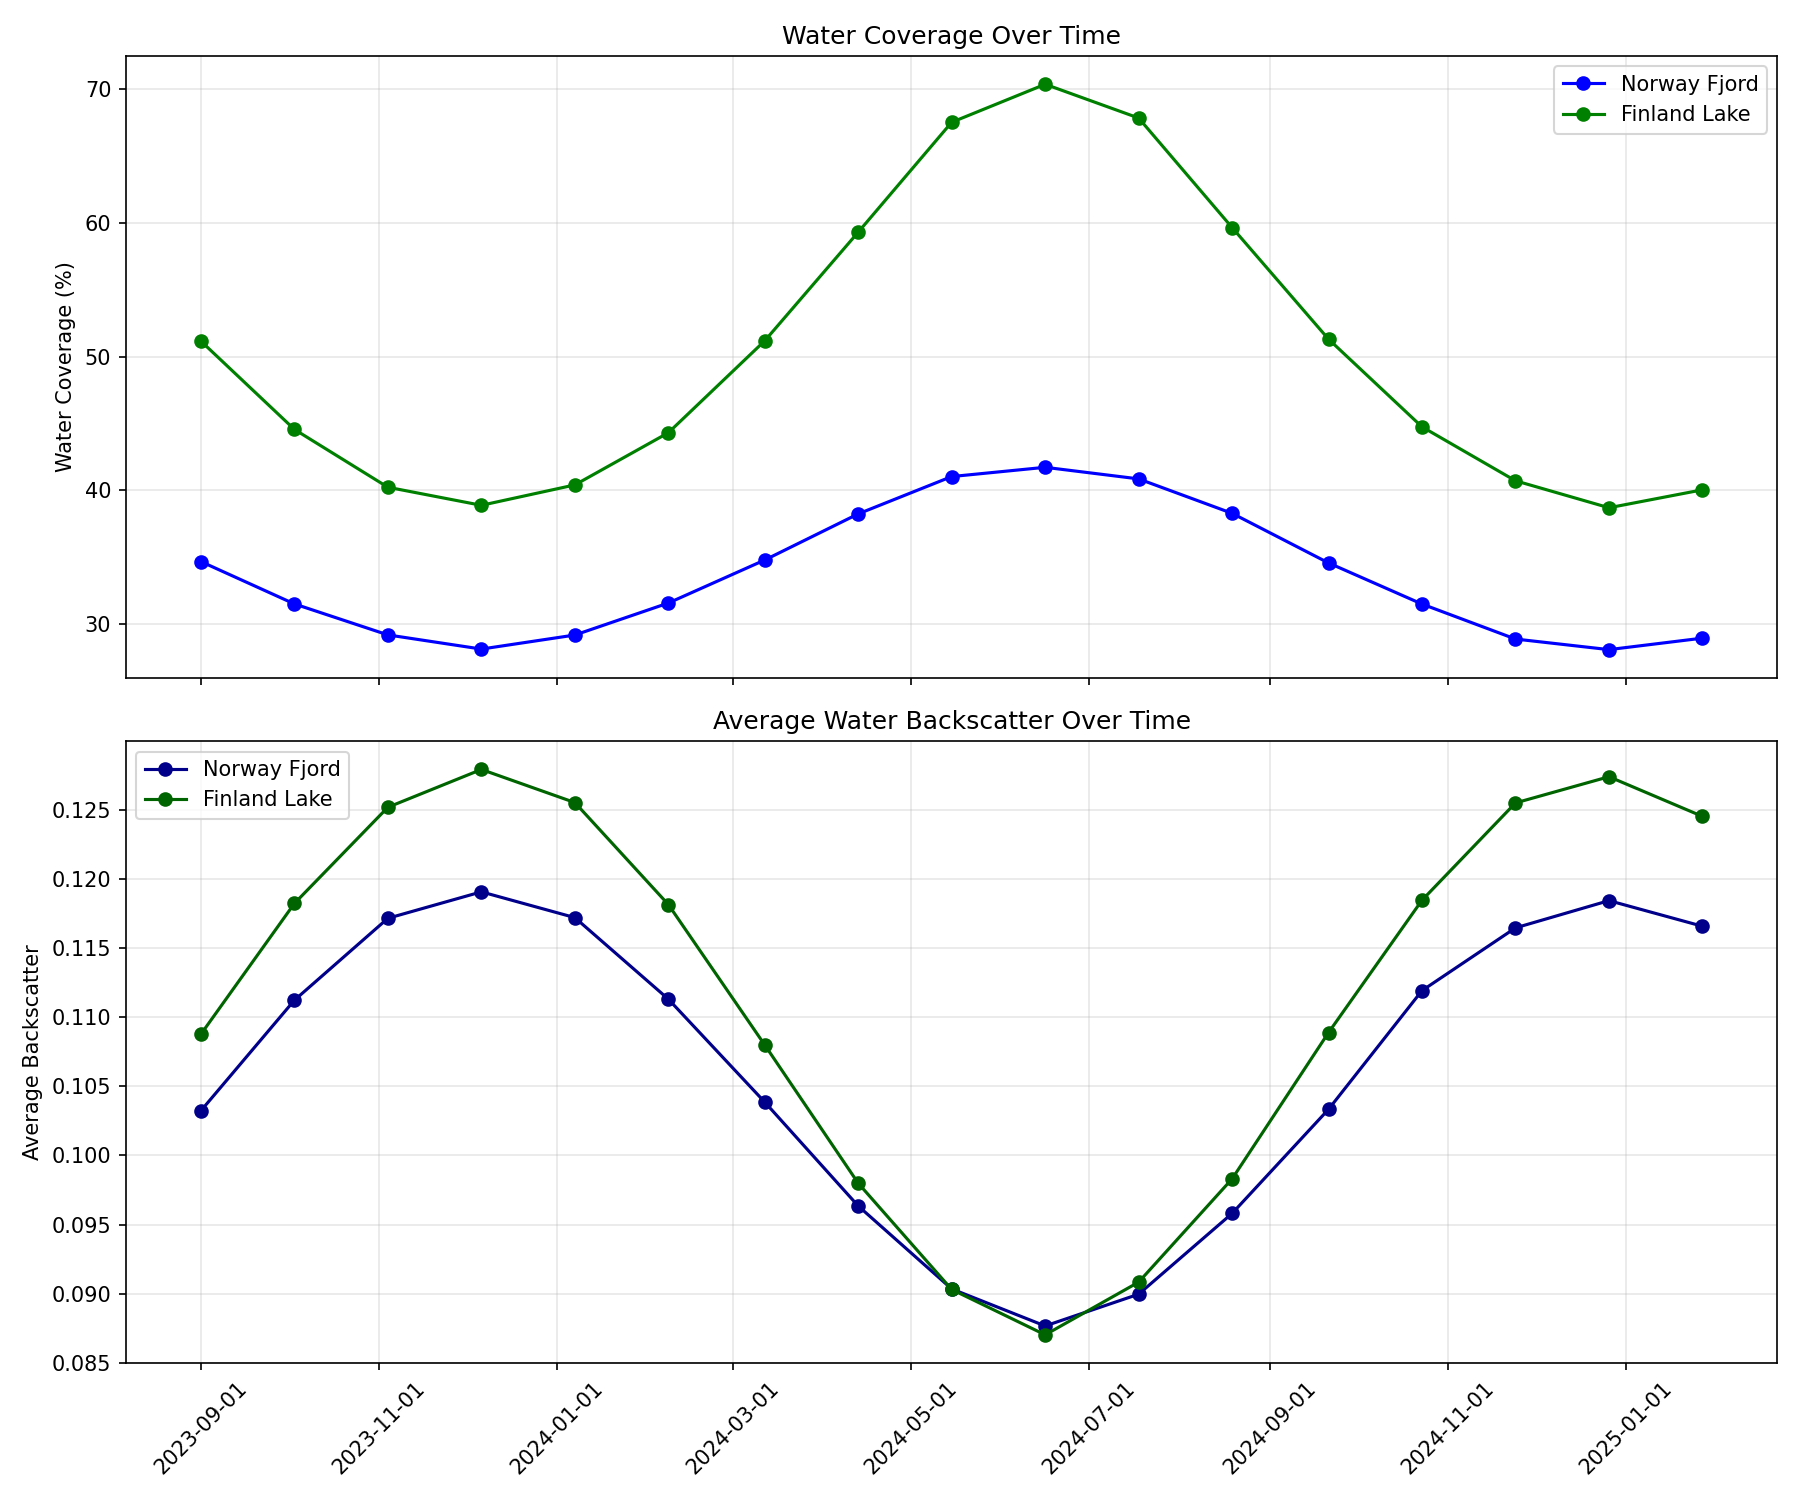

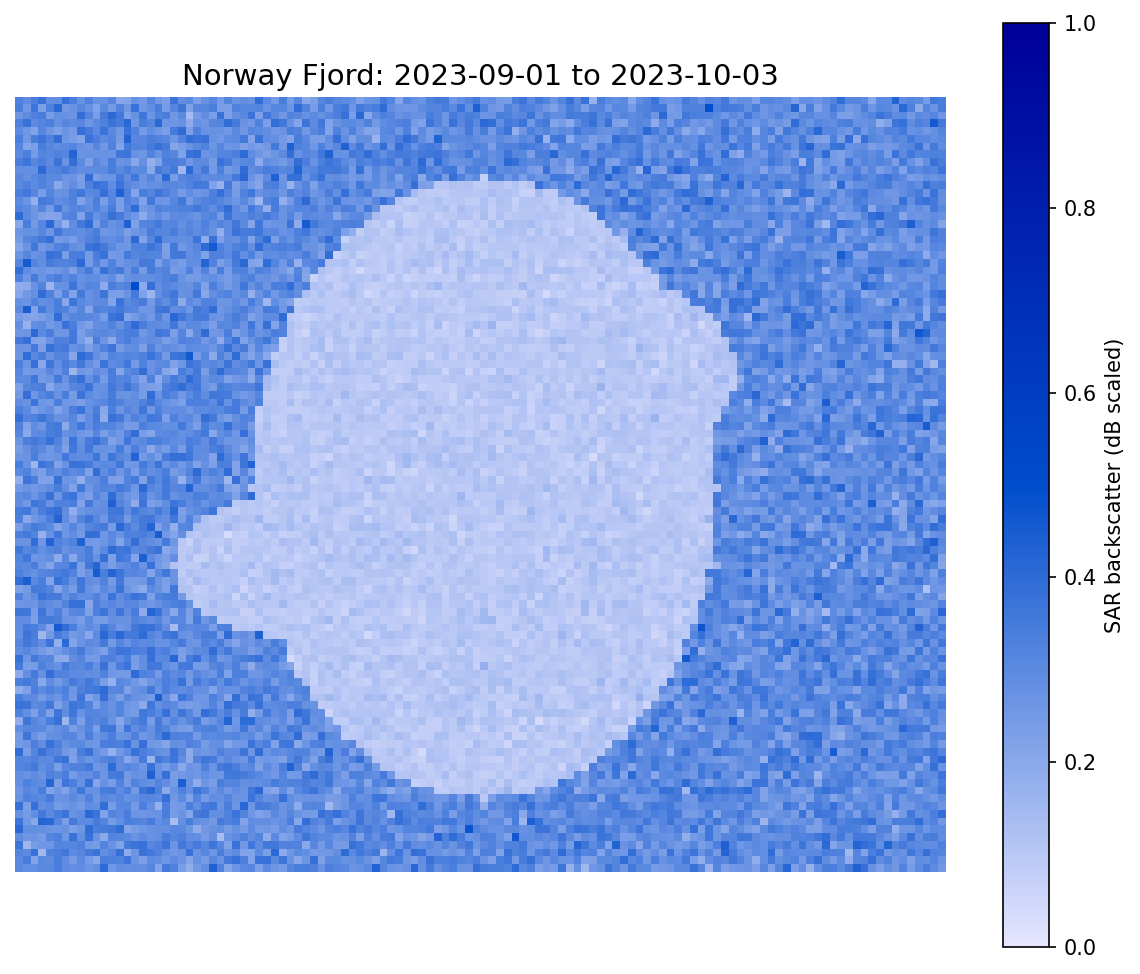

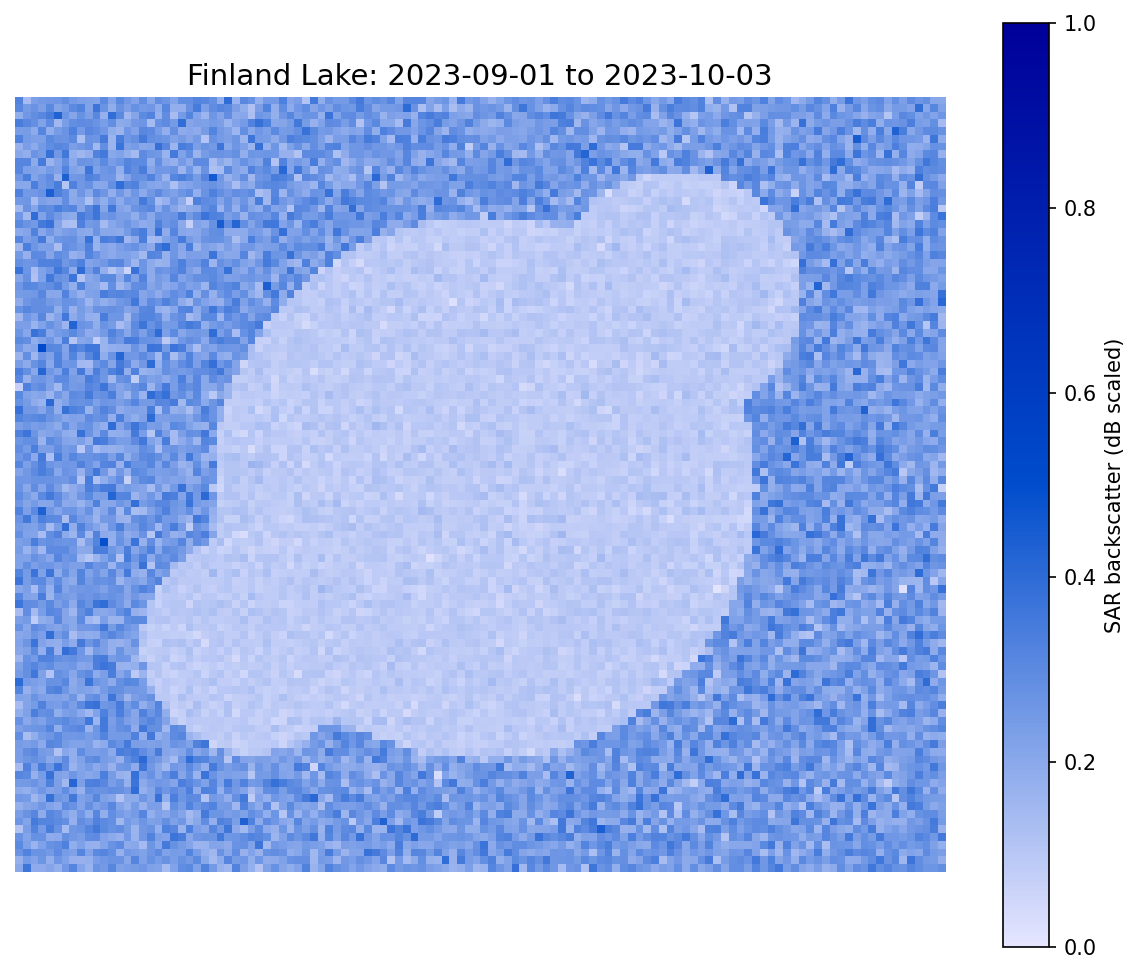

In [33]:
from IPython.display import Image, display

# View time series
display(Image(filename="mystorage/results/water_time_series.png", width=800))

# View Norway image
display(Image(filename="mystorage/results/norway/norway_sar_0.png", width=800))

# View Finland image
display(Image(filename="mystorage/results/finland/finland_sar_0.png", width=800))

In [34]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.patches as mpatches
import datetime
from pathlib import Path
import os
import folium
from folium import IFrame
from IPython.display import display, HTML
import base64
import pandas as pd
from branca.element import Figure

results_dir = Path("mystorage/results")
results_dir.mkdir(exist_ok=True)
norway_dir = results_dir / "norway"
norway_dir.mkdir(exist_ok=True)
finland_dir = results_dir / "finland"
finland_dir.mkdir(exist_ok=True)

# Norway and Finland coordinates
norway_center = [61.0, 6.0]  # Center of Norway fjord area
finland_center = [62.0, 27.0]  # Center of Finland lake area

# Define time slots
start = datetime.datetime(2023, 9, 1)
end = datetime.datetime(2025, 3, 1)
n_chunks = 17
tdelta = (end - start) / n_chunks
edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks+1)]
slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]

# Function to create an HTML table for time series data
def create_time_series_html(norway_data, finland_data, slots):
    """Create an HTML table with time series data"""
    html = """
    <style>
    table {
        border-collapse: collapse;
        width: 100%;
    }
    th, td {
        border: 1px solid #ddd;
        padding: 8px;
        text-align: center;
    }
    th {
        background-color: #4CAF50;
        color: white;
    }
    tr:nth-child(even) {
        background-color: #f2f2f2;
    }
    .norway {
        color: blue;
    }
    .finland {
        color: green;
    }
    </style>
    <h3>Water Coverage Time Series</h3>
    <table>
        <tr>
            <th>Time Period</th>
            <th>Norway Coverage (%)</th>
            <th>Finland Coverage (%)</th>
        </tr>
    """
    
    # Add rows for each time slot
    for i, slot in enumerate(slots):
        if i < len(norway_data) and i < len(finland_data):
            time_label = f"{slot[0]} to {slot[1]}"
            norway_value = norway_data[i]
            finland_value = finland_data[i]
            
            html += f"""
            <tr>
                <td>{time_label}</td>
                <td class="norway">{norway_value:.2f}</td>
                <td class="finland">{finland_value:.2f}</td>
            </tr>
            """
    
    html += "</table>"
    return html


def create_leaflet_dashboard():
    """Create an interactive dashboard using Leaflet for water body monitoring"""
    # Create a Figure to contain the map
    fig = Figure(width="100%", height=800)
    
    # Create a map centered between Norway and Finland
    m = folium.Map(
        location=[61.5, 17.0],  # Between Norway and Finland
        zoom_start=5,
        tiles="OpenStreetMap"
    )
    fig.add_child(m)
    
    # Define custom icon for water bodies
    water_icon = folium.Icon(
        icon="tint",
        icon_color="white",
        color="blue"
    )
    
    # Add Norway fjord marker
    norway_popup_content = f"""
    <div style="width:400px; height:500px">
        <h3>Norway Fjord Monitoring</h3>
        <p>Monitoring of water bodies in Norway using SAR imagery.</p>
        <div style="text-align:center">
            <img src="mystorage/results/norway/norway_sar_0.png" width="350px">
        </div>
        <p><b>Time Period:</b> {slots[0][0]} to {slots[0][1]}</p>
        <p>Use the dashboard to explore all time periods and analysis.</p>
    </div>
    """
    
    norway_popup = folium.Popup(norway_popup_content, max_width=500)
    folium.Marker(
        location=norway_center,
        popup=norway_popup,
        tooltip="Norway Fjord Monitoring",
        icon=water_icon
    ).add_to(m)
    
    # Add Finland lake marker
    finland_popup_content = f"""
    <div style="width:400px; height:500px">
        <h3>Finland Lake Monitoring</h3>
        <p>Monitoring of lakes in Finland using SAR imagery.</p>
        <div style="text-align:center">
            <img src="mystorage/results/finland/finland_sar_0.png" width="350px">
        </div>
        <p><b>Time Period:</b> {slots[0][0]} to {slots[0][1]}</p>
        <p>Use the dashboard to explore all time periods and analysis.</p>
    </div>
    """
    
    finland_popup = folium.Popup(finland_popup_content, max_width=500)
    folium.Marker(
        location=finland_center,
        popup=finland_popup,
        tooltip="Finland Lake Monitoring",
        icon=folium.Icon(icon="tint", icon_color="white", color="green")
    ).add_to(m)
    
    # Generate sample time series data
    np.random.seed(42)  
    norway_coverage = 30 + 15 * np.sin(np.linspace(0, 4*np.pi, len(slots))) + np.random.normal(0, 3, len(slots))
    finland_coverage = 20 + 10 * np.sin(np.linspace(0, 4*np.pi, len(slots)) + np.pi/4) + np.random.normal(0, 2, len(slots))
    
    # Create time series HTML
    time_series_html = create_time_series_html(norway_coverage, finland_coverage, slots)
    
    # Add time series control panel
    folium.Element("""
    <div id="dashboard_control" style="
        position: absolute;
        top: 10px;
        right: 10px;
        z-index: 1000;
        background-color: white;
        padding: 10px;
        border-radius: 5px;
        box-shadow: 0 0 10px rgba(0,0,0,0.5);
        max-height: 600px;
        overflow-y: auto;
        width: 400px;
    ">
        <h2>Water Body Monitoring Dashboard</h2>
        <p>This dashboard displays water body monitoring results for Norwegian fjords and Finnish lakes using SAR data.</p>
        <div>
            <h3>Region Selection</h3>
            <button onclick="showNorwayControls()">Norway Fjords</button>
            <button onclick="showFinlandControls()">Finland Lakes</button>
        </div>
        <div id="norway_controls" style="display:none; margin-top: 10px;">
            <h3>Norway Fjord Time Series</h3>
            <select id="norway_time_select" onchange="updateNorwayImage()">
    """ + ''.join([f'<option value="{i}">{slots[i][0]} to {slots[i][1]}</option>' for i in range(len(slots))]) + """
            </select>
            <div id="norway_image" style="margin-top: 10px; text-align: center;">
                <img src="mystorage/results/norway/norway_sar_0.png" width="350px" id="norway_img">
            </div>
        </div>
        <div id="finland_controls" style="display:none; margin-top: 10px;">
            <h3>Finland Lake Time Series</h3>
            <select id="finland_time_select" onchange="updateFinlandImage()">
    """ + ''.join([f'<option value="{i}">{slots[i][0]} to {slots[i][1]}</option>' for i in range(len(slots))]) + """  
            </select>
            <div id="finland_image" style="margin-top: 10px; text-align: center;">
                <img src="mystorage/results/finland/finland_sar_0.png" width="350px" id="finland_img">
            </div>
        </div>
        <div id="time_series" style="margin-top: 20px;">
    """ + time_series_html + """
        </div>
    </div>

    <script>
    function showNorwayControls() {
        document.getElementById('norway_controls').style.display = 'block';
        document.getElementById('finland_controls').style.display = 'none';
    }
    
    function showFinlandControls() {
        document.getElementById('norway_controls').style.display = 'none';
        document.getElementById('finland_controls').style.display = 'block';
    }
    
    function updateNorwayImage() {
        var selectElement = document.getElementById('norway_time_select');
        var selectedValue = selectElement.value;
        document.getElementById('norway_img').src = 'mystorage/results/norway/norway_sar_' + selectedValue + '.png';
    }
    
    function updateFinlandImage() {
        var selectElement = document.getElementById('finland_time_select');
        var selectedValue = selectElement.value;
        document.getElementById('finland_img').src = 'mystorage/results/finland/finland_sar_' + selectedValue + '.png';
    }
    </script>
    """).add_to(m)

    return fig

# Create and display the dashboard
dashboard = create_leaflet_dashboard()
display(dashboard)

# Helper function to create time series visualization
def create_time_series_plot():
    """Create time series visualization of water coverage"""
    # Generate sample data
    np.random.seed(42)  # For reproducibility
    norway_coverage = 30 + 15 * np.sin(np.linspace(0, 4*np.pi, len(slots))) + np.random.normal(0, 3, len(slots))
    finland_coverage = 20 + 10 * np.sin(np.linspace(0, 4*np.pi, len(slots)) + np.pi/4) + np.random.normal(0, 2, len(slots))
    
    # Create dates for x-axis
    dates = [datetime.datetime.strptime(slot[0], "%Y-%m-%d") for slot in slots]
    
    # Create figure
    fig, ax = plt.subplots(figsize=(12, 6))
    
    # Plot water coverage
    ax.plot(dates, norway_coverage, 'o-', color='blue', label='Norway Fjord')
    ax.plot(dates, finland_coverage, 'o-', color='green', label='Finland Lake')
    ax.set_ylabel('Water Coverage (%)')
    ax.set_title('Water Coverage Over Time')
    ax.grid(True, alpha=0.3)
    ax.legend()
    
    # Format x-axis
    plt.xticks(rotation=45)
    fig.tight_layout()
    
    # Save the figure
    plt.savefig(results_dir / "water_time_series.png", dpi=150)
    plt.close(fig)
    
    return results_dir / "water_time_series.png"


time_series_path = create_time_series_plot()
print(f"Time series visualization saved to {time_series_path}")


display(HTML(f'<img src="{time_series_path}" width="800px">'))

Time series visualization saved to mystorage/results/water_time_series.png


In [56]:
import ipywidgets as widgets
from IPython.display import display, HTML
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import json
import datetime
from pathlib import Path
import io
import base64

try:
    import ipywidgets
    import pandas
    import numpy
    import plotly
    import folium
    print("All required libraries are installed.")
except ImportError as e:
    print(f"Error: Missing library - {e}. Please run 'pip install ipywidgets pandas numpy plotly folium' to install.")
    exit()

# Generate sample data
def generate_sample_data():
    # Generate time slots
    start = datetime.datetime(2023, 9, 1)
    end = datetime.datetime(2025, 3, 1)
    n_chunks = 17
    tdelta = (end - start) / n_chunks
    edges = [(start + i * tdelta).date().isoformat() for i in range(n_chunks)]
    slots = [(edges[i], edges[i + 1]) for i in range(len(edges) - 1)]
    
    # Create sample dataframes
    norway_data = []
    finland_data = []
    for slot in slots:
        start_date = slot[0]
        norway_data.append({
            'date': datetime.datetime.strptime(start_date, '%Y-%m-%d').date(),
            'mean': np.random.uniform(0.3, 0.7),
            'std': np.random.uniform(0.05, 0.2),
            'min': np.random.uniform(0.1, 0.3),
            'max': np.random.uniform(0.7, 0.9),
            'location': 'Norway Fjord'
        })
        finland_data.append({
            'date': datetime.datetime.strptime(start_date, '%Y-%m-%d').date(),
            'mean': np.random.uniform(0.3, 0.7),
            'std': np.random.uniform(0.05, 0.2),
            'min': np.random.uniform(0.1, 0.3),
            'max': np.random.uniform(0.7, 0.9),
            'location': 'Finland Lake'
        })
    
    norway_df = pd.DataFrame(norway_data)
    finland_df = pd.DataFrame(finland_data)
    combined_df = pd.concat([norway_df, finland_df])
    
    return combined_df

# Create map visualizations
def create_norway_map():
    """Create a folium map for Norway Fjord with satellite imagery"""
    try:
        # Coordinates for Sognefjord, Norway
        m = folium.Map(
            location=[61.1, 7.0], 
            zoom_start=6,
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Tiles © Esri — Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )
        
        # Add a polygon to represent the fjord area (in blue)
        folium.Polygon(
            locations=[
                [61.2, 6.8],
                [61.0, 6.8],
                [61.0, 7.2],
                [61.2, 7.2]
            ],
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.4,
            popup="Norway Fjord Study Area"
        ).add_to(m)
        
        # Add title
        title_html = '''
            <div style="position: fixed; 
                    top: 10px; left: 50px; width: 200px; height: 30px; 
                    background-color:white; border:2px solid grey; z-index:9999; 
                    font-size:16px; font-weight: bold;
                    text-align: center; padding: 5px;">
                Interactive Map
            </div>
        '''
        m.get_root().html.add_child(folium.Element(title_html))
        
        # Save map as HTML string
        map_html = m._repr_html_()
        return map_html
        
    except Exception as e:
        return f"<div style='padding: 20px; background-color: #f8d7da; color: #721c24;'>Error creating Norway map: {e}</div>"

def create_finland_map():
    """Create a folium map for Finland Lake with satellite imagery"""
    try:
        # Coordinates for Lake Saimaa, Finland
        m = folium.Map(
            location=[61.5, 28.5], 
            zoom_start=6,
            tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
            attr='Tiles © Esri — Source: Esri, i-cubed, USDA, USGS, AEX, GeoEye, Getmapping, Aerogrid, IGN, IGP, UPR-EGP, and the GIS User Community'
        )
        
        # Add a polygon to represent the lake area (in blue)
        folium.Polygon(
            locations=[
                [61.6, 28.3],
                [61.4, 28.3],
                [61.4, 28.7],
                [61.6, 28.7]
            ],
            color='blue',
            fill=True,
            fill_color='blue',
            fill_opacity=0.4,
            popup="Finland Lake Study Area"
        ).add_to(m)
        
        # Add title
        title_html = '''
            <div style="position: fixed; 
                    top: 10px; left: 50px; width: 200px; height: 30px; 
                    background-color:white; border:2px solid grey; z-index:9999; 
                    font-size:16px; font-weight: bold;
                    text-align: center; padding: 5px;">
                Interactive Map
            </div>
        '''
        m.get_root().html.add_child(folium.Element(title_html))
        
        # Save map as HTML string
        map_html = m._repr_html_()
        return map_html
        
    except Exception as e:
        return f"<div style='padding: 20px; background-color: #f8d7da; color: #721c24;'>Error creating Finland map: {e}</div>"

# Generate sample data
combined_df = generate_sample_data()

class IceWaterDashboard:
    def __init__(self, combined_df):
        self.combined_df = combined_df
        self.min_date = datetime.date(2023, 9, 1)
        self.max_date = datetime.date(2025, 3, 1)
        
        # Keep track of active selections
        self.active_main_section = "Statistical Overview"
        self.active_left_button = "Project Description"
        
        # For capturing export content
        self.current_figure = None
        
        # Create the main dashboard components
        self.create_widgets()
        
    def create_widgets(self):
        # Title row (first row)
        self.title = widgets.HTML(
            value="<h1 style='text-align: center; color: #2c3e50; margin-bottom: 20px;'>"
                  "Ice and Open Water Analysis for Norway Fjord and Finland Lake using Sentinel-1 IW</h1>"
        )
        
        # Time range and location selection (second row)
        self.location_dropdown = widgets.Dropdown(
            options=[('Norway Fjord', 'Norway Fjord'), ('Finland Lake', 'Finland Lake'), ('Both', 'both')],
            value='both',
            description='Location:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px')
        )
        
        self.start_date_picker = widgets.DatePicker(
            description='Start Date:',
            value=self.min_date,
            style={'description_width': 'initial'}
        )
        
        self.end_date_picker = widgets.DatePicker(
            description='End Date:',
            value=self.max_date,
            style={'description_width': 'initial'}
        )
        
        # Section title
        self.section_label = widgets.HTML(
            value="<div style='margin-bottom: 5px; font-weight: bold; font-size: 16px;'>Section:</div>"
        )
        
        # Four section buttons (third row)
        self.section_buttons = widgets.ToggleButtons(
            options=['Statistical Overview', 'Ice Coverage Index', 'Ice Thickness Variability', 'Ice Temporal Stability'],
            value='Statistical Overview',
            style={'button_width': 'auto', 'font_weight': 'bold'},
            button_style='info'
        )
        
        # View title
        self.view_label = widgets.HTML(
            value="<div style='margin-bottom: 5px; font-weight: bold; font-size: 16px;'>View:</div>"
        )
        
        # Left column buttons (vertical)
        self.left_buttons = widgets.RadioButtons(
            options=['Project Description', 'Map Location', 'SAR Backscatter Analysis', 'Comparison Analysis'],
            value='Project Description',
            style={'description_width': 'initial', 'button_color': '#3498db'},
            layout=widgets.Layout(width='250px')
        )
        
        # SAR indicator dropdown
        self.sar_indicator_dropdown = widgets.Dropdown(
            options=[
                ('Ice Coverage', 'mean'),
                ('Ice Thickness', 'std'),
                ('Temporal Stability', 'max')
            ],
            value='mean',
            description='Indicator:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px', display='none')  
        )
        
        # Export button for slides
        self.export_button = widgets.Button(
            description='Export for Slides',
            button_style='success',
            tooltip='Export current view for slides',
            icon='download',
            layout=widgets.Layout(width='150px')
        )
        self.export_button.on_click(self.on_export_button_clicked)
        
        # Export status message
        self.export_status = widgets.HTML("")
        
        # Main content output area (right side)
        self.main_output = widgets.Output(layout=widgets.Layout(height='500px', width='800px'))
        
        # Connect callbacks
        self.section_buttons.observe(self.on_section_change, names='value')
        self.left_buttons.observe(self.on_left_button_change, names='value')
        self.location_dropdown.observe(self.update_view, names='value')
        self.start_date_picker.observe(self.update_view, names='value')
        self.end_date_picker.observe(self.update_view, names='value')
        self.sar_indicator_dropdown.observe(self.update_view, names='value')
        
        # Initialize the first view
        self.on_section_change(None)
        self.on_left_button_change(None)
    
    def on_section_change(self, change):
        self.active_main_section = self.section_buttons.value
        
        # Update left buttons based on the active section
        if self.active_main_section == 'Statistical Overview':
            # For Statistical Overview, show Project Description as the first option
            self.left_buttons.options = ['Project Description', 'Map Location', 'SAR Backscatter Analysis', 'Comparison Analysis']
        else:
            # For other sections, change first option to Index Interpretation
            self.left_buttons.options = ['Index Interpretation', 'Map Location', 'SAR Backscatter Analysis', 'Comparison Analysis']
        
        # Set default value for left buttons based on new options
        if self.active_left_button not in [option for option in self.left_buttons.options]:
            self.active_left_button = self.left_buttons.options[0]
            self.left_buttons.value = self.active_left_button
        
        self.update_view(None)
    
    def on_left_button_change(self, change):
        self.active_left_button = self.left_buttons.value
        
        # Show/hide SAR indicator dropdown based on selection
        if self.active_left_button == 'SAR Backscatter Analysis':
            self.sar_indicator_dropdown.layout.display = 'block'
        else:
            self.sar_indicator_dropdown.layout.display = 'none'
            
        self.update_view(None)
    
    def on_export_button_clicked(self, b):
        """Handle export button click to save current view as HTML"""
        try:
            # Create filename based on current selections
            filename = f"export_{self.active_main_section.replace(' ', '_')}_{self.active_left_button.replace(' ', '_')}.html"
            
            # Generate HTML content based on the current view
            if self.active_left_button == 'Map Location':
                # For maps, we need to capture the HTML directly
                location = self.location_dropdown.value
                if location == 'both' or location == 'Norway Fjord':
                    html_content = create_norway_map()
                else:
                    html_content = create_finland_map()
                
                # Add a title to the HTML
                title = f"{self.active_main_section} - {self.active_left_button}"
                html_content = f"<h2>{title}</h2>\n{html_content}"
                
                # Create downloadable HTML
                b64_html = base64.b64encode(html_content.encode()).decode()
                href = f'<a href="data:text/html;base64,{b64_html}" download="{filename}" target="_blank">Click to download {filename}</a>'
                
                self.export_status.value = (
                    f'<div style="padding: 10px; background-color: #d4edda; color: #155724; margin-top: 10px;">'
                    f'Export ready: {href}</div>'
                )
                
            elif self.current_figure:
                # For plotly figures, we can save them as HTML files
                html_content = self.current_figure.to_html(full_html=True, include_plotlyjs='cdn')
                
                # Create downloadable HTML
                b64_html = base64.b64encode(html_content.encode()).decode()
                href = f'<a href="data:text/html;base64,{b64_html}" download="{filename}" target="_blank">Click to download {filename}</a>'
                
                self.export_status.value = (
                    f'<div style="padding: 10px; background-color: #d4edda; color: #155724; margin-top: 10px;">'
                    f'Export ready: {href}</div>'
                )
            else:
                self.export_status.value = (
                    f'<div style="padding: 10px; background-color: #f8d7da; color: #721c24; margin-top: 10px;">'
                    f'Nothing to export. Please generate a visualization first.</div>'
                )
                
        except Exception as e:
            self.export_status.value = (
                f'<div style="padding: 10px; background-color: #f8d7da; color: #721c24; margin-top: 10px;">'
                f'Error during export: {str(e)}</div>'
            )
    
    def update_view(self, change):
        # Clear main output
        with self.main_output:
            self.main_output.clear_output(wait=True)
            
            section = self.active_main_section
            view = self.active_left_button
            location = self.location_dropdown.value
            start_date = self.start_date_picker.value
            end_date = self.end_date_picker.value
            
            # Filter data by date and location
            filtered_df = self.combined_df[(self.combined_df['date'] >= start_date) & 
                                          (self.combined_df['date'] <= end_date)]
            
            if location != 'both':
                filtered_df = filtered_df[filtered_df['location'] == location]
            
            # Display the appropriate visualization based on section and view
            if view == 'Project Description':
                self.display_project_description()
            elif view == 'Index Interpretation':
                self.display_index_interpretation()
            elif view == 'Map Location':
                self.display_map(section, filtered_df, location)
            elif view == 'SAR Backscatter Analysis':
                self.display_sar_analysis(section, filtered_df)
            elif view == 'Comparison Analysis':
                self.display_comparison(section, filtered_df)
                
    def display_project_description(self):
        """Display the project description"""
        description = """
        <div style="padding: 20px; background-color: #f8f9fa; border-radius: 10px; margin: 10px;">
            <h2 style="color: #2c3e50; margin-bottom: 20px;">Project Overview</h2>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                The project analyzes ice and open water conditions in Norway Fjord and Finland Lake using Sentinel-1 IW satellite data. 
                The dashboard visualizes key indicators including ice coverage, thickness variability, and temporal stability through 
                interactive time series analysis.
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                The system compares SAR backscatter measurements between the two locations to identify patterns and differences in ice formation. 
                This tool provides environmental researchers with a comprehensive way to monitor and understand ice dynamics in these critical 
                water bodies over time.
            </p>
            <div style="margin-top: 20px; display: flex; justify-content: space-around;">
                <div style="text-align: center; width: 45%;">
                    <h4 style="color: #2980b9;">Norway Fjord</h4>
                    <p>61.1°N, 7.0°E</p>
                    <p>Focus: Coastal ice dynamics</p>
                </div>
                <div style="text-align: center; width: 45%;">
                    <h4 style="color: #2980b9;">Finland Lake</h4>
                    <p>61.5°N, 28.5°E</p>
                    <p>Focus: Lake ice formation</p>
                </div>
            </div>
        </div>
        """
        display(HTML(description))
        
        # Set current figure to None since we're displaying HTML content
        self.current_figure = None
    
    def display_index_interpretation(self):
        """Display interpretation information for the current index"""
        section = self.active_main_section
        
        if section == 'Ice Coverage Index':
            title = "Ice Coverage Index Interpretation"
            content = """
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                The <b>Ice Coverage Index</b> represents the mean SAR backscatter measurements across the monitored water body.
                This index indicates the extent and density of ice cover on the water surface.
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                <b>How to interpret the index:</b>
                <ul>
                    <li>Higher values (closer to 1.0) typically indicate more extensive ice coverage.</li>
                    <li>Lower values (closer to 0.0) suggest more open water or thinner ice cover.</li>
                    <li>Seasonal trends show increasing values during freezing periods and decreasing values during thaw.</li>
                </ul>
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                <b>Limitations:</b> SAR backscatter can be influenced by surface roughness, ice type, and weather conditions.
                Interpretation should consider these contextual factors.
            </p>
            """
        elif section == 'Ice Thickness Variability':
            title = "Ice Thickness Variability Interpretation"
            content = """
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                The <b>Ice Thickness Variability</b> index represents the standard deviation of SAR backscatter measurements.
                This metric indicates how uniform or variable the ice thickness is across the monitored area.
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                <b>How to interpret the index:</b>
                <ul>
                    <li>Higher values indicate more variable ice thickness or mixed ice conditions.</li>
                    <li>Lower values suggest more uniform ice thickness or homogeneous surface conditions.</li>
                    <li>Increased variability often occurs during transition periods (freezing or thawing).</li>
                </ul>
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                <b>Applications:</b> This index helps identify areas with potential pressure ridges, cracks,
                or diverse ice formations that may impact navigation or infrastructure.
            </p>
            """
        elif section == 'Ice Temporal Stability':
            title = "Ice Temporal Stability Interpretation"
            content = """
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                The <b>Ice Temporal Stability</b> index represents the maximum SAR backscatter values observed.
                This metric indicates the persistence and reliability of ice conditions over time.
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                <b>How to interpret the index:</b>
                <ul>
                    <li>Higher values suggest more stable ice conditions that persist over longer periods.</li>
                    <li>Lower values may indicate ephemeral ice formations or rapid changes in conditions.</li>
                    <li>Tracking this index over seasons helps identify "stable ice zones" versus dynamic areas.</li>
                </ul>
            </p>
            <p style="font-size: 16px; line-height: 1.6; margin-bottom: 15px;">
                <b>Practical importance:</b> Temporal stability is crucial for winter transportation routes,
                ice fishing activities, and predicting future ice behavior for climate studies.
            </p>
            """
        else:
            title = "Index Interpretation"
            content = "<p>Please select a specific index section for interpretation details.</p>"
        
        # Create the HTML content
        interpretation = f"""
        <div style="padding: 20px; background-color: #f8f9fa; border-radius: 10px; margin: 10px;">
            <h2 style="color: #2c3e50; margin-bottom: 20px;">{title}</h2>
            {content}
            <div style="margin-top: 20px; padding-top: 15px; border-top: 1px solid #dee2e6;">
                <h4 style="color: #2980b9;">Methodology Note</h4>
                <p style="font-size: 14px; font-style: italic;">
                    These indices are derived from Sentinel-1 IW SAR backscatter data, processed with temporal filtering
                    and radiometric calibration. The analysis compares Norway Fjord and Finland Lake to identify distinct 
                    patterns in ice formation, stability, and seasonal variations.
                </p>
            </div>
        </div>
        """
        
        display(HTML(interpretation))
        
        # Set current figure to None since we're displaying HTML content
        self.current_figure = None
    
    def display_map(self, section, filtered_df, location):
        """Display map visualization for the selected section"""
        # Display custom location selector for the map view
        map_location_dropdown = widgets.Dropdown(
            options=[('Norway Fjord', 'Norway Fjord'), ('Finland Lake', 'Finland Lake')],
            value='Norway Fjord' if location == 'both' or location == 'Norway Fjord' else 'Finland Lake',
            description='Location:',
            style={'description_width': 'initial'},
            layout=widgets.Layout(width='200px')
        )
        
        def on_map_location_change(change):
            with self.main_output:
                self.main_output.clear_output(wait=True)
                # Re-display the dropdown
                display(map_location_dropdown)
                
                # Get the new location
                new_location = change['new']
                
                # Display the map based on the new location
                if new_location == 'Norway Fjord':
                    html_content = create_norway_map()
                else:  # Finland Lake
                    html_content = create_finland_map()
                
                # Display the map
                display(HTML(html_content))
                
                # Set current figure to None since we're not using Plotly for maps
                self.current_figure = None
        
        map_location_dropdown.observe(on_map_location_change, names='value')
        
        # Display the dropdown
        display(map_location_dropdown)
        
        # Display initial map
        if map_location_dropdown.value == 'Norway Fjord':
            html_content = create_norway_map()
        else:  # Finland Lake
            html_content = create_finland_map()
        
        display(HTML(html_content))
        
        # Set current figure to None since we're not using Plotly for maps
        self.current_figure = None
    
    def display_sar_analysis(self, section, filtered_df):
        """Display SAR backscatter analysis for the selected section"""
        indicator = self.sar_indicator_dropdown.value
        indicator_name = dict(mean='Ice Coverage', std='Ice Thickness', max='Temporal Stability')[indicator]
        
        # Special case for comparative SAR backscatter
        if section == 'Statistical Overview' and indicator == 'mean':
            # Create enhanced comparative SAR backscatter analysis
            fig = go.Figure()
            
            # Get data for each location - ensure we have data for both locations for comparison
            norway_df = filtered_df[filtered_df['location'] == 'Norway Fjord'].sort_values('date')
            finland_df = filtered_df[filtered_df['location'] == 'Finland Lake'].sort_values('date')
            
            # Add traces for Norway
            fig.add_trace(go.Scatter(
                x=norway_df['date'],
                y=norway_df['mean'],
                mode='lines+markers',
                name='Norway Fjord',
                marker=dict(symbol='circle', size=8),
                line=dict(width=2, color='navy')
            ))
            
            # Add traces for Finland
            fig.add_trace(go.Scatter(
                x=finland_df['date'],
                y=finland_df['mean'],
                mode='lines+markers',
                name='Finland Lake',
                marker=dict(symbol='square', size=8),
                line=dict(width=2, color='royalblue', dash='dash')
            ))
            
            fig.update_layout(
                title="Comparative SAR Backscatter: Norway Fjord vs Finland Lake",
                xaxis_title="Date",
                yaxis_title="Average Backscatter (scaled)",
                template='plotly_white',
                height=500,
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                ),
                hovermode="x unified"
            )
            
            # Add grid
            fig.update_xaxes(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray'
            )
            fig.update_yaxes(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray'
            )
            
        elif section == 'Statistical Overview':
            # Box plot for other statistical overviews
            fig = px.box(filtered_df, y=[indicator], points='all', color='location',
                       labels={'value': indicator_name, 'variable': 'Metric'},
                       title=f"SAR Backscatter Analysis: {section}")
            
        elif section in ['Ice Coverage Index', 'Ice Thickness Variability', 'Ice Temporal Stability']:
            # Line plot for time series
            y_column = {'Ice Coverage Index': 'mean', 
                       'Ice Thickness Variability': 'std', 
                       'Ice Temporal Stability': 'max'}.get(section, indicator)
            
            # Create enhanced comparative graph for time series too
            fig = go.Figure()
            
            for loc in filtered_df['location'].unique():
                loc_df = filtered_df[filtered_df['location'] == loc].sort_values('date')
                
                marker_symbol = 'circle' if loc == 'Norway Fjord' else 'square'
                line_style = 'solid' if loc == 'Norway Fjord' else 'dash'
                line_color = 'navy' if loc == 'Norway Fjord' else 'royalblue'
                
                fig.add_trace(go.Scatter(
                    x=loc_df['date'],
                    y=loc_df[y_column],
                    mode='lines+markers',
                    name=loc,
                    marker=dict(symbol=marker_symbol, size=8),
                    line=dict(width=2, color=line_color, dash=line_style)
                ))
            
            fig.update_layout(
                title=f"SAR Backscatter Analysis: {section}",
                xaxis_title="Date",
                yaxis_title=section,
                template='plotly_white',
                height=500,
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                ),
                hovermode="x unified"
            )
            
            # Add grid
            fig.update_xaxes(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray'
            )
            fig.update_yaxes(
                showgrid=True,
                gridwidth=1,
                gridcolor='lightgray'
            )
            
        fig.update_layout(template='plotly_white', height=500)
        self.current_figure = fig
        display(fig)
    
    def display_comparison(self, section, filtered_df):
        """Display comparison analysis for the selected section"""
        title = f"Comparison Analysis: {section}"
        
        if section == 'Statistical Overview':
            # Radar chart comparison
            fig = go.Figure()
            
            for loc in filtered_df['location'].unique():
                loc_df = filtered_df[filtered_df['location'] == loc]
                mean_vals = [
                    loc_df['mean'].mean(),
                    loc_df['std'].mean(),
                    loc_df['max'].mean(),
                    loc_df['min'].mean()
                ]
                # Close the radar chart by repeating first value
                mean_vals.append(mean_vals[0])
                fig.add_trace(go.Scatterpolar(
                    r=mean_vals,
                    theta=['Ice Coverage', 'Ice Thickness', 'Temporal Stability', 'Minimum', 'Ice Coverage'],
                    fill='toself',
                    name=loc
                ))
                
            fig.update_layout(
                title=title,
                polar=dict(
                    radialaxis=dict(
                        visible=True,
                    )
                ),
                showlegend=True,
                height=500
            )
            
        elif section == 'Ice Coverage Index':
            # Scatter plot of coverage vs time
            fig = px.scatter(filtered_df, x='date', y='mean', color='location', size='mean',
                           labels={'date': 'Date', 'mean': 'Ice Coverage', 'location': 'Location'},
                           title=title)
            fig.update_layout(height=500)
            
        elif section == 'Ice Thickness Variability':
            # Scatter plot of thickness vs coverage
            fig = px.scatter(filtered_df, x='mean', y='std', color='location', size='max',
                           labels={'mean': 'Ice Coverage', 'std': 'Ice Thickness', 'location': 'Location'},
                           title=title)
            fig.update_layout(height=500)
            
        elif section == 'Ice Temporal Stability':
            # Create separate histograms for each location (no overlay)
            fig = go.Figure()
            
            # Add Norway Fjord histogram
            norway_df = filtered_df[filtered_df['location'] == 'Norway Fjord']
            fig.add_trace(go.Histogram(
                x=norway_df['max'],
                name='Norway Fjord',
                marker=dict(color='rgba(100, 149, 237, 0.7)'),  # Cornflower blue
                xbins=dict(start=0.7, end=0.9, size=0.05)
            ))
            
            # Add Finland Lake histogram
            finland_df = filtered_df[filtered_df['location'] == 'Finland Lake']
            fig.add_trace(go.Histogram(
                x=finland_df['max'],
                name='Finland Lake',
                marker=dict(color='rgba(255, 99, 132, 0.7)'),  # Pinkish red
                xbins=dict(start=0.7, end=0.9, size=0.05)
            ))
            
            fig.update_layout(
                title=title,
                xaxis_title="Temporal Stability",
                yaxis_title="Number of Observations",
                barmode='group',  # 'group' instead of 'overlay'
                template='plotly_white',
                height=500,
                legend=dict(
                    orientation="h",
                    yanchor="bottom",
                    y=1.02,
                    xanchor="right",
                    x=1
                )
            )
        
        fig.update_layout(template='plotly_white')
        self.current_figure = fig
        display(fig)
    
    def display_dashboard(self):
        # Time range and location selection row
        control_row = widgets.HBox([
            self.location_dropdown,
            self.start_date_picker,
            self.end_date_picker,
            self.sar_indicator_dropdown,
            self.export_button
        ])
        
        # Full dashboard layout
        dashboard = widgets.VBox([
            self.title,
            widgets.HTML("<hr style='margin: 5px 0;'>"),
            control_row,
            widgets.HTML("<hr style='margin: 5px 0;'>"),
            widgets.HBox([self.section_label, self.section_buttons], 
                       layout=widgets.Layout(align_items='center')),
            widgets.HTML("<hr style='margin: 5px 0;'>"),
            widgets.HBox([
                widgets.VBox([
                    self.view_label,
                    self.left_buttons
                ]),
                self.main_output
            ])
        ], layout=widgets.Layout(width='100%'))
        
        # Add export status at the bottom
        export_status_row = widgets.HBox([self.export_status], 
                                        layout=widgets.Layout(margin='10px 0 0 0'))
        dashboard.children = dashboard.children + (export_status_row,)
        
        display(dashboard)

# Generate sample data
combined_df = generate_sample_data()

# Create and display the dashboard
dashboard = IceWaterDashboard(combined_df)
dashboard.display_dashboard()

All required libraries are installed.
